# Study Group3 Embedding

## Â•ó‰ª∂

In [1]:
import pandas as pd
import jieba
import jieba.analyse
import re
import numpy as np
from collections import defaultdict
import multiprocessing

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec, KeyedVectors

from gensim.models import Word2Vec

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns
import torch

from matplotlib.font_manager import fontManager
import plotly.express as px

sns.set_style("darkgrid")

## 1. ÊñáÂ≠óÂâçËôïÁêÜ

DcardÁ†îÁ©∂ÊâÄÁâàË≥áÊñôÈõÜ                            
ÊôÇÈñìÔºö2025/01/01 - 2025/04/27

In [2]:
dcard = pd.read_csv("ProjectData/dcard_20250101-20250427.csv")

In [3]:
dcard.head(3)

system_id dataSource                                             artUrl  \
0          1      Dcard  https://www.dcard.tw/f/graduate_school/p/25776...   
1          2      Dcard  https://www.dcard.tw/f/graduate_school/p/25776...   
2          3      Dcard  https://www.dcard.tw/f/graduate_school/p/25776...   

               artDate            artTitle  \
0  2025-01-15 14:14:32  #Â≠∏Ë°ìÂïèÂç∑ ÂºµÈÉÅÊïèËÄÅÂ∏´ÂúãÁßëÊúÉË®àÁï´ÂïèÂç∑   
1  2025-01-15 14:55:55               Á†îÁ©∂ÊâÄÈÅ∏Êìá   
2  2025-01-15 14:54:42          ‰∏≠ËààÊúÉÁ†îÊâÄ ÊîæÊ£ÑË´ãÁõä   

                                          artContent          boardID  \
0  ÊÇ®Â•ΩÔºåÊàëÂÄëÊòØÊîøÂ§ßÂª£ÂëäÁ≥ªÂºµÈÉÅÊïèËÄÅÂ∏´Á†îÁ©∂ÂúòÈöäÔºå \nÁõÆÂâçÊ≠£Âú®ÈÄ≤Ë°å‰∏ÄÈ†ÖË™øÊü•ÔºåÊÉ≥Ë¶ÅË´ãÊÇ®ËßÄÁúãÂª£ÂëäÂΩ±ÁâáÂèä...  graduate_school   
1  ÊÉ≥ÂïèÂ§ßÂÆ∂Â¶ÇÊûú‰∏≠ËààÊùêÊñô„ÄÅ‰∏≠Â±±ÊùêÂÖâ„ÄÅÂè∞ÁßëÊáâÁßëÈÉΩ‰∏ä‰∫Ü‰Ω†ÂÄëÊúÉÈÅ∏Âì™‰∏ÄÈñì\nhttps://sticke...  graduate_school   
2                          Ê≠§ÁØáÊñáÁ´†ÁÇ∫ËΩâË≤ºÊñáÁ´†ÔºåË´ãÊõ¥Êñ∞Ëá≥ÊúÄÊñ∞ÁâàÊú¨ËßÄÁúãÂÆåÊï¥ÂÖßÂÆπ„ÄÇ  graduate_school   

   commentCount department gender    school  
0             0        NaN      F    ÂúãÁ´ãÊîøÊ≤ªÂ§ßÂ≠∏  
1            13        NaN      F  ÂúãÁ´ãËá∫ÁÅ£ÁßëÊäÄÂ§ßÂ≠∏  
2             1        NaN      M  ÂúãÁ´ãÂΩ∞ÂåñÂ∏´ÁØÑÂ§ßÂ≠∏

In [4]:
len(dcard)

8325

In [5]:
# Ë®≠ÂÆöÁπÅÈ´î‰∏≠ÊñáË©ûÂ∫´
jieba.set_dictionary('./dict/dict.txt.big')
jieba.load_userdict('./dict/user_dict.txt')

# Êñ∞Â¢ûstopwords
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

Building prefix dict from c:\Users\User\Desktop\VSCode_Workspace\Python\SM\SMA_2025S\Project_3\dict\dict.txt.big ...
Loading model from cache C:\Users\User\AppData\Local\Temp\jieba.u729592c1f8dc564972302061dd9fe8ee.cache
Loading model cost 0.982 seconds.
Prefix dict has been built successfully.


In [6]:
# Êñ∑Ë©ûÂáΩÂºè
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1] # ÁØ©ÈÅ∏ÊéâÂÅúÁî®Â≠óËàáÂ≠óÂÖÉÊï∏Â∞èÊñº1ÁöÑË©ûÂΩô

    return seg_list

In [7]:
# Ë≥áÊñôÂâçËôïÁêÜ

# ÂéªÈô§‰∏Ä‰∫õ‰∏çÈúÄË¶ÅÁöÑÊ¨Ñ‰Ωç
metaData = dcard.drop(['dataSource', 'boardID', 'commentCount', 'department', 'gender', 'school'], axis=1)

# Âè™Áïô‰∏ã‰∏≠ÊñáÂ≠ó
metaData['sentence'] = metaData['artContent'].str.replace(r'\n\n','„ÄÇ', regex=True)
metaData['sentence'] = metaData['sentence'].str.replace(r'\n','', regex=True)

metaData['sentence'] = metaData['sentence'].str.split("[,Ôºå„ÄÇÔºÅ!Ôºü?]{1,}")
metaData = metaData.explode('sentence').reset_index(drop=True)

metaData = metaData[metaData['sentence'].apply(lambda x: isinstance(x, str))].copy()
metaData['sentence'] = metaData['sentence'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

metaData['word'] = metaData.sentence.apply(getToken)

metaData = metaData[metaData['word'].apply(len) > 0]

metaData.head(10)

system_id                                             artUrl  \
0          1  https://www.dcard.tw/f/graduate_school/p/25776...   
1          1  https://www.dcard.tw/f/graduate_school/p/25776...   
2          1  https://www.dcard.tw/f/graduate_school/p/25776...   
3          1  https://www.dcard.tw/f/graduate_school/p/25776...   
4          1  https://www.dcard.tw/f/graduate_school/p/25776...   
5          1  https://www.dcard.tw/f/graduate_school/p/25776...   
6          1  https://www.dcard.tw/f/graduate_school/p/25776...   
7          1  https://www.dcard.tw/f/graduate_school/p/25776...   
8          1  https://www.dcard.tw/f/graduate_school/p/25776...   
9          1  https://www.dcard.tw/f/graduate_school/p/25776...   

               artDate            artTitle  \
0  2025-01-15 14:14:32  #Â≠∏Ë°ìÂïèÂç∑ ÂºµÈÉÅÊïèËÄÅÂ∏´ÂúãÁßëÊúÉË®àÁï´ÂïèÂç∑   
1  2025-01-15 14:14:32  #Â≠∏Ë°ìÂïèÂç∑ ÂºµÈÉÅÊïèËÄÅÂ∏´ÂúãÁßëÊúÉË®àÁï´ÂïèÂç∑   
2  2025-01-15 14:14:32  #Â≠∏Ë°ìÂïèÂç∑ ÂºµÈÉÅÊïèËÄÅÂ∏´ÂúãÁßëÊúÉË®àÁï´ÂïèÂç∑   
3  2025-01-15 14:14:32  #Â≠∏Ë°ìÂïèÂç∑ ÂºµÈÉÅÊïèËÄÅÂ∏´ÂúãÁßëÊúÉË®àÁï´ÂïèÂç∑   
4  2025-01-15 14:14:32  #Â≠∏Ë°ìÂïèÂç∑ ÂºµÈÉÅÊïèËÄÅÂ∏´ÂúãÁßëÊúÉË®àÁï´ÂïèÂç∑   
5  2025-01-15 14:14:32  #Â≠∏Ë°ìÂïèÂç∑ ÂºµÈÉÅÊïèËÄÅÂ∏´ÂúãÁßëÊúÉË®àÁï´ÂïèÂç∑   
6  2025-01-15 14:14:32  #Â≠∏Ë°ìÂïèÂç∑ ÂºµÈÉÅÊïèËÄÅÂ∏´ÂúãÁßëÊúÉË®àÁï´ÂïèÂç∑   
7  2025-01-15 14:14:32  #Â≠∏Ë°ìÂïèÂç∑ ÂºµÈÉÅÊïèËÄÅÂ∏´ÂúãÁßëÊúÉË®àÁï´ÂïèÂç∑   
8  2025-01-15 14:14:32  #Â≠∏Ë°ìÂïèÂç∑ ÂºµÈÉÅÊïèËÄÅÂ∏´ÂúãÁßëÊúÉË®àÁï´ÂïèÂç∑   
9  2025-01-15 14:14:32  #Â≠∏Ë°ìÂïèÂç∑ ÂºµÈÉÅÊïèËÄÅÂ∏´ÂúãÁßëÊúÉË®àÁï´ÂïèÂç∑   

                                          artContent           sentence  \
0  ÊÇ®Â•ΩÔºåÊàëÂÄëÊòØÊîøÂ§ßÂª£ÂëäÁ≥ªÂºµÈÉÅÊïèËÄÅÂ∏´Á†îÁ©∂ÂúòÈöäÔºå \nÁõÆÂâçÊ≠£Âú®ÈÄ≤Ë°å‰∏ÄÈ†ÖË™øÊü•ÔºåÊÉ≥Ë¶ÅË´ãÊÇ®ËßÄÁúãÂª£ÂëäÂΩ±ÁâáÂèä...                 ÊÇ®Â•Ω   
1  ÊÇ®Â•ΩÔºåÊàëÂÄëÊòØÊîøÂ§ßÂª£ÂëäÁ≥ªÂºµÈÉÅÊïèËÄÅÂ∏´Á†îÁ©∂ÂúòÈöäÔºå \nÁõÆÂâçÊ≠£Âú®ÈÄ≤Ë°å‰∏ÄÈ†ÖË™øÊü•ÔºåÊÉ≥Ë¶ÅË´ãÊÇ®ËßÄÁúãÂª£ÂëäÂΩ±ÁâáÂèä...  ÊàëÂÄëÊòØÊîøÂ§ßÂª£ÂëäÁ≥ªÂºµÈÉÅÊïèËÄÅÂ∏´Á†îÁ©∂ÂúòÈöä   
2  ÊÇ®Â•ΩÔºåÊàëÂÄëÊòØÊîøÂ§ßÂª£ÂëäÁ≥ªÂºµÈÉÅÊïèËÄÅÂ∏´Á†îÁ©∂ÂúòÈöäÔºå \nÁõÆÂâçÊ≠£Âú®ÈÄ≤Ë°å‰∏ÄÈ†ÖË™øÊü•ÔºåÊÉ≥Ë¶ÅË´ãÊÇ®ËßÄÁúãÂª£ÂëäÂΩ±ÁâáÂèä...         ÁõÆÂâçÊ≠£Âú®ÈÄ≤Ë°å‰∏ÄÈ†ÖË™øÊü•   
3  ÊÇ®Â•ΩÔºåÊàëÂÄëÊòØÊîøÂ§ßÂª£ÂëäÁ≥ªÂºµÈÉÅÊïèËÄÅÂ∏´Á†îÁ©∂ÂúòÈöäÔºå \nÁõÆÂâçÊ≠£Âú®ÈÄ≤Ë°å‰∏ÄÈ†ÖË™øÊü•ÔºåÊÉ≥Ë¶ÅË´ãÊÇ®ËßÄÁúãÂª£ÂëäÂΩ±ÁâáÂèä...    ÊÉ≥Ë¶ÅË´ãÊÇ®ËßÄÁúãÂª£ÂëäÂΩ±ÁâáÂèäÂõûÁ≠îÂïèÈ°å   
4  ÊÇ®Â•ΩÔºåÊàëÂÄëÊòØÊîøÂ§ßÂª£ÂëäÁ≥ªÂºµÈÉÅÊïèËÄÅÂ∏´Á†îÁ©∂ÂúòÈöäÔºå \nÁõÆÂâçÊ≠£Âú®ÈÄ≤Ë°å‰∏ÄÈ†ÖË™øÊü•ÔºåÊÉ≥Ë¶ÅË´ãÊÇ®ËßÄÁúãÂª£ÂëäÂΩ±ÁâáÂèä...            Ê≠§Ë™øÊü•Âè™ÈúÄÂàÜÈêò   
5  ÊÇ®Â•ΩÔºåÊàëÂÄëÊòØÊîøÂ§ßÂª£ÂëäÁ≥ªÂºµÈÉÅÊïèËÄÅÂ∏´Á†îÁ©∂ÂúòÈöäÔºå \nÁõÆÂâçÊ≠£Âú®ÈÄ≤Ë°å‰∏ÄÈ†ÖË™øÊü•ÔºåÊÉ≥Ë¶ÅË´ãÊÇ®ËßÄÁúãÂª£ÂëäÂΩ±ÁâáÂèä...           Â∞±ÊúâÊ©üÊúÉÂèÉÂä†ÊäΩÁçé   
6  ÊÇ®Â•ΩÔºåÊàëÂÄëÊòØÊîøÂ§ßÂª£ÂëäÁ≥ªÂºµÈÉÅÊïèËÄÅÂ∏´Á†îÁ©∂ÂúòÈöäÔºå \nÁõÆÂâçÊ≠£Âú®ÈÄ≤Ë°å‰∏ÄÈ†ÖË™øÊü•ÔºåÊÉ≥Ë¶ÅË´ãÊÇ®ËßÄÁúãÂª£ÂëäÂΩ±ÁâáÂèä...        Êú¨Á†îÁ©∂Ë®™ÂïèÂ∞çË±°ÁÇ∫Ê≠≤‰ª•‰∏ä   
7  ÊÇ®Â•ΩÔºåÊàëÂÄëÊòØÊîøÂ§ßÂª£ÂëäÁ≥ªÂºµÈÉÅÊïèËÄÅÂ∏´Á†îÁ©∂ÂúòÈöäÔºå \nÁõÆÂâçÊ≠£Âú®ÈÄ≤Ë°å‰∏ÄÈ†ÖË™øÊü•ÔºåÊÉ≥Ë¶ÅË´ãÊÇ®ËßÄÁúãÂª£ÂëäÂΩ±ÁâáÂèä...            Â¶ÇÊûúÊÇ®È°òÊÑèÂèÉÂä†   
8  ÊÇ®Â•ΩÔºåÊàëÂÄëÊòØÊîøÂ§ßÂª£ÂëäÁ≥ªÂºµÈÉÅÊïèËÄÅÂ∏´Á†îÁ©∂ÂúòÈöäÔºå \nÁõÆÂâçÊ≠£Âú®ÈÄ≤Ë°å‰∏ÄÈ†ÖË™øÊü•ÔºåÊÉ≥Ë¶ÅË´ãÊÇ®ËßÄÁúãÂª£ÂëäÂΩ±ÁâáÂèä...            Ë´ãÈÄ£Áµê‰∏ãÂàóÁ∂≤ÂùÄ   
9  ÊÇ®Â•ΩÔºåÊàëÂÄëÊòØÊîøÂ§ßÂª£ÂëäÁ≥ªÂºµÈÉÅÊïèËÄÅÂ∏´Á†îÁ©∂ÂúòÈöäÔºå \nÁõÆÂâçÊ≠£Âú®ÈÄ≤Ë°å‰∏ÄÈ†ÖË™øÊü•ÔºåÊÉ≥Ë¶ÅË´ãÊÇ®ËßÄÁúãÂª£ÂëäÂΩ±ÁâáÂèä...                 Á∂≤ÂùÄ   

                         word  
0                        [ÊÇ®Â•Ω]  
1  [ÊîøÂ§ß, Âª£ÂëäÁ≥ª, ÂºµÈÉÅÊïè, ËÄÅÂ∏´, Á†îÁ©∂, ÂúòÈöä]  
2                    [‰∏ÄÈ†Ö, Ë™øÊü•]  
3        [ÊÉ≥Ë¶Å, ËßÄÁúã, Âª£Âëä, ÂΩ±Áâá, ÂõûÁ≠î]  
4                    [Ë™øÊü•, ÂàÜÈêò]  
5                [Ê©üÊúÉ, ÂèÉÂä†, ÊäΩÁçé]  
6                [Á†îÁ©∂, Ë®™Âïè, Â∞çË±°]  
7                        [ÂèÉÂä†]  
8                    [ÈÄ£Áµê, Á∂≤ÂùÄ]  
9                        [Á∂≤ÂùÄ]

In [8]:
print("Ë≥áÊñôÁ≠ÜÊï∏:", len(metaData))

Ë≥áÊñôÁ≠ÜÊï∏: 127937


## 2. Word2Vec

In [9]:
sents = metaData['word'].to_list()
bigrams = Phrases(sents,min_count=1, threshold=1000)
bigram_phrasers = Phraser(bigrams)
metaData['word_list_bigrams'] = list(bigram_phrasers[sents])

metaData.head()

system_id                                             artUrl  \
0          1  https://www.dcard.tw/f/graduate_school/p/25776...   
1          1  https://www.dcard.tw/f/graduate_school/p/25776...   
2          1  https://www.dcard.tw/f/graduate_school/p/25776...   
3          1  https://www.dcard.tw/f/graduate_school/p/25776...   
4          1  https://www.dcard.tw/f/graduate_school/p/25776...   

               artDate            artTitle  \
0  2025-01-15 14:14:32  #Â≠∏Ë°ìÂïèÂç∑ ÂºµÈÉÅÊïèËÄÅÂ∏´ÂúãÁßëÊúÉË®àÁï´ÂïèÂç∑   
1  2025-01-15 14:14:32  #Â≠∏Ë°ìÂïèÂç∑ ÂºµÈÉÅÊïèËÄÅÂ∏´ÂúãÁßëÊúÉË®àÁï´ÂïèÂç∑   
2  2025-01-15 14:14:32  #Â≠∏Ë°ìÂïèÂç∑ ÂºµÈÉÅÊïèËÄÅÂ∏´ÂúãÁßëÊúÉË®àÁï´ÂïèÂç∑   
3  2025-01-15 14:14:32  #Â≠∏Ë°ìÂïèÂç∑ ÂºµÈÉÅÊïèËÄÅÂ∏´ÂúãÁßëÊúÉË®àÁï´ÂïèÂç∑   
4  2025-01-15 14:14:32  #Â≠∏Ë°ìÂïèÂç∑ ÂºµÈÉÅÊïèËÄÅÂ∏´ÂúãÁßëÊúÉË®àÁï´ÂïèÂç∑   

                                          artContent           sentence  \
0  ÊÇ®Â•ΩÔºåÊàëÂÄëÊòØÊîøÂ§ßÂª£ÂëäÁ≥ªÂºµÈÉÅÊïèËÄÅÂ∏´Á†îÁ©∂ÂúòÈöäÔºå \nÁõÆÂâçÊ≠£Âú®ÈÄ≤Ë°å‰∏ÄÈ†ÖË™øÊü•ÔºåÊÉ≥Ë¶ÅË´ãÊÇ®ËßÄÁúãÂª£ÂëäÂΩ±ÁâáÂèä...                 ÊÇ®Â•Ω   
1  ÊÇ®Â•ΩÔºåÊàëÂÄëÊòØÊîøÂ§ßÂª£ÂëäÁ≥ªÂºµÈÉÅÊïèËÄÅÂ∏´Á†îÁ©∂ÂúòÈöäÔºå \nÁõÆÂâçÊ≠£Âú®ÈÄ≤Ë°å‰∏ÄÈ†ÖË™øÊü•ÔºåÊÉ≥Ë¶ÅË´ãÊÇ®ËßÄÁúãÂª£ÂëäÂΩ±ÁâáÂèä...  ÊàëÂÄëÊòØÊîøÂ§ßÂª£ÂëäÁ≥ªÂºµÈÉÅÊïèËÄÅÂ∏´Á†îÁ©∂ÂúòÈöä   
2  ÊÇ®Â•ΩÔºåÊàëÂÄëÊòØÊîøÂ§ßÂª£ÂëäÁ≥ªÂºµÈÉÅÊïèËÄÅÂ∏´Á†îÁ©∂ÂúòÈöäÔºå \nÁõÆÂâçÊ≠£Âú®ÈÄ≤Ë°å‰∏ÄÈ†ÖË™øÊü•ÔºåÊÉ≥Ë¶ÅË´ãÊÇ®ËßÄÁúãÂª£ÂëäÂΩ±ÁâáÂèä...         ÁõÆÂâçÊ≠£Âú®ÈÄ≤Ë°å‰∏ÄÈ†ÖË™øÊü•   
3  ÊÇ®Â•ΩÔºåÊàëÂÄëÊòØÊîøÂ§ßÂª£ÂëäÁ≥ªÂºµÈÉÅÊïèËÄÅÂ∏´Á†îÁ©∂ÂúòÈöäÔºå \nÁõÆÂâçÊ≠£Âú®ÈÄ≤Ë°å‰∏ÄÈ†ÖË™øÊü•ÔºåÊÉ≥Ë¶ÅË´ãÊÇ®ËßÄÁúãÂª£ÂëäÂΩ±ÁâáÂèä...    ÊÉ≥Ë¶ÅË´ãÊÇ®ËßÄÁúãÂª£ÂëäÂΩ±ÁâáÂèäÂõûÁ≠îÂïèÈ°å   
4  ÊÇ®Â•ΩÔºåÊàëÂÄëÊòØÊîøÂ§ßÂª£ÂëäÁ≥ªÂºµÈÉÅÊïèËÄÅÂ∏´Á†îÁ©∂ÂúòÈöäÔºå \nÁõÆÂâçÊ≠£Âú®ÈÄ≤Ë°å‰∏ÄÈ†ÖË™øÊü•ÔºåÊÉ≥Ë¶ÅË´ãÊÇ®ËßÄÁúãÂª£ÂëäÂΩ±ÁâáÂèä...            Ê≠§Ë™øÊü•Âè™ÈúÄÂàÜÈêò   

                         word          word_list_bigrams  
0                        [ÊÇ®Â•Ω]                       [ÊÇ®Â•Ω]  
1  [ÊîøÂ§ß, Âª£ÂëäÁ≥ª, ÂºµÈÉÅÊïè, ËÄÅÂ∏´, Á†îÁ©∂, ÂúòÈöä]  [ÊîøÂ§ß, Âª£ÂëäÁ≥ª_ÂºµÈÉÅÊïè, ËÄÅÂ∏´, Á†îÁ©∂, ÂúòÈöä]  
2                    [‰∏ÄÈ†Ö, Ë™øÊü•]                   [‰∏ÄÈ†Ö, Ë™øÊü•]  
3        [ÊÉ≥Ë¶Å, ËßÄÁúã, Âª£Âëä, ÂΩ±Áâá, ÂõûÁ≠î]       [ÊÉ≥Ë¶Å, ËßÄÁúã, Âª£Âëä, ÂΩ±Áâá, ÂõûÁ≠î]  
4                    [Ë™øÊü•, ÂàÜÈêò]                   [Ë™øÊü•, ÂàÜÈêò]

In [10]:
word_freq = defaultdict(int)
# Ë®àÁÆóË©ûÈ†ª
sents = metaData['word_list_bigrams'].tolist()
for sent in sents: # sent ‰∏≠ÁöÑÊØèÂÄãÂè•Â≠ê
    for i in sent: # i ÊòØÂè•Â≠ê‰∏≠ÁöÑÊØèÂÄãÂ≠ó
        word_freq[i] += 1

In [11]:
print(f"total unique words in sentences: {len(word_freq)}")
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

total unique words in sentences: 47714


['ÊïôÊéà', 'ÊôÇÈñì', 'ËÄÅÂ∏´', 'È°åÁõÆ', 'Á†îÁ©∂', 'ËÄÉË©¶', 'ÁúüÁöÑ', 'Èù¢Ë©¶', 'Â≠∏Ê†°', 'Ë´ãÂïè']

In [12]:
print(f"sentence number of corpus: {len(sents)}")
i = 0
for sent in sents:
    i = i + len(sent)
print(f"average length of sentences: {i/len(sents)}")

sentence number of corpus: 127937
average length of sentences: 4.077389652719698


### Word2Vec Ë®àÁÆó

In [13]:
%env PYTHONHASHSEED=2025

env: PYTHONHASHSEED=2025


In [14]:
cores = multiprocessing.cpu_count()
print(f"number of cores: {cores}")

number of cores: 16


In [15]:
# Âª∫Á´ãÊ®°Âûã
w2v_model = Word2Vec(sents,
                     min_count=30,# Â∞èÊñº30Ê¨°tfÁöÑÂ≠óÊúÉË¢´Âà™Èô§
                     window=2,# ÂæÄÂ∑¶Âè≥ÂêÑ2ÁöÑË∑ùÈõ¢
                     vector_size=128,# vector ÁöÑÁ∂≠Â∫¶
                     sample=0.005,# ÊÑàÂ∞èÁöÑË©±ÔºåÈ´òtfÁöÑÂ≠óÊúÉ‰∏çÂÆπÊòìË¢´ÈÅ∏Âà∞
                     alpha=0.001,# learning rate
                     min_alpha=0.0005, # Ëø≠‰ª£Âà∞ÊúÄÂ∞èÁöÑlearning rateÔºålearning rateÊúÉÊÖ¢ÊÖ¢‰∏ãÈôçËá≥min_alpha
                     negative=0,
                     workers=cores-1, # Áî®ÁöÑcpuË≥áÊ∫ê
                     seed=8787,
                     sg = 1,# 0/1 ÊòØÂê¶‰ΩøÁî®skip gram
                     epochs= 30,
                     hs=1 , # hierarchical softmax
                     )

Êü•ÁúãÁµêÊûú

In [ ]:
w2v_model.wv.most_similar('ÊïôÊéà',topn=10)

[('ÂØ¶È©óÂÆ§', 0.7553578615188599),
 ('ËÄÅÂ∏´', 0.7184092998504639),
 ('Èù¢Ë´á', 0.6459323763847351),
 ('ÊåáÂ∞éÊïôÊéà', 0.6330747008323669),
 ('ÂØÑ‰ø°', 0.6165795922279358),
 ('‰∏Ä‰Ωç', 0.5781271457672119),
 ('È¢®Ê†º', 0.5621153116226196),
 ('Ë©ïÂÉπ', 0.5606812834739685),
 ('ÂõûÁ≠î', 0.5464353561401367),
 ('È¢®Ê∞£', 0.531938910484314)]

ËàáÊïôÊéàÊúÄÁõ∏ÈóúÁöÑË©ûÂåÖÂê´ÂØ¶È©óÂÆ§„ÄÅËÄÅÂ∏´„ÄÅÈù¢Ë´á„ÄÅË©ïÂÉπÁ≠âÁ≠âÔºåÈ°ØÁ§∫Â≠∏ÁîüÊôÇÂ∏∏Âú®ÊñáÁ´†‰∏≠ÊèêÂà∞ÈÅ∏ÊìáÊïôÊéàÊôÇÊúÉËÄÉÈáèÂ§öÈ†ÖÂõ†Á¥†„ÄÇ

In [22]:
w2v_model.wv.most_similar('ÊîæÊ¶ú',topn=10)

[('ËÄÉÂÆå', 0.756623387336731),
 ('‰∫åÈöé', 0.7490811944007874),
 ('ÂÖ¨Â∏É', 0.7305058836936951),
 ('Ê≤íÊÉ≥Âà∞', 0.7213373780250549),
 ('Á≠âÂæÖ', 0.7041778564453125),
 ('‰∏ÄÈöé', 0.7012403607368469),
 ('Êé®ÁîÑ', 0.6860736608505249),
 ('Êò®Â§©', 0.6813191771507263),
 ('Ê≤í‰∏ä', 0.6790903806686401),
 ('ÂêçÈ°ç', 0.6754878163337708)]

ÊîæÊ¶úË™ûÊÑèÊúÄÁõ∏ËøëÁöÑË©ûÔºåÂ§öËàáÂçáÂ≠∏ËÄÉË©¶ÊµÅÁ®ãËàáÊÉÖÁ∑íÂèçÊáâÁõ∏ÈóúÔºåÈ°ØÁ§∫Âá∫Â≠∏ÁîüÂú®ÊîæÊ¶úÊúüÈñìÁöÑÁ∂ìÊ≠∑ËàáÂøÉÊÉÖÁãÄÊÖãÔºåÂåÖÂê´ÊµÅÁ®ãÁÑ¶ÊÖÆ„ÄÅÁµêÊûúÂèçÊáâËàáË®éË´ñÈáçÈªû

In [ ]:
w2v_model.wv.most_similar(['Ë≥áÁÆ°','ËêΩÊ¶ú'],topn=10)

[('Ë≥áÂ∑•', 0.8918429613113403),
 ('Áî≤ÁµÑ', 0.8853704333305359),
 ('Â∑•Â∑•', 0.8788183927536011),
 ('‰∏≠Â§Æ', 0.87423175573349),
 ('Ê©üÊ¢∞', 0.8734152317047119),
 ('‰πôÁµÑ', 0.870850682258606),
 ('Èõª‰ø°', 0.8707353472709656),
 ('Á∂ìÁÆ°', 0.8678238391876221),
 ('‰ºÅÁ†î', 0.8632793426513672),
 ('Ê∏Ö‰∫§', 0.8591585159301758)]

„ÄåË≥áÁÆ°„Äç+„ÄåËêΩÊ¶ú„ÄçË™ûÊÑèÁõ∏ËøëÁöÑË©ûÔºåÁµêÊûúÂèçÊò†Âá∫Â≠∏ÁîüÂú®Ë®éË´ñËêΩÊ¶úË≥áÁÆ°Á≥ªÊôÇÁöÑÂ∏∏Ë¶ãÊØîËºÉÂ∞çË±°ÊàñÂÇôÈÅ∏ÊñπÊ°àÔºåÁµêÊûúÂèçÊò†Âá∫Â≠∏ÁîüÂú®Ë®éË´ñËêΩÊ¶úË≥áÁÆ°Á≥ªÊôÇÁöÑÂ∏∏Ë¶ãÊØîËºÉÂ∞çË±°ÊàñÂÇôÈÅ∏ÊñπÊ°àÔºåÂèØËÉΩË®±Â§öÂ≠∏ÁîüÊúÉÈÅ∏ÊìáË≥áÂ∑•‰ª•ÂèäË≥áÁÆ°‰∏ÄËµ∑ËÄÉÔºåÈÄôÈ°ØÁ§∫Âá∫ÂÖ©ËÄÖÂú®Â≠∏ÁîüÂøÉ‰∏≠ÂÖ∑ÊúâÈ´òÂ∫¶ÁöÑÁõ∏ÈóúÊÄß„ÄÇ

In [30]:
# Ë∑üÂÖ©ÂÄãÂ≠óÊúÄ‰∏çÁõ∏Èóú
w2v_model.wv.most_similar(negative=['Âè∞Â§ß','‰∫§Â§ß'],topn=10)

[('Ë≥ºË≤∑', 0.508388876914978),
 ('Â∑•ÂÖ∑', 0.4461105167865753),
 ('Á∑ö‰∏ä', 0.4384077489376068),
 ('ÊåÅÁ∫å', 0.4376583993434906),
 ('Ë®òÈåÑ', 0.4342939555644989),
 ('ÈÅéÁöÑ', 0.42897263169288635),
 ('Á§æÁæ§', 0.4255159795284271),
 ('ÊÉÖÁ∑í', 0.4201357066631317),
 ('Â§•‰º¥', 0.41574329137802124),
 ('ÊôÇÊÆµ', 0.4084504246711731)]

In [47]:
# Ë®àÁÆóÂÖ©ÂÄãÂ≠ó‰πãÈñìÁöÑÈóú‰øÇ
w2v_model.wv.similarity("Âè∞Â§ß","ËêΩÊ¶ú")

0.74911404

In [48]:
# Ë®àÁÆóÂÖ©ÂÄãÂ≠ó‰πãÈñìÁöÑÈóú‰øÇ
w2v_model.wv.similarity("‰∏≠Â±±","ËêΩÊ¶ú")

0.8023247

In [50]:
w2v_model.wv.doesnt_match(["Âè∞Â§ß", "‰∏≠Â§Æ", "‰∏≠Â±±", "‰∏≠Ëàà", "‰∏≠Ê≠£"])

'Âè∞Â§ß'

In [45]:
# Áõ∏Â∞çÈóú‰øÇ
w2v_model.wv.most_similar(positive=["‰∏≠Â±±"], negative=["Âè∞Â§ß"], topn=5)

[('ÂåóÁßë', 0.41212156414985657),
 ('ÂÖâÈõª', 0.40799418091773987),
 ('È´òÁßë', 0.4073181450366974),
 ('ÈõªÊ©ü', 0.4071444869041443),
 ('ÂÖàÈÄ≤', 0.4000933766365051)]

In [51]:
# ÂèñÂæóÊâÄÊúâÁöÑÂ≠ó
words = w2v_model.wv.key_to_index.keys()

Ë¶ñË¶∫ÂåñÂ≠ó‰πãÈñìÁöÑÈóú‰øÇÂèäÂ∞áÂ≠óÂÅöÂàÜÁæ§

In [52]:
# ÈôçÁ∂≠ÔºöÂà©Áî®PCA tSNE

def reduceDim(mat,method:str='PCA',dim:str=2,perplexity = 25,learning_rate = 400):

    method_dict = {
        "PCA":PCA(n_components=dim,iterated_power = 1000,random_state=0),
        "TSNE":TSNE(n_components=dim,random_state=0,perplexity=perplexity,learning_rate=learning_rate),
    }
    new_feat = method_dict[method].fit_transform(mat)

    return new_feat


In [53]:
# ÊãøÂà∞list of words ÁöÑvector
def getVecs(model,words:list):
    vecs = []
    for i in words:
        vecs.append(model.wv[i])
    return np.vstack(vecs)

In [54]:
getVecs(w2v_model,['Âè∞Â§ß','‰∏≠Â±±'])

array([[-8.77199322e-02,  1.64501406e-02, -5.46986386e-02,
         3.05936653e-02,  1.45053238e-01, -1.78431466e-01,
         4.12167221e-01, -4.77434881e-02,  3.35328281e-01,
        -1.63946450e-01, -1.47201434e-01,  3.30953181e-01,
        -1.08324639e-01,  9.60322022e-02, -5.31535745e-02,
         6.88736141e-02, -1.82687506e-01, -2.99920775e-02,
         5.15415706e-03,  1.52768523e-01, -1.71254337e-01,
         2.48967856e-01,  4.20202881e-01, -1.86053574e-01,
        -3.24069671e-02, -9.12673622e-02,  1.69645965e-01,
         1.06317729e-01,  3.61738168e-02,  3.64090413e-01,
        -2.72644669e-01, -3.71916480e-02, -2.18338380e-03,
         3.87918130e-02, -3.53085786e-01, -3.21437269e-02,
        -6.06023036e-02,  2.33582765e-01,  1.76431984e-01,
         1.02127023e-01,  3.67481977e-01, -4.46832955e-01,
         6.96235672e-02,  1.63666513e-02,  6.17955886e-02,
         7.44516313e-01, -2.72756100e-01,  3.41749936e-01,
         1.74516290e-01, -7.03042373e-02, -6.48198426e-0

In [55]:
# Êì¥Â±ïÁõ∏‰ººÁöÑÂ≠óË©û
def expandPosWord(model, words:list, top_n:int, split = True):

    if split == False:
        wp = model.wv.most_similar(words,topn = top_n)
        return wp
    expand = []

    for w in words:
        wp = model.wv.most_similar(w,topn = top_n)
        for i in wp:
            expand.append(i[0])

    return list(set(expand))


In [57]:
expandPosWord(w2v_model,['Âè∞Â§ß','‰∏≠Â±±'],top_n = 10)

['‰ºÅÁ†î',
 'Âè∞Áßë',
 'ÂúãË≤ø',
 'ËêΩÊ¶ú',
 'Ë≤°Èáë',
 'ÂïÜÁ†î',
 '‰πôÁµÑ',
 '‰∏≠Ëàà',
 'Ëá∫Â§ß',
 'ÂåóÁßë',
 '‰∏≠Â§Æ',
 'ÂåñÂ≠∏',
 '‰∫§Â§ß',
 'Â∑•Áßë',
 'ÊàêÂ§ß',
 'Âúã‰ºÅ',
 '‰∏ÄÈöé',
 'Áî≤ÁµÑ']

In [58]:
# Áï´Âá∫ÂÖ©Á∂≠ÁöÑÊï£‰ΩàÂúñ
def plotScatter(vec_df):
    """
    vec_df: Â≠óË©ûÂèäÂÖ∂ÂÖ©ÂÄãÁ∂≠Â∫¶ÁöÑÂÄº
    """
    plt.figure(figsize=(15,15))
    fontManager.addfont('./TaipeiSansTCBeta-Regular.ttf')
    plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
    plt.rcParams['font.size'] = '16'

    p = sns.scatterplot(x="dim1", y="dim2",
                  data=vec_df)
    for line in range(0, vec_df.shape[0]):
         p.text(vec_df["dim1"][line],
                 vec_df['dim2'][line],
                 '  ' + vec_df["word"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 weight='normal'
                ).set_size(15)
    plt.show()

# Áï´Âá∫‰∏âÁ∂≠ÁöÑÊï£‰ΩàÂúñ
def plotScatter3D(vec_df):
    vec_df['size'] = .5
    if 'color' not in vec_df.columns:
        vec_df['color'] = 'blue'
    fig = px.scatter_3d(
        vec_df,'dim1','dim2','dim3',text = 'word',width=800, height=800,color = 'color',size = 'size'

    )

    fig.show()

In [59]:
sample_words = np.random.choice(list(words),300,replace=False).tolist()

feat = getVecs(model=w2v_model,words=sample_words)
print(feat.shape)
new_feat = reduceDim(feat,method='TSNE',perplexity=20,learning_rate = 800)
print(new_feat.shape)

(300, 128)
(300, 2)


In [60]:
word_df = pd.DataFrame({
    "word":sample_words,
    "dim1":new_feat[:,0],
    "dim2":new_feat[:,1],
})

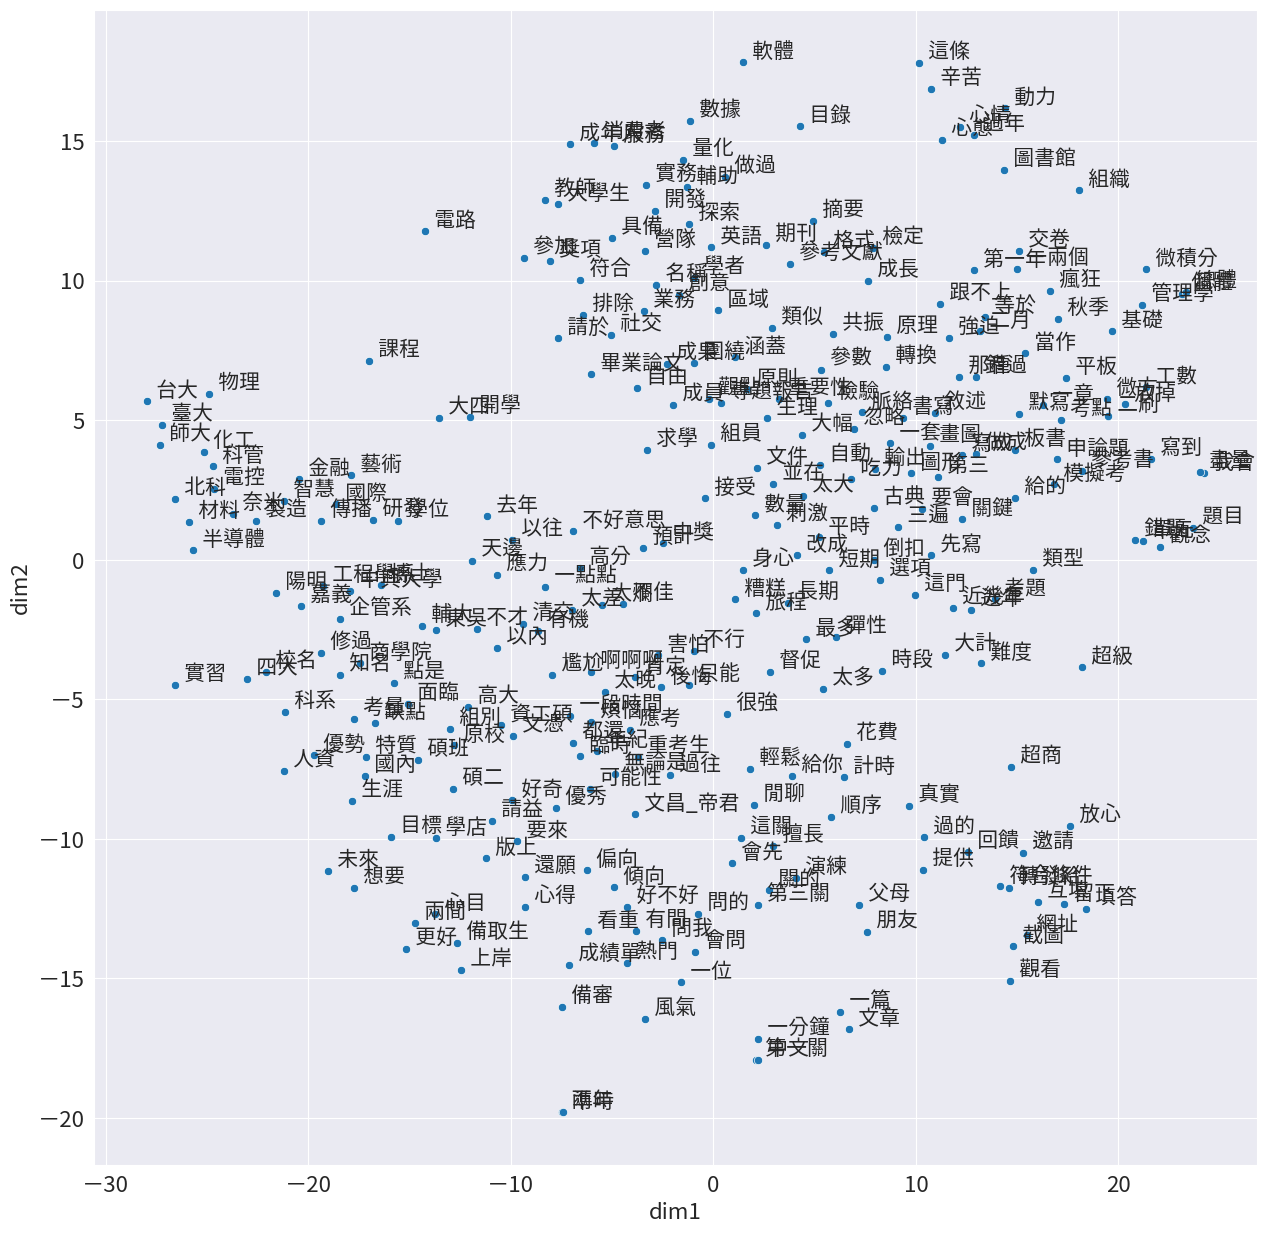

In [61]:
plotScatter(word_df)

- Âè≥‰∏äÂçÄÂüüÂèçÊò†Â≠∏ÁøíÂ£ìÂäõËàáÊàêÁ∏æÔºåË©ûÂΩôÂ¶ÇÔºö„ÄåËæõËã¶„Äç„ÄåÂãïÂäõ„Äç„ÄåÂ∞èÂ£ìÂäõ„Äç„ÄåÂúñÊõ∏È§®„Äç„ÄåÁµÑÁπî„Äç„ÄåÂæÆÁ©çÂàÜ„Äç„ÄåËÄÉÂè§È°å„Äç
- ‰∏≠Èñì‰∏äÊñπÂçÄÂüüÈ°ØÁ§∫Â≠∏ÁîüÊí∞ÂØ´Ë´ñÊñáÁöÑÁõ∏ÈóúË©ûÂΩôÔºåÂ¶Ç„ÄåÊúüÂàä„Äç„ÄåÂØ¶È©ó„Äç„ÄåÁõÆÈåÑ„Äç„ÄåÂèÉËÄÉ„Äç„ÄåÊëòË¶Å„Äç„ÄåÊ†ºÂºè„Äç„ÄåÊï∏Êìö„Äç
- Â∑¶ÈÇä‰∏≠ÈñìÂçÄÂüüÈ°ØÁ§∫Â≠∏Ê†°ËàáÊ†°Á≥ªÈÅ∏ÊìáÔºåÂ¶Ç„ÄåÂè∞Â§ß„Äç„ÄåÂ∏´Â§ß„Äç„ÄåÂåñÂ∑•„Äç„ÄåÈõªÊéß„Äç„ÄåÂåóÁßë„Äç„ÄåÊùêÊñô„Äç„ÄåÂçäÂ∞éÈ´î„Äç

In [62]:
new_feat = reduceDim(feat,dim = 3,method = 'PCA' )
print(new_feat.shape)
word_df = pd.DataFrame({
    "word":sample_words,
    "dim1":new_feat[:,0],
    "dim2":new_feat[:,1],
    "dim3":new_feat[:,2],
})
plotScatter3D(word_df)

(300, 3)


In [63]:
# ÂàÜÁæ§
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
# Âè™‰ΩøÁî®word vector ÂéªÂàÜÁæ§
def cluster(X,method = 'kmeans',n = 2):

    method_dict = {
        'kmeans':KMeans(n_clusters=n, random_state=0),
        'kmedos':KMedoids(n_clusters=n, random_state=0)
    }
    method_dict[method].fit(X)
    result = method_dict[method].predict(X)
    return result

In [64]:
new_feat = reduceDim(feat,method='PCA',dim = 20)
d3_feat = reduceDim(feat,method='PCA',dim = 3)
word_df = pd.DataFrame({
    "word":sample_words,
    "color":cluster(new_feat,n=4),
    "dim1":d3_feat[:,0],
    "dim2":d3_feat[:,1],
    "dim3":d3_feat[:,2],

})
plotScatter3D(word_df)

- ËóçËâ≤ÂçÄÂüüÂ§öÁÇ∫Ëàá„ÄåÊï∏ÁêÜÁõ∏ÈóúÁßëÁõÆ„ÄçÊàñ„ÄåÈáëËûçÁõ∏ÈóúÁßëÁõÆ„ÄçÁõ∏ÈóúÁöÑË©ûÂΩôÔºåË™ûÊÑè‰∏äËÅöÁÑ¶ÊñºÂ≠∏Ë°ìÂ≠∏ÁßëÔºåÂÖ∂‰∏≠ÂåÖÂê´Â∑•Êï∏„ÄÅÂæÆÁ©çÂàÜ„ÄÅÁ∏ΩÈ´î„ÄÅÂÄãÈ´î„ÄÅÊ™¢ÂÆöÁ≠â„ÄÇ
- Á¥´Ëâ≤ÂçÄÂüüÂ§öÁÇ∫Ëàá„ÄåÂçáÂ≠∏ÂøóÈ°ò„ÄÅÊ†°Á≥ªÈÅ∏Êìá„ÄçÁõ∏ÈóúÁöÑË©ûÂΩôÔºåÂÖ∂‰∏≠ÊèêÂà∞Âè∞Â§ß„ÄÅÂåóÁßë„ÄÅÂ∏´Â§ß„ÄÅÈõªÊéß„ÄÅÂåñÂ∑•„ÄÅÊùêÊñô„ÄÅÁßëÁÆ°„ÄÅË≥áÂ∑•Á¢©ÔºåÈÄô‰∫õÈ°ØÁ§∫Âá∫ÂÖ∑‰ª£Ë°®ÊÄßÁöÑÊ†°Á≥ªËàáÁÜ±ÈñÄÁßëÁõÆÔºåÊòØÂ≠∏ÁîüË®éË´ñÂçáÂ≠∏ËêΩÈªûÊôÇÂ∏∏Ë¶ãË©ûÂΩô„ÄÇ
- ÈªÉËâ≤ÂçÄÂüüÂ§öÁÇ∫„ÄåÂ°´ÂïèÂç∑„ÄçÁõ∏ÈóúË©ûÂΩôÔºåÈÄô‰∫õË©ûÂ§öÂá∫ÁèæÂú®ËàáÂ°´ÂØ´Ë°®ÂñÆ„ÄÅÂèÉËàáË™øÊü•„ÄÅË°åÊîøÂõûÈ•ãËàáÁ†îÁ©∂ÂïèÂç∑ÊúâÈóúÁöÑË™ûÂ¢É‰∏≠ÔºåÂÖ∂ÂåÖÂê´Â∞çË±°ÔºåÂ¶ÇÂ≠∏Áîü„ÄÅÊïôÂ∏´„ÄÅÊ∂àË≤ªËÄÖ„ÄÅÊàê‰∫∫ÔºõÂ°´ÂïèÂç∑ÁçéÂãµÔºåÂ¶ÇÁçéÈ†Ö„ÄÅË∂ÖÂïÜÔºõ‰ª•ÂèäÊèèËø∞ÂïèÂç∑ÁôºÊîæËàáÂ°´ÂØ´Ë°åÁÇ∫ÔºåÂ¶ÇÈÇÄË´ã„ÄÅ‰∫íÂ°´„ÄÅËΩâÁôºÁµ¶„ÄÅËßÄÁúã„ÄÇ
- Ê©òËâ≤ÂçÄÂüüÁöÑÂÖßÂÆπÂ§öÁÇ∫Ëàá„ÄåË´ñÊñáÂØ´‰Ωú„ÄçÊàñ„ÄåÂçáÂ≠∏„ÄçÁõ∏ÈóúÁöÑË©ûÂΩôÔºåË´ñÊñáÂØ´‰ΩúÂåÖÂê´ÁöÑË©ûÂΩôÔºåÂ¶ÇÊñáÁçª„ÄÅÊñáÊõ∏„ÄÅÂèÉËÄÉÊñáÁçª„ÄÅÊúüÂàä„ÄÅÊï∏Êìö„ÄÅÊ†ºÂºè„ÄÅÊëòË¶ÅÁ≠âÔºõÂçáÂ≠∏ÂåÖÂê´ÁöÑÁõ∏ÈóúË©ûÂΩôÔºåÂ¶ÇÈ´òÂàÜ„ÄÅÊñáÊòå_Â∏ùÂêõ„ÄÅÈáçËÄÉÁîü„ÄÅÂÇôÂØ©Á≠â„ÄÇ

## Embedding

In [65]:
from sentence_transformers import SentenceTransformer, models, util

In [66]:
# ‰∏≠Êñá bert-base-chinese
bert_ch = SentenceTransformer('google-bert/bert-base-chinese')

bert_ch.tokenizer.add_special_tokens({'pad_token': '[PAD]'})

No sentence-transformers model found with name google-bert/bert-base-chinese. Creating a new one with mean pooling.


0

In [68]:
df_similar = dcard[['system_id','artTitle', 'artContent']]
# ËôïÁêÜ NaN ÊàñÈùûÂ≠ó‰∏≤ÁöÑÊÉÖÊ≥Å
df_similar['artContent'] = df_similar['artContent'].apply(
    lambda x: re.sub('[^\u4e00-\u9fff]+', '', x) if isinstance(x, str) else ''
)

df_similar.head(5)

C:\Users\User\AppData\Local\Temp\ipykernel_16836\599420023.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



system_id            artTitle  \
0          1  #Â≠∏Ë°ìÂïèÂç∑ ÂºµÈÉÅÊïèËÄÅÂ∏´ÂúãÁßëÊúÉË®àÁï´ÂïèÂç∑   
1          2               Á†îÁ©∂ÊâÄÈÅ∏Êìá   
2          3          ‰∏≠ËààÊúÉÁ†îÊâÄ ÊîæÊ£ÑË´ãÁõä   
3          4              Á¢©Â£´Ë´ñÊñáÊéíÁâà   
4          5  ‚ùóÂ°´ÂïèÂç∑ÊäΩÈõªÂΩ±Á•®„ÄÅË∂ÖÂïÜÁ¶ÆÂà∏500ÂÖÉ‚ùó   

                                          artContent  
0  ÊÇ®Â•ΩÊàëÂÄëÊòØÊîøÂ§ßÂª£ÂëäÁ≥ªÂºµÈÉÅÊïèËÄÅÂ∏´Á†îÁ©∂ÂúòÈöäÁõÆÂâçÊ≠£Âú®ÈÄ≤Ë°å‰∏ÄÈ†ÖË™øÊü•ÊÉ≥Ë¶ÅË´ãÊÇ®ËßÄÁúãÂª£ÂëäÂΩ±ÁâáÂèäÂõûÁ≠îÂïèÈ°åÊ≠§Ë™ø...  
1                       ÊÉ≥ÂïèÂ§ßÂÆ∂Â¶ÇÊûú‰∏≠ËààÊùêÊñô‰∏≠Â±±ÊùêÂÖâÂè∞ÁßëÊáâÁßëÈÉΩ‰∏ä‰∫Ü‰Ω†ÂÄëÊúÉÈÅ∏Âì™‰∏ÄÈñì  
2                            Ê≠§ÁØáÊñáÁ´†ÁÇ∫ËΩâË≤ºÊñáÁ´†Ë´ãÊõ¥Êñ∞Ëá≥ÊúÄÊñ∞ÁâàÊú¨ËßÄÁúãÂÆåÊï¥ÂÖßÂÆπ  
3  ‰∏çÁ¢∫ÂÆöÈÄôÊ®£ÁöÑË≥áË®äËÉΩ‰∏çËÉΩÁôºÂú®ÈÄôÈÇäÂ¶ÇÊúâÈÅïË¶èÊàëÊúÉÁ´ãÂç≥Âà™Èô§Âõ†ÁÇ∫Â•ΩÂÉèÊúâÈªûÊ∂âÂèäÂïÜÊ•≠Ë∑ü‰∫§Êòì‰ΩÜÊàëÊòØÁúüÂøÉÊÉ≥Ë¶ÅÁÇ∫...  
4  ÂìàÂõâÂ§ßÂÆ∂Â•ΩÊàëÊòØÁõÆÂâçÂ∞±ËÆÄÊîøÂ§ßÂÇ≥Êí≠Â≠∏Èô¢ÁöÑÁ†îÁ©∂Áîü‰πüÊòØÂÄãÂòâÁæ©Âõ°‰ªîÊ≠£Âú®ÈÄ≤Ë°åÊàëÁöÑÁ¢©Ë´ñÁ†îÁ©∂ÊÉ≥‰∫ÜËß£ÂòâÁæ©Â∏ÇÂΩ±Âüé...

In [69]:
print(torch.__version__)
print(torch.version.cuda)

2.4.1+cu124
12.4


In [70]:
# ‰∏≠Êñá bert-base-chinese
bert_ch = SentenceTransformer('google-bert/bert-base-chinese', device='cuda')

bert_ch.tokenizer.add_special_tokens({'pad_token': '[PAD]'})

No sentence-transformers model found with name google-bert/bert-base-chinese. Creating a new one with mean pooling.


0

In [71]:
corpus_embeddings = bert_ch.encode(
    df_similar['artContent'],
    convert_to_tensor=True,
    batch_size=32
)

c:\Users\User\anaconda3\envs\sm_new\Lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning:

1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)



### Êü•ÁúãembeddingÁµêÊûú

In [75]:
query_num = 89 # ÊåáÂÆöÊñáÁ´†

# Find the closest 5 sentences of the corpus for each query sentence based on cosine similarity
top_k = 5


query_embedding = bert_ch.encode(df_similar['artContent'][query_num], convert_to_tensor=True)

# We use cosine-similarity and torch.topk to find the highest 5 scores
cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
top_results = torch.topk(cos_scores, k=top_k)

print("\n\n======================\n\n")
print("Query:", df_similar['artTitle'][query_num])
print("\n Ë≥áÊñôÈõÜ‰∏≠Ââç‰∫îÁõ∏‰ººÁöÑÊñáÁ´†:")

for score, idx in zip(top_results[0], top_results[1]):
    print(df_similar['artTitle'][idx.item()], "(Score: {:.4f})".format(score))

print("\n\n======================\n\n")





Query: Ë∑™Ê±Ç‰ºÅÁ†îË≤°ÈáëÁµ±Ë®àËÄÉÂè§È°å

 Ë≥áÊñôÈõÜ‰∏≠Ââç‰∫îÁõ∏‰ººÁöÑÊñáÁ´†:
Ë∑™Ê±Ç‰ºÅÁ†îË≤°ÈáëÁµ±Ë®àËÄÉÂè§È°å (Score: 1.0000)
Ë≤°ÈáëÁ∂ìÁ†îÊâÄËÄÉÂè§È°åË©≥Ëß£‰∫§Êèõ (Score: 0.9558)
#Âæµ ‰ºÅÁ†îËÄÉÂè§È°å (Score: 0.9493)
Ê±Ç113Á∂ìÁ†îÊâÄÂÄãÁ∏ΩÈ´îËÄÉÂè§È°åË©≥Ëß£ (Score: 0.9428)
ÂæµÊ±ÇÊîøÂ§ßË≤°Êîø„ÄÅ‰∫§Â§ßË≤°ÈáëËÄÉÂè§È°åËß£Á≠î (Score: 0.9393)






ÊñáÁ´†‰∏ªÈ°åÁÇ∫Êü•Êâæ‰ºÅÁ†îË≤°ÈáëÁ≥ª‰πãËÄÉÂè§È°åÔºåÊü•ÊâæÂÖßÂÆπ‰πüÂ§ßÈÉ®ÂàÜÁÇ∫Áõ∏ÈóúÁßëÁ≥ªÁöÑËÄÉÂè§È°å„ÄÇ

In [79]:
query_num = 96

top_k = 5

query_embedding = bert_ch.encode(df_similar['artContent'][query_num], convert_to_tensor=True)

# We use cosine-similarity and torch.topk to find the highest 5 scores
cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
top_results = torch.topk(cos_scores, k=top_k)

print("\n\n======================\n\n")
print("Query:", df_similar['artTitle'][query_num])
print("\n Ë≥áÊñôÈõÜ‰∏≠Ââç‰∫îÁõ∏‰ººÁöÑÊñáÁ´†:")

for score, idx in zip(top_results[0], top_results[1]):
    print(df_similar['artTitle'][idx.item()], "(Score: {:.4f})".format(score))

print("\n\n======================\n\n")





Query: Ê∏ÖÂ§ß114Â≠∏Âπ¥Â∫¶Á¢©Â£´Áè≠ÁîÑË©¶Á¨¨11Ê¨°ÂÇôÂèñÈÅûË£úÂêçÂñÆ

 Ë≥áÊñôÈõÜ‰∏≠Ââç‰∫îÁõ∏‰ººÁöÑÊñáÁ´†:
Ê∏ÖÂ§ß114Â≠∏Âπ¥Â∫¶Á¢©Â£´Áè≠ÁîÑË©¶Á¨¨11Ê¨°ÂÇôÂèñÈÅûË£úÂêçÂñÆ (Score: 1.0000)
Ê∏ÖÂ§ß114Â≠∏Âπ¥Â∫¶Á¢©Â£´Áè≠ÁîÑË©¶Á¨¨9Ê¨°ÂÇôÂèñÈÅûË£úÂêçÂñÆ (Score: 0.9853)
Ê∏ÖÂ§ß114Â≠∏Âπ¥Â∫¶Á¢©Â£´Áè≠ÁîÑË©¶Á¨¨10Ê¨°ÂÇôÂèñÈÅûË£úÂêçÂñÆ (Score: 0.9853)
Ê∏ÖÂ§ß114Â≠∏Âπ¥Â∫¶Á¢©Â£´Áè≠ËÄÉË©¶Á¨¨5Ê¨°ÂÇôÂèñÈÅûË£úÂêçÂñÆ (Score: 0.9546)
ÂúãÁ´ãËá∫ÁÅ£Â∏´ÁØÑÂ§ßÂ≠∏114Â≠∏Âπ¥Â∫¶ÊäÄËÅ∑ÊïôËÇ≤Êï∏‰ΩçÁ¢©Â£´Âú®ËÅ∑Â∞àÁè≠ÁèæÊ≠£ÊãõÁîü‰∏≠ÔºÅ (Score: 0.9321)






# Classification

In [ ]:
import pandas as pd
import re

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sentence_transformers import SentenceTransformer, models, util

In [ ]:
# ‰∏≠Êñá bert-base-chinese
bert_ch = SentenceTransformer('google-bert/bert-base-chinese', device='cuda')

bert_ch.tokenizer.add_special_tokens({'pad_token': '[PAD]'})

No sentence-transformers model found with name google-bert/bert-base-chinese. Creating a new one with mean pooling.


0

ÂºïÂÖ•ÁöÑË≥áÊñôÈõÜÁÇ∫
- DcardÔºöÁ†îÁ©∂ÊâÄÁâà
- PTTÔºöÁßëÊäÄÂ∑•‰ΩúÁâà„ÄÅËªüÈ´îÂ∑•‰ΩúÁâà 


Á∏ΩË≥áÊñôÁ≠ÜÊï∏ÁÇ∫3864

In [ ]:
df = pd.read_csv('classification_data/graduate_tech_softjob.csv')

In [ ]:
len(df)

3864

In [ ]:
df

artContent  \
0     ÊÇ®Â•ΩÊàëÂÄëÊòØÊîøÂ§ßÂª£ÂëäÁ≥ªÂºµÈÉÅÊïèËÄÅÂ∏´Á†îÁ©∂ÂúòÈöäÁõÆÂâçÊ≠£Âú®ÈÄ≤Ë°å‰∏ÄÈ†ÖË™øÊü•ÊÉ≥Ë¶ÅË´ãÊÇ®ËßÄÁúãÂª£ÂëäÂΩ±ÁâáÂèäÂõûÁ≠îÂïèÈ°åÊ≠§Ë™ø...   
1                          ÊÉ≥ÂïèÂ§ßÂÆ∂Â¶ÇÊûú‰∏≠ËààÊùêÊñô‰∏≠Â±±ÊùêÂÖâÂè∞ÁßëÊáâÁßëÈÉΩ‰∏ä‰∫Ü‰Ω†ÂÄëÊúÉÈÅ∏Âì™‰∏ÄÈñì   
2                               Ê≠§ÁØáÊñáÁ´†ÁÇ∫ËΩâË≤ºÊñáÁ´†Ë´ãÊõ¥Êñ∞Ëá≥ÊúÄÊñ∞ÁâàÊú¨ËßÄÁúãÂÆåÊï¥ÂÖßÂÆπ   
3     ‰∏çÁ¢∫ÂÆöÈÄôÊ®£ÁöÑË≥áË®äËÉΩ‰∏çËÉΩÁôºÂú®ÈÄôÈÇäÂ¶ÇÊúâÈÅïË¶èÊàëÊúÉÁ´ãÂç≥Âà™Èô§Âõ†ÁÇ∫Â•ΩÂÉèÊúâÈªûÊ∂âÂèäÂïÜÊ•≠Ë∑ü‰∫§Êòì‰ΩÜÊàëÊòØÁúüÂøÉÊÉ≥Ë¶ÅÁÇ∫...   
4     ÂìàÂõâÂ§ßÂÆ∂Â•ΩÊàëÊòØÁõÆÂâçÂ∞±ËÆÄÊîøÂ§ßÂÇ≥Êí≠Â≠∏Èô¢ÁöÑÁ†îÁ©∂Áîü‰πüÊòØÂÄãÂòâÁæ©Âõ°‰ªîÊ≠£Âú®ÈÄ≤Ë°åÊàëÁöÑÁ¢©Ë´ñÁ†îÁ©∂ÊÉ≥‰∫ÜËß£ÂòâÁæ©Â∏ÇÂΩ±Âüé...   
...                                                 ...   
3859  ÈÄôÁúüÁöÑÁ™Æ‰∫∫ÁöÑÊÄùÁ∂≠‰ªÄÈ∫ºÊòØÊµ™Ë≤ª‰Ω†ÁèæÂú®ÂØ´ÁöÑÁ®ãÂºèÊåâ‰ª•ÂâçÁöÑÂØ´Ê≥ïÈö®‰æø‰∏ÄÂÄãÂ∞±Â§†‰Ω†ÂØ´‰∏ÄÂÄãÊòüÊúü‰∫Ü‰ΩÜ‰Ω†ÁèæÂú®Èö®‰æøÊãâ...   
3860  ÂâçÈù¢Êúâ‰∏ÄÁØáË¨õÂæóÂæàÂ∞çÊ≤íÊúâÊôÇ‰ª£ÂØ´Á®ãÂºèÊõ¥Â±åÊØîÊúâÊôÇ‰ª£ÈÇÑÂ±åÂõ†ÁÇ∫Âè™ËÉΩË∑ëÊõ∏Â∫óË¶ÅËÆÄÂæàÂ§öÁ¥ôÊú¨ÁöÑÊõ∏ÊâçÊúâËæ¶Ê≥ïÂÅöÂá∫Á®ã...   
3861  Â¶ÇÈ°åÊúÄËøëÂú®Â≠∏ÁøíÈÄôÂÄã‰ΩÜÁ∂≤Ë∑Ø‰∏äÁöÑË≥áÊñôÂ•ΩÂÉèË†ªÊªøÂ∞ëÁöÑ‰∏çÁü•ÈÅìÂèØ‰ª•ÂæÄ‰ªÄÈ∫ºÊñπÂêëÊâæË≥áÊñô‰æÜÂ≠∏Áøí‰ª•ÂèäÈÄôÂÄã‰ΩúÁî®Â∞±ÊòØ...   
3862  ÊâÄ‰ª•ÊàëË™™‰Ω†ÂÄëÈÄô‰∫õÂ∞èÊúãÂèãÊ≤íÊêûÊ∏ÖÊ•öÁ®ãÂºèË™ûË®ÄÁöÑÊúÄÁµÇÁõÆÊ®ô‰∏ä‰∏ÄÁØáÊàëÊèê‰æõÂá∫‰∏ÄÂÄãË£Ω‰Ωú‰∏≠ÊñáÁ®ãÂºèË™ûË®ÄÁöÑÊÉ≥Ê≥ïÊòØË¶Å...   
3863  ÁÇ∫‰∫Ü‰∏çË¶ÅËÆì‰∫∫Ë¶∫ÂæóÈÄôÊòØÂú®ÊääÁßëÊäÄÊ•≠ÁöÑË¨õÂæóÂæà‰∏çÂ†™ÊàëË£úÂÖÖË™™Êòé‰∏Ä‰∏ãÂ•Ω‰∫ÜÈÄôÊÆµÊòØ‰ª•ÊàëÊâÄÁü•ÈÅìÁî±ÁßëÊäÄÊ•≠ÂÖ¨Âè∏Ëá™Â∑±...   

                                                 artUrl     Label  
0     https://www.dcard.tw/f/graduate_school/p/25776...  graduate  
1     https://www.dcard.tw/f/graduate_school/p/25776...  graduate  
2     https://www.dcard.tw/f/graduate_school/p/25776...  graduate  
3     https://www.dcard.tw/f/graduate_school/p/25777...  graduate  
4     https://www.dcard.tw/f/graduate_school/p/25776...  graduate  
...                                                 ...       ...  
3859  https://www.ptt.cc/bbs/Soft_Job/M.1745900730.A...   softjob  
3860  https://www.ptt.cc/bbs/Soft_Job/M.1745934477.A...   softjob  
3861  https://www.ptt.cc/bbs/Soft_Job/M.1745934622.A...   softjob  
3862  https://www.ptt.cc/bbs/Soft_Job/M.1745975132.A...   softjob  
3863  https://www.ptt.cc/bbs/Soft_Job/M.1745993505.A...   softjob  

[3864 rows x 3 columns]

In [ ]:
df = df.dropna(subset=['artContent'])

In [ ]:
len(df)

3848

## ‰ΩøÁî® bert-base-chinese EmbeddingÊ®°ÂûãÈÄ≤Ë°åÂàÜÈ°û‰ªªÂãô

In [ ]:
# ‰∏≠Êñá bert-base-chinese
bert_ch = SentenceTransformer('google-bert/bert-base-chinese', device='cuda')

bert_ch.tokenizer.add_special_tokens({'pad_token': '[PAD]'})

No sentence-transformers model found with name google-bert/bert-base-chinese. Creating a new one with mean pooling.


0

In [ ]:
df = df.rename(columns={
    'artContent': 'content'
})

In [ ]:
df

content  \
0     ÊÇ®Â•ΩÊàëÂÄëÊòØÊîøÂ§ßÂª£ÂëäÁ≥ªÂºµÈÉÅÊïèËÄÅÂ∏´Á†îÁ©∂ÂúòÈöäÁõÆÂâçÊ≠£Âú®ÈÄ≤Ë°å‰∏ÄÈ†ÖË™øÊü•ÊÉ≥Ë¶ÅË´ãÊÇ®ËßÄÁúãÂª£ÂëäÂΩ±ÁâáÂèäÂõûÁ≠îÂïèÈ°åÊ≠§Ë™ø...   
1                          ÊÉ≥ÂïèÂ§ßÂÆ∂Â¶ÇÊûú‰∏≠ËààÊùêÊñô‰∏≠Â±±ÊùêÂÖâÂè∞ÁßëÊáâÁßëÈÉΩ‰∏ä‰∫Ü‰Ω†ÂÄëÊúÉÈÅ∏Âì™‰∏ÄÈñì   
2                               Ê≠§ÁØáÊñáÁ´†ÁÇ∫ËΩâË≤ºÊñáÁ´†Ë´ãÊõ¥Êñ∞Ëá≥ÊúÄÊñ∞ÁâàÊú¨ËßÄÁúãÂÆåÊï¥ÂÖßÂÆπ   
3     ‰∏çÁ¢∫ÂÆöÈÄôÊ®£ÁöÑË≥áË®äËÉΩ‰∏çËÉΩÁôºÂú®ÈÄôÈÇäÂ¶ÇÊúâÈÅïË¶èÊàëÊúÉÁ´ãÂç≥Âà™Èô§Âõ†ÁÇ∫Â•ΩÂÉèÊúâÈªûÊ∂âÂèäÂïÜÊ•≠Ë∑ü‰∫§Êòì‰ΩÜÊàëÊòØÁúüÂøÉÊÉ≥Ë¶ÅÁÇ∫...   
4     ÂìàÂõâÂ§ßÂÆ∂Â•ΩÊàëÊòØÁõÆÂâçÂ∞±ËÆÄÊîøÂ§ßÂÇ≥Êí≠Â≠∏Èô¢ÁöÑÁ†îÁ©∂Áîü‰πüÊòØÂÄãÂòâÁæ©Âõ°‰ªîÊ≠£Âú®ÈÄ≤Ë°åÊàëÁöÑÁ¢©Ë´ñÁ†îÁ©∂ÊÉ≥‰∫ÜËß£ÂòâÁæ©Â∏ÇÂΩ±Âüé...   
...                                                 ...   
3859  ÈÄôÁúüÁöÑÁ™Æ‰∫∫ÁöÑÊÄùÁ∂≠‰ªÄÈ∫ºÊòØÊµ™Ë≤ª‰Ω†ÁèæÂú®ÂØ´ÁöÑÁ®ãÂºèÊåâ‰ª•ÂâçÁöÑÂØ´Ê≥ïÈö®‰æø‰∏ÄÂÄãÂ∞±Â§†‰Ω†ÂØ´‰∏ÄÂÄãÊòüÊúü‰∫Ü‰ΩÜ‰Ω†ÁèæÂú®Èö®‰æøÊãâ...   
3860  ÂâçÈù¢Êúâ‰∏ÄÁØáË¨õÂæóÂæàÂ∞çÊ≤íÊúâÊôÇ‰ª£ÂØ´Á®ãÂºèÊõ¥Â±åÊØîÊúâÊôÇ‰ª£ÈÇÑÂ±åÂõ†ÁÇ∫Âè™ËÉΩË∑ëÊõ∏Â∫óË¶ÅËÆÄÂæàÂ§öÁ¥ôÊú¨ÁöÑÊõ∏ÊâçÊúâËæ¶Ê≥ïÂÅöÂá∫Á®ã...   
3861  Â¶ÇÈ°åÊúÄËøëÂú®Â≠∏ÁøíÈÄôÂÄã‰ΩÜÁ∂≤Ë∑Ø‰∏äÁöÑË≥áÊñôÂ•ΩÂÉèË†ªÊªøÂ∞ëÁöÑ‰∏çÁü•ÈÅìÂèØ‰ª•ÂæÄ‰ªÄÈ∫ºÊñπÂêëÊâæË≥áÊñô‰æÜÂ≠∏Áøí‰ª•ÂèäÈÄôÂÄã‰ΩúÁî®Â∞±ÊòØ...   
3862  ÊâÄ‰ª•ÊàëË™™‰Ω†ÂÄëÈÄô‰∫õÂ∞èÊúãÂèãÊ≤íÊêûÊ∏ÖÊ•öÁ®ãÂºèË™ûË®ÄÁöÑÊúÄÁµÇÁõÆÊ®ô‰∏ä‰∏ÄÁØáÊàëÊèê‰æõÂá∫‰∏ÄÂÄãË£Ω‰Ωú‰∏≠ÊñáÁ®ãÂºèË™ûË®ÄÁöÑÊÉ≥Ê≥ïÊòØË¶Å...   
3863  ÁÇ∫‰∫Ü‰∏çË¶ÅËÆì‰∫∫Ë¶∫ÂæóÈÄôÊòØÂú®ÊääÁßëÊäÄÊ•≠ÁöÑË¨õÂæóÂæà‰∏çÂ†™ÊàëË£úÂÖÖË™™Êòé‰∏Ä‰∏ãÂ•Ω‰∫ÜÈÄôÊÆµÊòØ‰ª•ÊàëÊâÄÁü•ÈÅìÁî±ÁßëÊäÄÊ•≠ÂÖ¨Âè∏Ëá™Â∑±...   

                                                 artUrl     Label  
0     https://www.dcard.tw/f/graduate_school/p/25776...  graduate  
1     https://www.dcard.tw/f/graduate_school/p/25776...  graduate  
2     https://www.dcard.tw/f/graduate_school/p/25776...  graduate  
3     https://www.dcard.tw/f/graduate_school/p/25777...  graduate  
4     https://www.dcard.tw/f/graduate_school/p/25776...  graduate  
...                                                 ...       ...  
3859  https://www.ptt.cc/bbs/Soft_Job/M.1745900730.A...   softjob  
3860  https://www.ptt.cc/bbs/Soft_Job/M.1745934477.A...   softjob  
3861  https://www.ptt.cc/bbs/Soft_Job/M.1745934622.A...   softjob  
3862  https://www.ptt.cc/bbs/Soft_Job/M.1745975132.A...   softjob  
3863  https://www.ptt.cc/bbs/Soft_Job/M.1745993505.A...   softjob  

[3848 rows x 3 columns]

In [ ]:
df["embeddings"] = df["content"].apply(
    lambda x: bert_ch.encode(x) if isinstance(x, str) else None
)


c:\Users\User\anaconda3\envs\sm_new\Lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


In [ ]:
import numpy as np
from ast import literal_eval

Â∞áË®ìÁ∑¥ÈõÜ‰ª•ÂèäÊ∏¨Ë©¶ÈõÜ‰ª•7:3ÁöÑÊØî‰æãÈÄ≤Ë°åÂàáÂàÜ

In [ ]:
data = df.copy()

X = data["embeddings"].apply(pd.Series)
y = data["Label"]

# ÊääÊï¥ÂÄãË≥áÊñôÈõÜ‰∏É‰∏âÂàá
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)

print(X_train.head())
print(y_train.head())

           0         1         2         3         4         5         6    \
3038  0.585334 -0.175041 -0.157785  0.119658 -0.230060 -0.239857 -0.017099   
2339  0.531968 -0.056803 -0.591627  0.012481  0.040651 -0.234697  0.073038   
2842  0.909369 -0.260184  0.131783  0.448909 -0.185889 -0.399488 -0.146622   
1811  0.755504  0.065260 -0.099188  0.303013 -0.081815 -0.543490  0.000289   
3210  0.461746  0.002710 -0.334146  0.043480 -0.213752 -0.324670 -0.036142   

           7         8         9    ...       758       759       760  \
3038 -0.384666 -0.216667 -0.179887  ... -0.027361 -0.049833  0.338184   
2339 -0.275114 -0.159473 -0.403385  ...  0.324449  0.008125  0.209842   
2842 -0.055094  0.246722 -0.290948  ...  0.141078 -0.019427  0.230086   
1811 -0.195169 -0.338885 -0.496776  ... -0.070605  0.005167  0.421076   
3210  0.066870 -0.046056 -0.265670  ...  0.062530 -0.275571  0.292265   

           761       762       763       764       765       766       767  
3038  0.242562 

‰ΩøÁî®4Á®ÆÁöÑÂàÜÈ°ûÊ®°ÂûãÈÄ≤Ë°åÊØîËºÉÔºåÂÖ∂‰∏≠ÂåÖÂê´Ôºö
- Logistic RegressionÔºàÈÇèËºØËø¥Ê≠∏Ôºâ
- Decision TreeÔºàÊ±∫Á≠ñÊ®πÔºâ
- Random ForestÔºàÈö®Ê©üÊ£ÆÊûóÔºâ
- SVMÔºàÊîØÊè¥ÂêëÈáèÊ©üÔºâ

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import classification_report

# ÂÆöÁæ©Ê®°ÂûãÁµÑ
model_set = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': svm.SVC(probability=True)
}

# Âü∑Ë°åË®ìÁ∑¥„ÄÅÈ†êÊ∏¨ËàáÂ†±ÂëäËº∏Âá∫
for name, model in model_set.items():
    print("=" * 100)
    print(f"Training and evaluating: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)

    # Ëº∏Âá∫Ë©ï‰º∞Â†±Âëä
    print(classification_report(y_test, y_pred))
    print("=" * 100)


Training and evaluating: Logistic Regression
              precision    recall  f1-score   support

    graduate       0.95      0.92      0.93       412
     softjob       0.83      0.84      0.83       359
     techjob       0.84      0.86      0.85       384

    accuracy                           0.87      1155
   macro avg       0.87      0.87      0.87      1155
weighted avg       0.87      0.87      0.87      1155

Training and evaluating: Decision Tree
              precision    recall  f1-score   support

    graduate       0.83      0.75      0.78       412
     softjob       0.62      0.71      0.66       359
     techjob       0.71      0.69      0.70       384

    accuracy                           0.72      1155
   macro avg       0.72      0.72      0.72      1155
weighted avg       0.72      0.72      0.72      1155

Training and evaluating: Random Forest
              precision    recall  f1-score   support

    graduate       0.89      0.92      0.91       412
     s

ÁµêÊûúLogistic RegressionÂíåSVMÁÇ∫ÊúÄ‰Ω≥Ê®°ÂûãÔºåÂÖ©ËÄÖË°®ÁèæÁõ∏Áï∂ÔºåËÄåDecision TreeË°®ÁèæÂâáÁÇ∫ÊúÄÂ∑Æ‰πãÊ®°Âûã„ÄÇ      

-------------------------------------------------------------------------------------------------------            

Logistic RegressionËàáSVMÂú®softjobÂàÜÈ°ûÁµêÊûú‰πãÊØîËºÉÔºö
- Logistic RegressionÁöÑprecisionËºÉÈ´òÔºåË°®Á§∫Â∞çsoftjobÁöÑÈ†êÊ∏¨ËºÉÂ∞ëË™§Âà§„ÄÇ
- SVMÁöÑrecallËºÉÈ´òÔºåË°®Á§∫ÂÆÉÊØîËºÉ‰∏çÊòìÊºèÊéâsoftjobÈ°ûÂà•ÁöÑË≥áÊñô„ÄÇ
- ‰ª•f1-score‰æÜË™™ÔºåÂÖ©ËÄÖÂ∑ÆÁï∞ËºÉÂ∞èÔºåË°®ÁèæÁõ∏Áï∂Êé•Ëøë„ÄÇ
-------------------------------------------------------------------------------------------------------      

Logistic RegressionËàáSVMÂú®techjobÂàÜÈ°ûÁµêÊûú‰πãÊØîËºÉÔºö
- SVM ÁöÑprecisionËºÉÈ´òÔºåÈ†êÊ∏¨ÁÇ∫techjobÁöÑÊ®£Êú¨ÔºåÂ§ßÂ§öÁúüÁöÑÂ±¨Êñºtechjob„ÄÇ
- Logistic RegressionÁöÑrecall ËºÉÈ´òÔºåË°®Á§∫Â∞çtechjobÁöÑÊ®£Êú¨Ë≠òÂà•ÂäõÊõ¥Â•Ω„ÄÇ
- f1-score Áõ∏Áï∂ÔºåÂú® techjob‰∏äÂÖ©ËÄÖÁöÑË°®ÁèæÂêåÊ®£Áõ∏Áï∂Êé•Ëøë„ÄÇ

## ‰ΩøÁî® bge-m3 EmbeddingÊ®°ÂûãÈÄ≤Ë°åÂàÜÈ°û‰ªªÂãô
Âåó‰∫¨Êô∫Ê∫êÁ†îÁ©∂Èô¢ÈñãÁôºÁöÑÂ§öË™ûË®ÄembeddingÊ®°ÂûãÔºåÂÖ∂ÊîØÊè¥Ë∂ÖÈÅé100Á®ÆË™ûË®Ä„ÄÇ

In [ ]:
df_bge = pd.read_csv('classification_data/graduate_tech_softjob.csv')

In [ ]:
df_bge = df_bge.dropna(subset=['artContent'])

In [ ]:
df_bge.head(2)

artContent  \
0  ÊÇ®Â•ΩÊàëÂÄëÊòØÊîøÂ§ßÂª£ÂëäÁ≥ªÂºµÈÉÅÊïèËÄÅÂ∏´Á†îÁ©∂ÂúòÈöäÁõÆÂâçÊ≠£Âú®ÈÄ≤Ë°å‰∏ÄÈ†ÖË™øÊü•ÊÉ≥Ë¶ÅË´ãÊÇ®ËßÄÁúãÂª£ÂëäÂΩ±ÁâáÂèäÂõûÁ≠îÂïèÈ°åÊ≠§Ë™ø...   
1                       ÊÉ≥ÂïèÂ§ßÂÆ∂Â¶ÇÊûú‰∏≠ËààÊùêÊñô‰∏≠Â±±ÊùêÂÖâÂè∞ÁßëÊáâÁßëÈÉΩ‰∏ä‰∫Ü‰Ω†ÂÄëÊúÉÈÅ∏Âì™‰∏ÄÈñì   

                                              artUrl     Label  
0  https://www.dcard.tw/f/graduate_school/p/25776...  graduate  
1  https://www.dcard.tw/f/graduate_school/p/25776...  graduate

In [ ]:
from sentence_transformers import SentenceTransformer

# ËºâÂÖ•‰∏≠Êñá embedding Ê®°Âûã
bgeModel = SentenceTransformer("BAAI/bge-m3", device='cuda')
bgeModel.tokenizer.add_special_tokens({'pad_token': '[PAD]'})

# ÂèñÂæó embeddings
df_bge["embeddings"] = df_bge["artContent"].apply(
    lambda x: bgeModel.encode(x) if isinstance(x, str) else None
)

In [ ]:
data = df_bge.copy()

X_bge = data["embeddings"].apply(pd.Series)
y_bge = data["Label"]

X_train_bge, X_test_bge, y_train_bge, y_test_bge = train_test_split(
    X_bge, y_bge, test_size=0.3, random_state=777
)

In [ ]:
# ÂÆöÁæ©Ê®°ÂûãÁµÑ
model_set = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': svm.SVC(probability=True)
}

for name, model in model_set.items():
    print("=" * 100)
    print(f"Training and evaluating: {name}")
    model.fit(X_train_bge, y_train_bge)
    y_pred_bge = model.predict(X_test_bge)
    y_pred_proba_bge = model.predict_proba(X_test_bge)

    # Ëº∏Âá∫Ë©ï‰º∞Â†±Âëä
    print(classification_report(y_test_bge, y_pred_bge))
    print("=" * 100)

Training and evaluating: Logistic Regression
              precision    recall  f1-score   support

    graduate       0.92      0.95      0.94       412
     softjob       0.87      0.82      0.84       359
     techjob       0.86      0.86      0.86       384

    accuracy                           0.88      1155
   macro avg       0.88      0.88      0.88      1155
weighted avg       0.88      0.88      0.88      1155

Training and evaluating: Decision Tree


              precision    recall  f1-score   support

    graduate       0.80      0.78      0.79       412
     softjob       0.62      0.58      0.60       359
     techjob       0.62      0.67      0.64       384

    accuracy                           0.68      1155
   macro avg       0.68      0.68      0.68      1155
weighted avg       0.68      0.68      0.68      1155

Training and evaluating: Random Forest
              precision    recall  f1-score   support

    graduate       0.90      0.94      0.92       412
     softjob       0.82      0.83      0.82       359
     techjob       0.86      0.82      0.84       384

    accuracy                           0.86      1155
   macro avg       0.86      0.86      0.86      1155
weighted avg       0.86      0.86      0.86      1155

Training and evaluating: SVM
              precision    recall  f1-score   support

    graduate       0.94      0.95      0.95       412
     softjob       0.86      0.84      0.85       359
     te

ÂêåÊ®£‰ª•SVMÂíåLogistic Regression‰∏äË°®ÁèæÊúÄÁÇ∫Âá∫Ëâ≤ÔºåËÄåDecision TreeË°®ÁèæÂêåÁÇ∫ÊúÄÂ∑Æ‰πãÊ®°Âûã„ÄÇ 

BGE-M3Âú®softjobÂíåtechjobÈ†êÊ∏¨Êõ¥Á©©ÂÆöÔºåf1-score Êõ¥È´ò„ÄÇ                 
Á∏ΩÁµê‰æÜË™™ÔºåSVMÂú®BGE-M3‰∏≠Ë°®ÁèæÊúÄ‰Ω≥ÔºåÂÖ∂fl-scoreÂÖ∑ÊúâÊúÄÂ•ΩÁöÑË°®Áèæ„ÄÇ

# GROUP4ÔºöBERT (Encoder-only-model)

### Â§ßÁ∂±Ôºö
1. Â•ó‰ª∂‰ªãÁ¥π
2. Ë≥áÊñôÂâçËôïÁêÜ
3. Token classification<br>
  3.1 NER<br>
4. Sequence classification<br>
  4.1 Sentiment Classification<br>
  4.2 Relation Extraction (RE)<br>
5. Text Clustering<br>
  5.1 BERTopic Âü∫Êú¨Áî®Ê≥ï‰ªãÁ¥π<br>
  5.2 BERTopic ÁöÑ Embedding model<br>
  5.3 BERTopic ÁöÑ Clustering model<br>
  5.4 Â•óÁî®‰∏≠ÊñáË≥áÊñô<br>
  5.5 ‰ΩøÁî®RepresentationÊñπÊ≥ïÂéªÂæÆË™ø‰∏ªÈ°åË°®Á§∫



### 1. Â•ó‰ª∂

In [ ]:
import pandas as pd
import re
import numpy as np
from collections import defaultdict
import multiprocessing
import jieba
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager
from wordcloud import WordCloud

# Ë®≠ÂÆöÂ≠óÈ´î
fontManager.addfont('./TaipeiSansTCBeta-Regular.ttf')
plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
plt.rcParams['font.size'] = '16'

**Transformers Âíå Sentence-transformers Ôºà‰ΩøÁî® huggingface Ê®°ÂûãÔºâ**

In [ ]:
from transformers import BertTokenizerFast, AutoTokenizer, AutoModelForTokenClassification, AutoModelForSequenceClassification, pipeline
from sentence_transformers import SentenceTransformer
from ckip_transformers.nlp import CkipWordSegmenter, CkipPosTagger, CkipNerChunker

**BERTopicÂ•ó‰ª∂**

In [ ]:
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

### 2. Ë≥áÊñôÂâçËôïÁêÜ

‰ΩøÁî®DCARDÁ†îÁ©∂ÊâÄÁâàË≥áÊñôÈõÜ                              
ÊôÇÈñìÁØÑÂúçÂæû2025/01/01 - 2025/04/29

In [ ]:
origin_data = pd.read_csv('../dcard_graduate_20250101-20250429.csv')

In [ ]:
origin_data.head(3)

system_id dataSource                                             artUrl  \
0          1      Dcard  https://www.dcard.tw/f/graduate_school/p/25808...   
1          2      Dcard  https://www.dcard.tw/f/graduate_school/p/25808...   
2          3      Dcard  https://www.dcard.tw/f/graduate_school/p/25809...   

               artDate   artTitle  \
0  2025-02-24 08:40:25  ËôéÁßëËá™ÂãïÂåñÂ∑•Á®ãÊïôÊéà   
1  2025-02-24 14:02:47  Á†îÁ©∂ÊâÄÊé®ÁîÑË´ÆË©¢ÂçîÂä©   
2  2025-02-24 15:16:58   ÁßÅÁ´ãË≥áÂ∑•Êé®ÁîÑË©¢Âïè   

                                          artContent          boardID  \
0  ÊàëÊòØÁ¢©Â£´Êé®ÂæµÂÖ•Ê†°ÁöÑÂ≠∏Áîü \nÊÉ≥Âïè‰∏Ä‰∏ãÂì™‰ΩçËÄÅÂ∏´ÊØîËºÉÂ∏∏Êé•Ê•≠ÁïåÁöÑÊ°àÂ≠êÔºü \nÊàñÊòØÊØîËºÉÂ∏∏ÊúâÁ†îË®éÊúÉÁ≠âÁ≠â...  graduate_school   
1  114Âπ¥Â∑≤Á∂ìÂçîÂä©ÂæàÂ§ö‰ΩçÊé®ÁîÑËÄÉÁîü‰∏äÂ≤∏üî•ÊúâÈúÄË¶ÅÂÇôÂØ©Ë£Ω‰Ωú„ÄÅÁ≤æ‰øÆÊàñÊòØÂ∞çÂÜç‰æÜÊé®ÁîÑË∑üÈù¢Ë©¶ÊúâÁñëÂïèÈÉΩÂèØ‰ª•ÁßÅË®ä...  graduate_school   
2  ÁèæÂú®Â∞èÂ¶π Â∞±ËÆÄ‰∏äÈù¢ÈÄôÈñìË≥áÂ∑•ÁèæÂú®Â§ß‰∫å Ë´ãÂïèË∂¥Êï∏30% ÊúâÊ©üÊúÉÊé®ÁîÑÂóé ÂèØ‰ª•Êé®Âà∞Âì™Ë£°Âë¢Ôºü‰∏çÊòØÂæàÊÉ≥ËÄÉ...  graduate_school   

   commentCount     department gender    school  
0             1        cyur552      F      Ruby  
1             6  fuckubitch222      M  Xcc14471  
2            10            NaN      F      ÂÖÉÊô∫Â§ßÂ≠∏

In [ ]:
len(origin_data)

4273

In [ ]:
origin_data = origin_data.dropna(subset=['artContent']).reset_index(drop=True)

In [ ]:
len(origin_data)

4269

Ë≥áÊñôÊ∏ÖÁêÜ

In [ ]:
# ÂéªÈô§‰∏Ä‰∫õ‰∏çÈúÄË¶ÅÁöÑÊ¨Ñ‰Ωç
metaData = origin_data.drop(['dataSource', 'boardID', 'commentCount', 'department', 'gender', 'school'], axis=1)

# Âè™Áïô‰∏ã‰∏≠ÊñáÂ≠ó
metaData['sentence'] = metaData['artContent'].str.replace(r'\n\n','„ÄÇ', regex=True)
metaData['sentence'] = metaData['sentence'].str.replace(r'\n','', regex=True)

metaData['sentence'] = metaData['sentence'].str.split("[,Ôºå„ÄÇÔºÅ!Ôºü?]{1,}")
metaData = metaData.explode('sentence').reset_index(drop=True)

metaData['sentence'] = metaData['sentence'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

metaData = metaData[metaData['sentence'].notna()]  # ÂéªÈô§ NaN
metaData = metaData[metaData['sentence'].str.strip() != ""]  # ÂéªÈô§Á©∫Â≠ó‰∏≤ÊàñÂÖ®Á©∫ÁôΩ
metaData = metaData.reset_index(drop=True)

metaData.head(10)

system_id                                             artUrl  \
0          1  https://www.dcard.tw/f/graduate_school/p/25808...   
1          1  https://www.dcard.tw/f/graduate_school/p/25808...   
2          2  https://www.dcard.tw/f/graduate_school/p/25808...   
3          2  https://www.dcard.tw/f/graduate_school/p/25808...   
4          2  https://www.dcard.tw/f/graduate_school/p/25808...   
5          3  https://www.dcard.tw/f/graduate_school/p/25809...   
6          3  https://www.dcard.tw/f/graduate_school/p/25809...   
7          3  https://www.dcard.tw/f/graduate_school/p/25809...   
8          4  https://www.dcard.tw/f/graduate_school/p/25809...   
9          4  https://www.dcard.tw/f/graduate_school/p/25809...   

               artDate         artTitle  \
0  2025-02-24 08:40:25        ËôéÁßëËá™ÂãïÂåñÂ∑•Á®ãÊïôÊéà   
1  2025-02-24 08:40:25        ËôéÁßëËá™ÂãïÂåñÂ∑•Á®ãÊïôÊéà   
2  2025-02-24 14:02:47        Á†îÁ©∂ÊâÄÊé®ÁîÑË´ÆË©¢ÂçîÂä©   
3  2025-02-24 14:02:47        Á†îÁ©∂ÊâÄÊé®ÁîÑË´ÆË©¢ÂçîÂä©   
4  2025-02-24 14:02:47        Á†îÁ©∂ÊâÄÊé®ÁîÑË´ÆË©¢ÂçîÂä©   
5  2025-02-24 15:16:58         ÁßÅÁ´ãË≥áÂ∑•Êé®ÁîÑË©¢Âïè   
6  2025-02-24 15:16:58         ÁßÅÁ´ãË≥áÂ∑•Êé®ÁîÑË©¢Âïè   
7  2025-02-24 15:16:58         ÁßÅÁ´ãË≥áÂ∑•Êé®ÁîÑË©¢Âïè   
8  2025-02-24 15:18:54  ‰∏≠Ê≠£Â§ßÂ≠∏ÁäØÁΩ™Èò≤Ê≤ªÂ≠∏Á≥ªÁ¢©Â∞àÁè≠Ë©ïÂÉπ   
9  2025-02-24 15:18:54  ‰∏≠Ê≠£Â§ßÂ≠∏ÁäØÁΩ™Èò≤Ê≤ªÂ≠∏Á≥ªÁ¢©Â∞àÁè≠Ë©ïÂÉπ   

                                          artContent  \
0  ÊàëÊòØÁ¢©Â£´Êé®ÂæµÂÖ•Ê†°ÁöÑÂ≠∏Áîü \nÊÉ≥Âïè‰∏Ä‰∏ãÂì™‰ΩçËÄÅÂ∏´ÊØîËºÉÂ∏∏Êé•Ê•≠ÁïåÁöÑÊ°àÂ≠êÔºü \nÊàñÊòØÊØîËºÉÂ∏∏ÊúâÁ†îË®éÊúÉÁ≠âÁ≠â...   
1  ÊàëÊòØÁ¢©Â£´Êé®ÂæµÂÖ•Ê†°ÁöÑÂ≠∏Áîü \nÊÉ≥Âïè‰∏Ä‰∏ãÂì™‰ΩçËÄÅÂ∏´ÊØîËºÉÂ∏∏Êé•Ê•≠ÁïåÁöÑÊ°àÂ≠êÔºü \nÊàñÊòØÊØîËºÉÂ∏∏ÊúâÁ†îË®éÊúÉÁ≠âÁ≠â...   
2  114Âπ¥Â∑≤Á∂ìÂçîÂä©ÂæàÂ§ö‰ΩçÊé®ÁîÑËÄÉÁîü‰∏äÂ≤∏üî•ÊúâÈúÄË¶ÅÂÇôÂØ©Ë£Ω‰Ωú„ÄÅÁ≤æ‰øÆÊàñÊòØÂ∞çÂÜç‰æÜÊé®ÁîÑË∑üÈù¢Ë©¶ÊúâÁñëÂïèÈÉΩÂèØ‰ª•ÁßÅË®ä...   
3  114Âπ¥Â∑≤Á∂ìÂçîÂä©ÂæàÂ§ö‰ΩçÊé®ÁîÑËÄÉÁîü‰∏äÂ≤∏üî•ÊúâÈúÄË¶ÅÂÇôÂØ©Ë£Ω‰Ωú„ÄÅÁ≤æ‰øÆÊàñÊòØÂ∞çÂÜç‰æÜÊé®ÁîÑË∑üÈù¢Ë©¶ÊúâÁñëÂïèÈÉΩÂèØ‰ª•ÁßÅË®ä...   
4  114Âπ¥Â∑≤Á∂ìÂçîÂä©ÂæàÂ§ö‰ΩçÊé®ÁîÑËÄÉÁîü‰∏äÂ≤∏üî•ÊúâÈúÄË¶ÅÂÇôÂØ©Ë£Ω‰Ωú„ÄÅÁ≤æ‰øÆÊàñÊòØÂ∞çÂÜç‰æÜÊé®ÁîÑË∑üÈù¢Ë©¶ÊúâÁñëÂïèÈÉΩÂèØ‰ª•ÁßÅË®ä...   
5  ÁèæÂú®Â∞èÂ¶π Â∞±ËÆÄ‰∏äÈù¢ÈÄôÈñìË≥áÂ∑•ÁèæÂú®Â§ß‰∫å Ë´ãÂïèË∂¥Êï∏30% ÊúâÊ©üÊúÉÊé®ÁîÑÂóé ÂèØ‰ª•Êé®Âà∞Âì™Ë£°Âë¢Ôºü‰∏çÊòØÂæàÊÉ≥ËÄÉ...   
6  ÁèæÂú®Â∞èÂ¶π Â∞±ËÆÄ‰∏äÈù¢ÈÄôÈñìË≥áÂ∑•ÁèæÂú®Â§ß‰∫å Ë´ãÂïèË∂¥Êï∏30% ÊúâÊ©üÊúÉÊé®ÁîÑÂóé ÂèØ‰ª•Êé®Âà∞Âì™Ë£°Âë¢Ôºü‰∏çÊòØÂæàÊÉ≥ËÄÉ...   
7  ÁèæÂú®Â∞èÂ¶π Â∞±ËÆÄ‰∏äÈù¢ÈÄôÈñìË≥áÂ∑•ÁèæÂú®Â§ß‰∫å Ë´ãÂïèË∂¥Êï∏30% ÊúâÊ©üÊúÉÊé®ÁîÑÂóé ÂèØ‰ª•Êé®Âà∞Âì™Ë£°Âë¢Ôºü‰∏çÊòØÂæàÊÉ≥ËÄÉ...   
8  Â¶ÇÈ°åÔºå\nÊú¨‰∫∫ÁÇ∫Á§æÂ∑•Â∏´ÊúâÊÑèÈ°òÂ∞±ËÆÄ‰∏≠Ê≠£ÁäØÁΩ™Èò≤Ê≤ªÁ†îÁ©∂ÊâÄÂú®ËÅ∑Â∞àÁè≠\nÊòØÂê¶ÊúâÂ≠∏Èï∑ÂßêËÉΩÂ§†ÂàÜ‰∫´ËÆÄ‰∏≠Ê≠£ÁäØÈò≤...   
9  Â¶ÇÈ°åÔºå\nÊú¨‰∫∫ÁÇ∫Á§æÂ∑•Â∏´ÊúâÊÑèÈ°òÂ∞±ËÆÄ‰∏≠Ê≠£ÁäØÁΩ™Èò≤Ê≤ªÁ†îÁ©∂ÊâÄÂú®ËÅ∑Â∞àÁè≠\nÊòØÂê¶ÊúâÂ≠∏Èï∑ÂßêËÉΩÂ§†ÂàÜ‰∫´ËÆÄ‰∏≠Ê≠£ÁäØÈò≤...   

                                        sentence  
0                   ÊàëÊòØÁ¢©Â£´Êé®ÂæµÂÖ•Ê†°ÁöÑÂ≠∏ÁîüÊÉ≥Âïè‰∏Ä‰∏ãÂì™‰ΩçËÄÅÂ∏´ÊØîËºÉÂ∏∏Êé•Ê•≠ÁïåÁöÑÊ°àÂ≠ê  
1                         ÊàñÊòØÊØîËºÉÂ∏∏ÊúâÁ†îË®éÊúÉÁ≠âÁ≠âÂÜçÈ∫ªÁÖ©ÂêÑ‰ΩçÂêåÂ≠∏ÂõûË¶ÜË¨ùË¨ù  
2     Âπ¥Â∑≤Á∂ìÂçîÂä©ÂæàÂ§ö‰ΩçÊé®ÁîÑËÄÉÁîü‰∏äÂ≤∏ÊúâÈúÄË¶ÅÂÇôÂØ©Ë£Ω‰ΩúÁ≤æ‰øÆÊàñÊòØÂ∞çÂÜç‰æÜÊé®ÁîÑË∑üÈù¢Ë©¶ÊúâÁñëÂïèÈÉΩÂèØ‰ª•ÁßÅË®äÊàë  
3                                 Êì¨Êé®Ëñ¶‰ø°‰πüÊ≤íÂïèÈ°åÊ≠°ËøéÊâæÊàëËÅäËÅä  
4                                          ËÅäËÅä‰∏çÁî®Èå¢  
5              ÁèæÂú®Â∞èÂ¶πÂ∞±ËÆÄ‰∏äÈù¢ÈÄôÈñìË≥áÂ∑•ÁèæÂú®Â§ß‰∫åË´ãÂïèË∂¥Êï∏ÊúâÊ©üÊúÉÊé®ÁîÑÂóéÂèØ‰ª•Êé®Âà∞Âì™Ë£°Âë¢  
6                          ‰∏çÊòØÂæàÊÉ≥ËÄÉË©¶ÈÇÑÊúâÈô§‰∫ÜÂ∞àÈ°åÂ§öÁõäÈÇÑË¶ÅÊ∫ñÂÇô‰ªÄÈ∫ºÂë¢  
7                                    ÈÇÑÊòØÁõ¥Êé•ÂéªËÄÉË©¶ÂìàÂìàÂìàÂìà  
8                                             Â¶ÇÈ°å  
9  Êú¨‰∫∫ÁÇ∫Á§æÂ∑•Â∏´ÊúâÊÑèÈ°òÂ∞±ËÆÄ‰∏≠Ê≠£ÁäØÁΩ™Èò≤Ê≤ªÁ†îÁ©∂ÊâÄÂú®ËÅ∑Â∞àÁè≠ÊòØÂê¶ÊúâÂ≠∏Èï∑ÂßêËÉΩÂ§†ÂàÜ‰∫´ËÆÄ‰∏≠Ê≠£ÁäØÈò≤Á¢©Â∞àÁè≠ÁöÑÊÑüÊÉ≥

## 3. Token classification

‰ΩøÁî® CKIP ÈñãÁôºÁöÑ NLP Â•ó‰ª∂Ôºöckip_transformers<br>
- ‰ΩøÁî®ÁöÑ WS Ê®°ÂûãÔºöhttps://huggingface.co/ckiplab/bert-base-chinese-ws<br>
- ‰ΩøÁî®ÁöÑ POS Ê®°ÂûãÔºöhttps://huggingface.co/ckiplab/bert-base-chinese-pos<br>
- ‰ΩøÁî®ÁöÑ NER Ê®°ÂûãÔºöhttps://huggingface.co/ckiplab/bert-base-chinese-ner

In [ ]:
ws_driver  = CkipWordSegmenter(model_name="ckiplab/bert-base-chinese-ws", device=0) # Word SegmenterÊñ∑Ë©û
pos_driver = CkipPosTagger(model_name="ckiplab/bert-base-chinese-pos", device=0) # POS tagger Ë©ûÊÄßÊ®ôË®ò
ner_driver = CkipNerChunker(model_name="ckiplab/bert-base-chinese-ner", device=0) # NERË≠òÂà•

**Â∞áCKIPÂ•óÁî®Âà∞ÊàëÂÄëÂÖàÂâçËôïÁêÜÂ•ΩÁöÑË≥áÊñôÈõÜ**

In [ ]:
# ‰ª•Ââç50Á≠ÜË≥áÊñô‰ΩúÁÇ∫ÁØÑ‰æã
text = metaData['sentence'].tolist()

# Âü∑Ë°åËôïÁêÜ 
ws = ws_driver(text) # Êñ∑Ë©û
pos = pos_driver(ws) # POS
ner = ner_driver(text) # NER

# Â∞áÊñ∑Ë©û‰ª•Âèä pos ÁµêÊûúÂêàÂú®‰∏ÄËµ∑È°ØÁ§∫
def pack_ws_pos_sentece(sentence_ws, sentence_pos):
   assert len(sentence_ws) == len(sentence_pos) # Á¢∫Ë™çÊñ∑Ë©ûÂíåPOSÁöÑÈï∑Â∫¶Áõ∏Âêå
   res = []
   for word_ws, word_pos in zip(sentence_ws, sentence_pos):
      res.append(f"{word_ws}({word_pos})") # Âêà‰ΩµÂú®‰∏ÄËµ∑
   return "\u3000".join(res) 

sentences, packed_sentences, entities = [], [], []

# ÂÑ≤Â≠òÁµêÊûú
for sentence, sentence_ws, sentence_pos, sentence_ner in zip(text, ws, pos, ner):
   sentences.append(sentence)
   packed_sentences.append(pack_ws_pos_sentece(sentence_ws, sentence_pos))
   entities.append([str(entity) for entity in sentence_ner])

# Â∞áÁµêÊûúÂ≠òÂú®‰∏ÄÂÄã dataframe ‰∏≠
ner_results = pd.DataFrame({
   'sentence': sentences,
   'packed_sentence': packed_sentences,
   'entities': entities
})

ner_results.head(10)


Inference: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 355/355 [16:16<00:00,  2.75s/it]


sentence  \
0                   ÊàëÊòØÁ¢©Â£´Êé®ÂæµÂÖ•Ê†°ÁöÑÂ≠∏ÁîüÊÉ≥Âïè‰∏Ä‰∏ãÂì™‰ΩçËÄÅÂ∏´ÊØîËºÉÂ∏∏Êé•Ê•≠ÁïåÁöÑÊ°àÂ≠ê   
1                         ÊàñÊòØÊØîËºÉÂ∏∏ÊúâÁ†îË®éÊúÉÁ≠âÁ≠âÂÜçÈ∫ªÁÖ©ÂêÑ‰ΩçÂêåÂ≠∏ÂõûË¶ÜË¨ùË¨ù   
2     Âπ¥Â∑≤Á∂ìÂçîÂä©ÂæàÂ§ö‰ΩçÊé®ÁîÑËÄÉÁîü‰∏äÂ≤∏ÊúâÈúÄË¶ÅÂÇôÂØ©Ë£Ω‰ΩúÁ≤æ‰øÆÊàñÊòØÂ∞çÂÜç‰æÜÊé®ÁîÑË∑üÈù¢Ë©¶ÊúâÁñëÂïèÈÉΩÂèØ‰ª•ÁßÅË®äÊàë   
3                                 Êì¨Êé®Ëñ¶‰ø°‰πüÊ≤íÂïèÈ°åÊ≠°ËøéÊâæÊàëËÅäËÅä   
4                                          ËÅäËÅä‰∏çÁî®Èå¢   
5              ÁèæÂú®Â∞èÂ¶πÂ∞±ËÆÄ‰∏äÈù¢ÈÄôÈñìË≥áÂ∑•ÁèæÂú®Â§ß‰∫åË´ãÂïèË∂¥Êï∏ÊúâÊ©üÊúÉÊé®ÁîÑÂóéÂèØ‰ª•Êé®Âà∞Âì™Ë£°Âë¢   
6                          ‰∏çÊòØÂæàÊÉ≥ËÄÉË©¶ÈÇÑÊúâÈô§‰∫ÜÂ∞àÈ°åÂ§öÁõäÈÇÑË¶ÅÊ∫ñÂÇô‰ªÄÈ∫ºÂë¢   
7                                    ÈÇÑÊòØÁõ¥Êé•ÂéªËÄÉË©¶ÂìàÂìàÂìàÂìà   
8                                             Â¶ÇÈ°å   
9  Êú¨‰∫∫ÁÇ∫Á§æÂ∑•Â∏´ÊúâÊÑèÈ°òÂ∞±ËÆÄ‰∏≠Ê≠£ÁäØÁΩ™Èò≤Ê≤ªÁ†îÁ©∂ÊâÄÂú®ËÅ∑Â∞àÁè≠ÊòØÂê¶ÊúâÂ≠∏Èï∑ÂßêËÉΩÂ§†ÂàÜ‰∫´ËÆÄ‰∏≠Ê≠£ÁäØÈò≤Á¢©Â∞àÁè≠ÁöÑÊÑüÊÉ≥   

                                     packed_sentence  \
0  Êàë(Nh)„ÄÄÊòØ(SHI)„ÄÄÁ¢©Â£´(Na)„ÄÄÊé®Âæµ(VC)„ÄÄÂÖ•Ê†°(VA)„ÄÄÁöÑ(DE)„ÄÄÂ≠∏Áîü(Na)...   
1  ÊàñÊòØ(Caa)„ÄÄÊØîËºÉ(Dfa)„ÄÄÂ∏∏(D)„ÄÄÊúâ(V_2)„ÄÄÁ†îË®éÊúÉ(Na)„ÄÄÁ≠âÁ≠â(Cab)„ÄÄÂÜç(...   
2  Âπ¥(Na)„ÄÄÂ∑≤Á∂ì(D)„ÄÄÂçîÂä©(VC)„ÄÄÂæàÂ§ö(Neqa)„ÄÄ‰Ωç(Nf)„ÄÄÊé®ÁîÑ(Na)„ÄÄËÄÉÁîü(Na...   
3  Êì¨(VF)„ÄÄÊé®Ëñ¶‰ø°(Na)„ÄÄ‰πü(D)„ÄÄÊ≤í(VJ)„ÄÄÂïèÈ°å(Na)„ÄÄÊ≠°Ëøé(VJ)„ÄÄÊâæ(VC)„ÄÄÊàë...   
4                            ËÅäËÅä(VE)„ÄÄ‰∏ç(D)„ÄÄÁî®(VC)„ÄÄÈå¢(Na)   
5  ÁèæÂú®(Nd)„ÄÄÂ∞èÂ¶π(Na)„ÄÄÂ∞±ËÆÄ(VCL)„ÄÄ‰∏äÈù¢(Ncd)„ÄÄÈÄô(Nep)„ÄÄÈñì(Nf)„ÄÄË≥áÂ∑•(...   
6  ‰∏ç(D)„ÄÄÊòØ(SHI)„ÄÄÂæà(Dfa)„ÄÄÊÉ≥(VE)„ÄÄËÄÉË©¶(Na)„ÄÄÈÇÑ(D)„ÄÄÊúâ(V_2)„ÄÄÈô§‰∫Ü...   
7             ÈÇÑÊòØ(D)„ÄÄÁõ¥Êé•(VH)„ÄÄÂéª(VCL)„ÄÄËÄÉË©¶(VA)„ÄÄÂìàÂìà(D)„ÄÄÂìàÂìà(D)   
8                                         Â¶Ç(P)„ÄÄÈ°å(Na)   
9  Êú¨‰∫∫(Nh)„ÄÄÁÇ∫(P)„ÄÄÁ§æÂ∑•Â∏´(Na)„ÄÄÊúâ(V_2)„ÄÄÊÑèÈ°ò(Na)„ÄÄÂ∞±ËÆÄ(VCL)„ÄÄ‰∏≠Ê≠£(N...   

                                            entities  
0                                                 []  
1                                                 []  
2     [NerToken(word='‰∏äÂ≤∏', ner='GPE', idx=(12, 14))]  
3                                                 []  
4                                                 []  
5  [NerToken(word='Â§ß‰∫å', ner='CARDINAL', idx=(14, ...  
6                                                 []  
7                                                 []  
8                                                 []  
9  [NerToken(word='‰∏≠Ê≠£ÁäØÁΩ™Èò≤Ê≤ªÁ†îÁ©∂ÊâÄ', ner='ORG', idx=(11...

ÂÑ≤Â≠òÁµêÊûú

In [ ]:
# ner_results.to_pickle('ner_results.pkl')

ËÆÄÂèñÁµêÊûú

In [ ]:
ner_results = pd.read_pickle('ner_results.pkl')

In [ ]:
ner_results.loc[2, 'entities']

["NerToken(word='‰∏äÂ≤∏', ner='GPE', idx=(12, 14))"]

#### NERÂàÜÊûê

In [ ]:
all_entities = []

# ÈÅçÊ≠∑ÊØè‰∏ÄÂàó
for _, row in ner_results.iterrows():
    sentence = row['sentence']
    entity_list = row['entities']
    
    # Â¶ÇÊûú entity_list ÊòØÊúâÊïàÁöÑ list
    if isinstance(entity_list, list):
        for ent in entity_list:
            match = re.match(r"NerToken\(word='(.*?)', ner='(.*?)', idx=\((\d+), (\d+)\)\)", ent)
            if match:
                word, ner, idx_start, idx_end = match.groups()
                all_entities.append({
                    'sentence': sentence,
                    'word': word,
                    'ner': ner,
                    'idx': (int(idx_start), int(idx_end))
                })

# Âª∫Á´ãÂ±ïÂπ≥ÂæåÁöÑ DataFrame
entities_df = pd.DataFrame(all_entities)

In [ ]:
entities_df

sentence       word       ner  \
0         Âπ¥Â∑≤Á∂ìÂçîÂä©ÂæàÂ§ö‰ΩçÊé®ÁîÑËÄÉÁîü‰∏äÂ≤∏ÊúâÈúÄË¶ÅÂÇôÂØ©Ë£Ω‰ΩúÁ≤æ‰øÆÊàñÊòØÂ∞çÂÜç‰æÜÊé®ÁîÑË∑üÈù¢Ë©¶ÊúâÁñëÂïèÈÉΩÂèØ‰ª•ÁßÅË®äÊàë         ‰∏äÂ≤∏       GPE   
1                  ÁèæÂú®Â∞èÂ¶πÂ∞±ËÆÄ‰∏äÈù¢ÈÄôÈñìË≥áÂ∑•ÁèæÂú®Â§ß‰∫åË´ãÂïèË∂¥Êï∏ÊúâÊ©üÊúÉÊé®ÁîÑÂóéÂèØ‰ª•Êé®Âà∞Âì™Ë£°Âë¢         Â§ß‰∫å  CARDINAL   
2      Êú¨‰∫∫ÁÇ∫Á§æÂ∑•Â∏´ÊúâÊÑèÈ°òÂ∞±ËÆÄ‰∏≠Ê≠£ÁäØÁΩ™Èò≤Ê≤ªÁ†îÁ©∂ÊâÄÂú®ËÅ∑Â∞àÁè≠ÊòØÂê¶ÊúâÂ≠∏Èï∑ÂßêËÉΩÂ§†ÂàÜ‰∫´ËÆÄ‰∏≠Ê≠£ÁäØÈò≤Á¢©Â∞àÁè≠ÁöÑÊÑüÊÉ≥  ‰∏≠Ê≠£ÁäØÁΩ™Èò≤Ê≤ªÁ†îÁ©∂ÊâÄ       ORG   
3                             ÂÖàÊîæÁµêË´ñÂè™ÊîæÊúâÈåÑÂèñÂÇôÂèñÁöÑËá∫Â§ßÁîüÈÜ´ÈõªÂ≠êÂÇôÂèñÊ≤í‰∏ä         Ëá∫Â§ß       ORG   
4                        Â∑Æ‰∏ÄÈªûÈªûÊ∏ÖÂ§ßÈõªÊ©ü‰πôÂÇôÂèñÊ≤í‰∏äÊ∏ÖÂ§ßÂ∑•Â≠∏Èô¢ËÅØÊãõÈÄïÂèñÊúÄÂæåÈÅ∏ÈÄôÈÇä         Ê∏ÖÂ§ß       ORG   
...                                              ...        ...       ...   
32367                             Â∑≤Á∂ìÂú®Â§ß‰∫åÊú´ÊúüÊúâÂä†ÂÖ•ÊüêÊïôÊéàÁöÑÂØ¶È©óÂÆ§‰∫Ü       Â§ß‰∫åÊú´Êúü      DATE   
32368                                 ‰∏¶‰∏îÂú®ÂÖ∂ÊöëÂÅáÊúâÂÆåÊàê‰∏ÄÂÄãÂ∞èÂØ¶È©ó         ÊöëÂÅá      DATE   
32369                                 ‰∏¶‰∏îÂú®ÂÖ∂ÊöëÂÅáÊúâÂÆåÊàê‰∏ÄÂÄãÂ∞èÂØ¶È©ó          ‰∏Ä  CARDINAL   
32370                                    ÁèæÂú®Â∑≤Á∂ìÊòØÂ§ß‰∏âÁöÑÂØíÂÅá‰∫Ü         Â§ß‰∏â      DATE   
32371                                       Âè™ÂÆåÊàê‰∏ÄÂÄãÂ∞èÂØ¶È©ó          ‰∏Ä  CARDINAL   

            idx  
0      (12, 14)  
1      (14, 16)  
2      (11, 20)  
3      (12, 14)  
4        (4, 6)  
...         ...  
32367    (3, 7)  
32368    (4, 6)  
32369   (9, 10)  
32370    (5, 7)  
32371    (3, 4)  

[32372 rows x 4 columns]

In [ ]:
entities_df['ner'].unique()

array(['GPE', 'CARDINAL', 'ORG', 'DATE', 'FAC', 'QUANTITY', 'PERSON',
       'LANGUAGE', 'TIME', 'ORDINAL', 'NORP', 'EVENT', 'WORK_OF_ART',
       'PERCENT', 'LOC', 'MONEY', 'LAW', 'PRODUCT'], dtype=object)

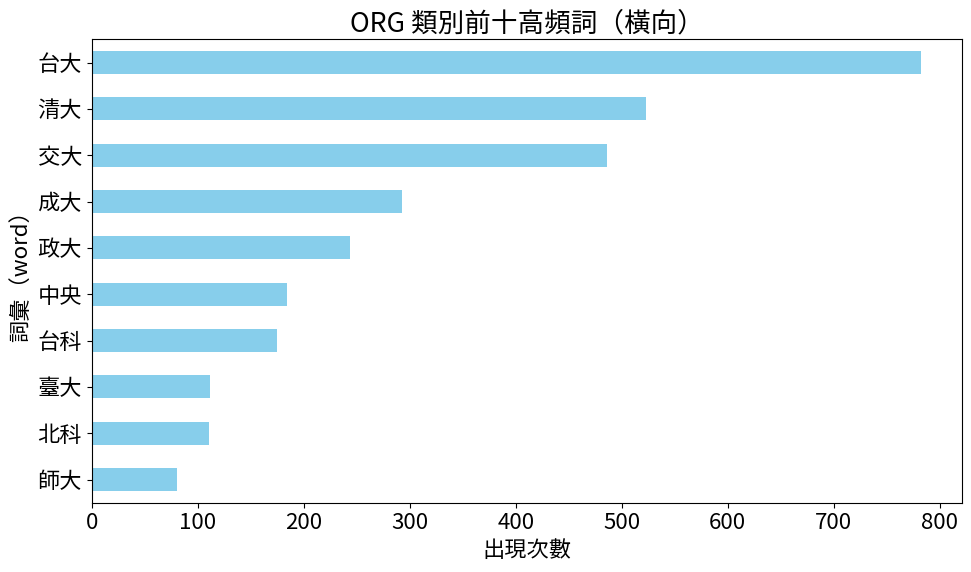

In [ ]:
import matplotlib.pyplot as plt

# ÂèñÂæó ORG È°ûÂà•‰∏≠Âá∫ÁèæÈ†ªÁéáÂâç 10 ÁöÑË©û
top_org_words = (
    entities_df[entities_df['ner'] == 'ORG']['word']
    .value_counts()
    .head(10)
)

# Áï´Âá∫Ê©´ÂêëÈï∑Ê¢ùÂúñ
plt.figure(figsize=(10, 6))
top_org_words.plot(kind='barh', color='skyblue')

plt.title("ORG È°ûÂà•ÂâçÂçÅÈ´òÈ†ªË©ûÔºàÊ©´ÂêëÔºâ")
plt.xlabel("Âá∫ÁèæÊ¨°Êï∏")
plt.ylabel("Ë©ûÂΩôÔºàwordÔºâ")
plt.gca().invert_yaxis()  # ËÆìÊúÄÂ§öÁöÑÊéíÂú®ÊúÄ‰∏äÈù¢
plt.tight_layout()
plt.show()

Âè∞Â§ß„ÄÅÊ∏ÖÂ§ß„ÄÅ‰∫§Â§ß„ÄÅÊàêÂ§ß„ÄÅÊîøÂ§ßÁÇ∫ÊúÄÂ∏∏Ë¢´ÊèêÂà∞ÁöÑ‰∫îÊâÄÂ≠∏Ê†°ÔºåÈÄô‰∫îÊâÄÂ≠∏Ê†°ÁÇ∫Âè∞ÁÅ£ÁöÑÈ†ÇÂ§ßÔºåÁÇ∫ËÄÉÁ†îÂ≠∏ÁîüÁöÑÈ¶ñË¶ÅÁõÆÊ®ô„ÄÇ<br>
ËÄåÂè∞Â§ßÊòéÈ°ØÊúÄÈ´òÔºåÈ°ØÁ§∫Âú®Á†îÁ©∂ÊâÄÁõ∏ÈóúË®éË´ñ‰∏≠ÔºåÂè∞Â§ßÊòØÊúÄÂÖ∑ÊåáÊ®ôÊÄß„ÄÅ‰πüÊúÄÂèóÁî≥Ë´ãËÄÖÈóúÊ≥®ÁöÑÂ≠∏Ê†°„ÄÇ„ÄÇ

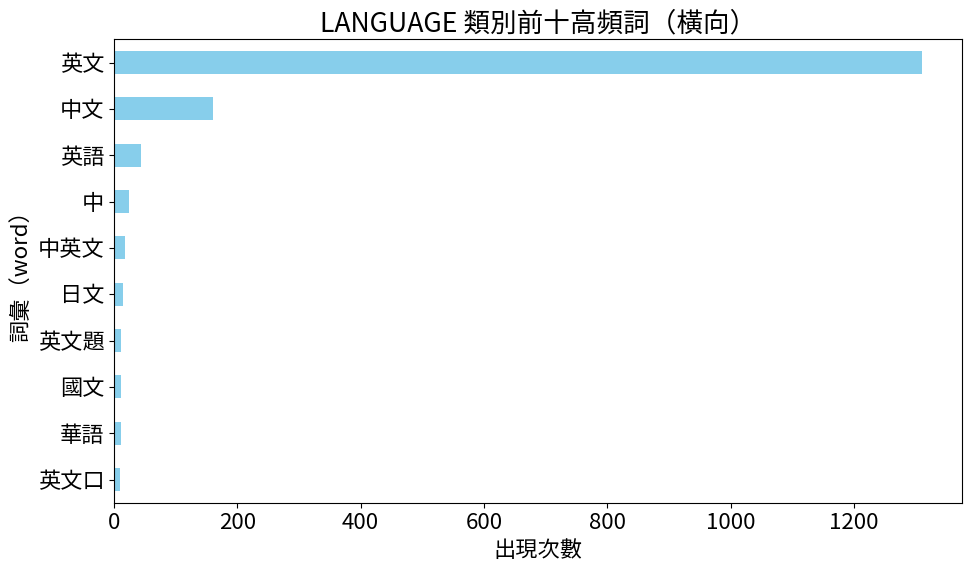

In [ ]:
import matplotlib.pyplot as plt

# ÂèñÂæó ORG È°ûÂà•‰∏≠Âá∫ÁèæÈ†ªÁéáÂâç 10 ÁöÑË©û
top_per_words = (
    entities_df[entities_df['ner'] == 'LANGUAGE']['word']
    .value_counts()
    .head(10)
)

# Áï´Âá∫Ê©´ÂêëÈï∑Ê¢ùÂúñ
plt.figure(figsize=(10, 6))
top_per_words.plot(kind='barh', color='skyblue')

plt.title("LANGUAGE È°ûÂà•ÂâçÂçÅÈ´òÈ†ªË©ûÔºàÊ©´ÂêëÔºâ")
plt.xlabel("Âá∫ÁèæÊ¨°Êï∏")
plt.ylabel("Ë©ûÂΩôÔºàwordÔºâ")
plt.gca().invert_yaxis()  # ËÆìÊúÄÂ§öÁöÑÊéíÂú®ÊúÄ‰∏äÈù¢
plt.tight_layout()
plt.show()

„ÄåËã±Êñá„ÄçÂ£ìÂÄíÊÄßÊúÄÈ´òÔºåË°®Á§∫Ëã±ÊñáÂú®Á†îÁ©∂ÊâÄÁî≥Ë´ã‰∏≠ÊòØÊ•µÂÖ∂ÈáçË¶ÅÁöÑÂõ†Á¥†ÔºåÂ∏∏Ë¶ãÂÖßÂÆπÂèØËÉΩÂåÖÊã¨ÔºöËã±ÊñáÈù¢Ë©¶„ÄÅËã±ÊñáÊàêÁ∏æÈñÄÊ™ª„ÄÅËã±ÊñáË´ñÊñáÁ≠â„ÄÇ

## 4. Sentiment Classification

‰ΩøÁî® Huggingface ‰∏äÈù¢Â∑≤Á∂ìÈáùÂ∞ç Sentiment classification ‰ªªÂãô finetune ÁöÑ BERT Ê®°Âûã‰æÜÂØ¶‰Ωú<br>
‰ΩøÁî®ÁöÑÊ®°ÂûãÔºöhttps://huggingface.co/techthiyanes/chinese_sentiment<br><br>
ÊÉÖÁ∑í(start 1Âà∞star 5)Ôºö<br>
1. Semi-negation<br>
2. Negation<br>
3. Neutral<br>
4. Semi-positive<br>
5. Positive

In [ ]:
# ËºâÂÖ•Â∑≤Á∂ìË¢´ fine-tune ÈÅéÁöÑ BERT Ê®°Âûã
model_name = "techthiyanes/chinese_sentiment"  # ‰Ω†ÂèØ‰ª•Â∞áÈÄôË£°ÊèõÊàê‰Ω†ÊÉ≥Ë¶Å‰ΩøÁî®ÁöÑÊ®°Âûã
model = pipeline('sentiment-analysis', model=model_name, truncation=True, max_length=512)

Device set to use cuda:0


In [ ]:
# Âª∫Á´ã‰∏ÄÂÄãÊñ∞ÁöÑ dataframe ‰æÜÂÑ≤Â≠òÁµêÊûú
results_df = pd.DataFrame(columns=['artUrl','artDate','sentence', 'label', 'score'])
results_df['sentence'] = metaData['sentence']
results_df['artUrl'] = metaData['artUrl']
results_df['artDate'] = metaData['artDate']

# ÂÆöÁæ©‰∏ÄÂÄãÂáΩÊï∏‰æÜÈÄ≤Ë°åÊÉÖÁ∑íÂàÜÊûê
def analyze_sentiment(sentence):
    result = model([sentence])
    return pd.Series([result[0]['label'], result[0]['score']])

# ‰ΩøÁî® apply ÂáΩÊï∏‰æÜÈÄ≤Ë°åÊÉÖÁ∑íÂàÜÊûê
results_df[['label', 'score']] = metaData['sentence'].apply(analyze_sentiment)

# Ëº∏Âá∫ÁµêÊûú
results_df.head(10)

artUrl              artDate  \
0  https://www.dcard.tw/f/graduate_school/p/25808...  2025-02-24 08:40:25   
1  https://www.dcard.tw/f/graduate_school/p/25808...  2025-02-24 08:40:25   
2  https://www.dcard.tw/f/graduate_school/p/25808...  2025-02-24 14:02:47   
3  https://www.dcard.tw/f/graduate_school/p/25808...  2025-02-24 14:02:47   
4  https://www.dcard.tw/f/graduate_school/p/25808...  2025-02-24 14:02:47   
5  https://www.dcard.tw/f/graduate_school/p/25809...  2025-02-24 15:16:58   
6  https://www.dcard.tw/f/graduate_school/p/25809...  2025-02-24 15:16:58   
7  https://www.dcard.tw/f/graduate_school/p/25809...  2025-02-24 15:16:58   
8  https://www.dcard.tw/f/graduate_school/p/25809...  2025-02-24 15:18:54   
9  https://www.dcard.tw/f/graduate_school/p/25809...  2025-02-24 15:18:54   

                                        sentence   label     score  
0                   ÊàëÊòØÁ¢©Â£´Êé®ÂæµÂÖ•Ê†°ÁöÑÂ≠∏ÁîüÊÉ≥Âïè‰∏Ä‰∏ãÂì™‰ΩçËÄÅÂ∏´ÊØîËºÉÂ∏∏Êé•Ê•≠ÁïåÁöÑÊ°àÂ≠ê  star 4  0.611464  
1                         ÊàñÊòØÊØîËºÉÂ∏∏ÊúâÁ†îË®éÊúÉÁ≠âÁ≠âÂÜçÈ∫ªÁÖ©ÂêÑ‰ΩçÂêåÂ≠∏ÂõûË¶ÜË¨ùË¨ù  star 4  0.316631  
2     Âπ¥Â∑≤Á∂ìÂçîÂä©ÂæàÂ§ö‰ΩçÊé®ÁîÑËÄÉÁîü‰∏äÂ≤∏ÊúâÈúÄË¶ÅÂÇôÂØ©Ë£Ω‰ΩúÁ≤æ‰øÆÊàñÊòØÂ∞çÂÜç‰æÜÊé®ÁîÑË∑üÈù¢Ë©¶ÊúâÁñëÂïèÈÉΩÂèØ‰ª•ÁßÅË®äÊàë  star 5  0.360496  
3                                 Êì¨Êé®Ëñ¶‰ø°‰πüÊ≤íÂïèÈ°åÊ≠°ËøéÊâæÊàëËÅäËÅä  star 4  0.391280  
4                                          ËÅäËÅä‰∏çÁî®Èå¢  star 2  0.304500  
5              ÁèæÂú®Â∞èÂ¶πÂ∞±ËÆÄ‰∏äÈù¢ÈÄôÈñìË≥áÂ∑•ÁèæÂú®Â§ß‰∫åË´ãÂïèË∂¥Êï∏ÊúâÊ©üÊúÉÊé®ÁîÑÂóéÂèØ‰ª•Êé®Âà∞Âì™Ë£°Âë¢  star 4  0.537423  
6                          ‰∏çÊòØÂæàÊÉ≥ËÄÉË©¶ÈÇÑÊúâÈô§‰∫ÜÂ∞àÈ°åÂ§öÁõäÈÇÑË¶ÅÊ∫ñÂÇô‰ªÄÈ∫ºÂë¢  star 4  0.477456  
7                                    ÈÇÑÊòØÁõ¥Êé•ÂéªËÄÉË©¶ÂìàÂìàÂìàÂìà  star 4  0.512078  
8                                             Â¶ÇÈ°å  star 4  0.537705  
9  Êú¨‰∫∫ÁÇ∫Á§æÂ∑•Â∏´ÊúâÊÑèÈ°òÂ∞±ËÆÄ‰∏≠Ê≠£ÁäØÁΩ™Èò≤Ê≤ªÁ†îÁ©∂ÊâÄÂú®ËÅ∑Â∞àÁè≠ÊòØÂê¶ÊúâÂ≠∏Èï∑ÂßêËÉΩÂ§†ÂàÜ‰∫´ËÆÄ‰∏≠Ê≠£ÁäØÈò≤Á¢©Â∞àÁè≠ÁöÑÊÑüÊÉ≥  star 4  0.640964

ÂÑ≤Â≠òÁµêÊûú

In [ ]:
# results_df.to_pickle('sentiment_results.pkl')

ËÆÄÂèñÁµêÊûú

In [ ]:
results_df = pd.read_pickle('sentiment_results.pkl')

In [ ]:
results_df['label'].describe()

count      90802
unique         5
top       star 4
freq       55727
Name: label, dtype: object

In [ ]:
star1_df = results_df[results_df['label'] == 'star 2']
star1_df

artUrl              artDate  \
4      https://www.dcard.tw/f/graduate_school/p/25808...  2025-02-24 14:02:47   
16     https://www.dcard.tw/f/graduate_school/p/25808...  2025-02-24 14:05:39   
71     https://www.dcard.tw/f/graduate_school/p/25808...  2025-02-24 14:05:39   
74     https://www.dcard.tw/f/graduate_school/p/25808...  2025-02-24 14:05:39   
111    https://www.dcard.tw/f/graduate_school/p/25808...  2025-02-24 10:31:06   
...                                                  ...                  ...   
90641  https://www.dcard.tw/f/graduate_school/p/25770...  2025-01-08 15:15:01   
90661  https://www.dcard.tw/f/graduate_school/p/25769...  2025-01-06 16:00:59   
90728  https://www.dcard.tw/f/graduate_school/p/25769...  2025-01-07 04:54:04   
90752  https://www.dcard.tw/f/graduate_school/p/25773...  2025-01-11 10:06:24   
90754  https://www.dcard.tw/f/graduate_school/p/25771...  2025-01-09 15:01:59   

                                              sentence   label     score  
4                                                ËÅäËÅä‰∏çÁî®Èå¢  star 2  0.304500  
16                              ÂÖàÊîæÁµêË´ñÂè™ÊîæÊúâÈåÑÂèñÂÇôÂèñÁöÑËá∫Â§ßÁîüÈÜ´ÈõªÂ≠êÂÇôÂèñÊ≤í‰∏ä  star 2  0.358910  
71                                        ÂçªË∑ü‰Ω†ÂÄë‰∏ÄÊ®£ÁÑ°ËÉΩÁÇ∫ÂäõÂÜçËÄÖ  star 2  0.261750  
74                                              ÁµïÂ∞çËôïÊñºÂä£Âã¢  star 2  0.331255  
111                                              ÁÑ°Áõ∏Èóú‰øÆË™≤  star 2  0.381028  
...                                                ...     ...       ...  
90641                                    ÁúãËµ∑‰æÜÂ∞±Ë∑üÈÅ∏Âè¶‰∏ÄÂçä‰∏ÄÊ®£Ë¨πÊÖé  star 2  0.383702  
90661                      Ë´ãÂïèÊòØÁõ¥Êé•Ëµ∞ÈÄ≤ÂéªË™™ÊÉ≥‰∫ÜËß£ËÄÉÊüêÊüêÁ†îÁ©∂ÊâÄÁöÑË™≤Á®ãÈÄôÊ®£Â∞±Â•Ω‰∫ÜÂóé  star 2  0.371010  
90728                                          ÊúâÂèØËÉΩÊîæÊ£ÑÁöÑÂë¢  star 2  0.358553  
90752                                            ÈÇÑÊòØÁï´ËôéÁàõ  star 2  0.430856  
90754  ÊàëÂ∑Æ‰∏ÄÈªûÈªûÂ∞±ÂèØ‰ª•ÂÇôÂèñÂà∞‰∫ÜÂèØÊòØÁ≠â‰∫ÜÂ•ΩÂπæÂÄãÁ¶ÆÊãúÈÉΩÊ≤íÊúâÂãïÈùúÊà™Ê≠¢ÊôÇÈñì‰πüÂø´Âà∞‰∫ÜÊâÄ‰ª•ÊÉ≥Áü•ÈÅìÈÇÑÊúÉ‰∏çÊúÉÊúâ‰∫∫ÊîæÊ£Ñ  star 2  0.396466  

[4879 rows x 5 columns]

### ‰ª•ÊñáÁ´†ÁÇ∫ÂñÆ‰ΩçË®àÁÆóÊÉÖÁ∑íÊ≠£Èù¢ÊàñË≤†Èù¢

In [ ]:
sentiment_count_by_article = pd.DataFrame(
    results_df.groupby(["artUrl","artDate", "label"]).size()
).reset_index()
sentiment_count_by_article = sentiment_count_by_article.rename(columns={0: "size"})
sentiment_count_by_article.head(10)

artUrl              artDate  \
0  https://www.dcard.tw/f/graduate_school/p/25764...  2025-01-01 02:00:58   
1  https://www.dcard.tw/f/graduate_school/p/25764...  2025-01-01 02:00:58   
2  https://www.dcard.tw/f/graduate_school/p/25764...  2025-01-01 03:43:07   
3  https://www.dcard.tw/f/graduate_school/p/25764...  2025-01-01 04:02:35   
4  https://www.dcard.tw/f/graduate_school/p/25764...  2025-01-01 04:02:35   
5  https://www.dcard.tw/f/graduate_school/p/25764...  2025-01-01 04:02:35   
6  https://www.dcard.tw/f/graduate_school/p/25764...  2025-01-01 04:02:35   
7  https://www.dcard.tw/f/graduate_school/p/25764...  2025-01-01 04:16:16   
8  https://www.dcard.tw/f/graduate_school/p/25764...  2025-01-01 04:16:16   
9  https://www.dcard.tw/f/graduate_school/p/25764...  2025-01-01 04:46:26   

    label  size  
0  star 4     8  
1  star 5     1  
2  star 5     3  
3  star 1     1  
4  star 3     5  
5  star 4     3  
6  star 5     2  
7  star 4     4  
8  star 5     2  
9  star 1     1

In [ ]:
sentiment_count_by_article

artUrl              artDate  \
0      https://www.dcard.tw/f/graduate_school/p/25764...  2025-01-01 02:00:58   
1      https://www.dcard.tw/f/graduate_school/p/25764...  2025-01-01 02:00:58   
2      https://www.dcard.tw/f/graduate_school/p/25764...  2025-01-01 03:43:07   
3      https://www.dcard.tw/f/graduate_school/p/25764...  2025-01-01 04:02:35   
4      https://www.dcard.tw/f/graduate_school/p/25764...  2025-01-01 04:02:35   
...                                                  ...                  ...   
11568  https://www.dcard.tw/f/graduate_school/p/25868...  2025-04-29 17:41:49   
11569  https://www.dcard.tw/f/graduate_school/p/25868...  2025-04-29 17:41:49   
11570  https://www.dcard.tw/f/graduate_school/p/25868...  2025-04-29 17:41:49   
11571  https://www.dcard.tw/f/graduate_school/p/25868...  2025-04-29 18:32:57   
11572  https://www.dcard.tw/f/graduate_school/p/25868...  2025-04-29 18:32:57   

        label  size  
0      star 4     8  
1      star 5     1  
2      star 5     3  
3      star 1     1  
4      star 3     5  
...       ...   ...  
11568  star 2     2  
11569  star 3     1  
11570  star 4     3  
11571  star 3     1  
11572  star 4     4  

[11573 rows x 4 columns]

Ë®àÁÆóÊñáÁ´†Êï¥È´îÂÅèÊ≠£Èù¢ÊàñË≤†Èù¢

In [ ]:
sentiment_df = sentiment_count_by_article.copy()

# Ëß£Êûê star Êï∏Â≠ó
sentiment_df['star_rating'] = sentiment_df['label'].str.extract(r'star (\d)').astype(int)

# ÂÆöÁæ©ÊÉÖÁ∑íÂàÜÈ°ûË¶èÂâá
def map_sentiment(star):
    if star in [4, 5]:
        return 'positive'
    elif star in [1, 2]:
        return 'negative'
    else:
        return 'neutral'

# Êñ∞Â¢û sentiment Ê¨Ñ‰Ωç
sentiment_df['sentiment'] = sentiment_df['star_rating'].apply(map_sentiment)

# ‰æùÁÖß artUrl Âíå sentiment Âä†Á∏ΩÁïôË®ÄÊï∏ÔºàsizeÔºâ
sentiment_summary = sentiment_df.groupby(['artUrl','artDate', 'sentiment'])['size'].sum().unstack(fill_value=0)

# Á¢∫‰øùÊâÄÊúâÊÉÖÁ∑íÊ¨Ñ‰ΩçÈÉΩÂ≠òÂú®ÔºàËã•Áº∫ÊºèÂâáË£úÈõ∂Ôºâ
for label in ['positive', 'neutral', 'negative']:
    if label not in sentiment_summary.columns:
        sentiment_summary[label] = 0

# Âà§Êñ∑Êï¥È´îÊÉÖÁ∑íÂÇæÂêë
def determine_sentiment(row):
    if row['positive'] > row['negative']:
        return 'Positive'
    elif row['negative'] > row['positive']:
        return 'Negative'
    else:
        return 'Neutral'

# Êñ∞Â¢û overall_sentiment Ê¨Ñ‰Ωç
sentiment_summary['overall_sentiment'] = sentiment_summary.apply(determine_sentiment, axis=1)

# ÈáçË®≠Á¥¢ÂºïÔºåartUrl ËÆäÁÇ∫Ê¨Ñ‰Ωç
sentiment_summary = sentiment_summary.reset_index()

# È°ØÁ§∫ÁµêÊûúÔºàÂèØË¶ñÂåñÁî®Ôºâ
sentiment_summary


sentiment                                             artUrl  \
0          https://www.dcard.tw/f/graduate_school/p/25764...   
1          https://www.dcard.tw/f/graduate_school/p/25764...   
2          https://www.dcard.tw/f/graduate_school/p/25764...   
3          https://www.dcard.tw/f/graduate_school/p/25764...   
4          https://www.dcard.tw/f/graduate_school/p/25764...   
...                                                      ...   
4257       https://www.dcard.tw/f/graduate_school/p/25868...   
4258       https://www.dcard.tw/f/graduate_school/p/25868...   
4259       https://www.dcard.tw/f/graduate_school/p/25868...   
4260       https://www.dcard.tw/f/graduate_school/p/25868...   
4261       https://www.dcard.tw/f/graduate_school/p/25868...   

sentiment              artDate  negative  neutral  positive overall_sentiment  
0          2025-01-01 02:00:58         0        0         9          Positive  
1          2025-01-01 03:43:07         0        0         3          Positive  
2          2025-01-01 04:02:35         1        5         5          Positive  
3          2025-01-01 04:16:16         0        0         6          Positive  
4          2025-01-01 04:46:26         1        6        13          Positive  
...                        ...       ...      ...       ...               ...  
4257       2025-04-29 15:14:10        18       30        95          Positive  
4258       2025-04-29 16:11:20         3        0        10          Positive  
4259       2025-04-29 16:41:54         2        1         5          Positive  
4260       2025-04-29 17:41:49         3        1         3           Neutral  
4261       2025-04-29 18:32:57         0        1         4          Positive  

[4262 rows x 6 columns]

In [ ]:
sentiment_summary['overall_sentiment'].describe()

count         4262
unique           3
top       Positive
freq          3749
Name: overall_sentiment, dtype: object

Ë®àÁÆó‰∏ÄÂ§©‰πã‰∏≠ÊúâÂ§öÂ∞ëÊ≠£Èù¢ÊàñË≤†Èù¢ÊñáÁ´†

In [ ]:
import pandas as pd

# ËΩâÊèõ artDate ÁÇ∫ datetime Ê†ºÂºèÔºå‰∏¶Âè™‰øùÁïôÊó•ÊúüÔºàÂéªÈô§ÊôÇÈñìÔºâ
sentiment_summary['artDate'] = pd.to_datetime(sentiment_summary['artDate']).dt.date

# Â∞á overall_sentiment Êò†Â∞ÑÁÇ∫‰∏≠ÊñáÂàÜÈ°û
sentiment_summary['sentiment_class'] = sentiment_summary['overall_sentiment'].map({
    'Positive': 'Ê≠£Âêë',
    'Negative': 'Ë≤†Âêë'
})

# ÈÅéÊøæÊéâ Neutral ÊàñÁ©∫ÂÄº
filtered_df = sentiment_summary.dropna(subset=['sentiment_class'])

# ÊØèÂ§©ÂêÑÊÉÖÁ∑íÈ°ûÂà•ÁöÑÊñáÁ´†Êï∏Ôºà‰ª•Â§©ÁÇ∫ÂñÆ‰ΩçÔºâ
daily_sentiment = (
    filtered_df
    .groupby(['artDate', 'sentiment_class'])['artUrl']
    .count()
    .reset_index(name='size')
)

# È°ØÁ§∫ÁµêÊûú
daily_sentiment


artDate sentiment_class  size
0    2025-01-01              Ê≠£Âêë    25
1    2025-01-02              Ê≠£Âêë    26
2    2025-01-02              Ë≤†Âêë     1
3    2025-01-03              Ê≠£Âêë    25
4    2025-01-03              Ë≤†Âêë     2
..          ...             ...   ...
182  2025-04-27              Ê≠£Âêë    15
183  2025-04-28              Ê≠£Âêë    26
184  2025-04-28              Ë≤†Âêë     4
185  2025-04-29              Ê≠£Âêë    26
186  2025-04-29              Ë≤†Âêë     3

[187 rows x 3 columns]

ÁµêÊûúÂ¶Ç‰∏ã

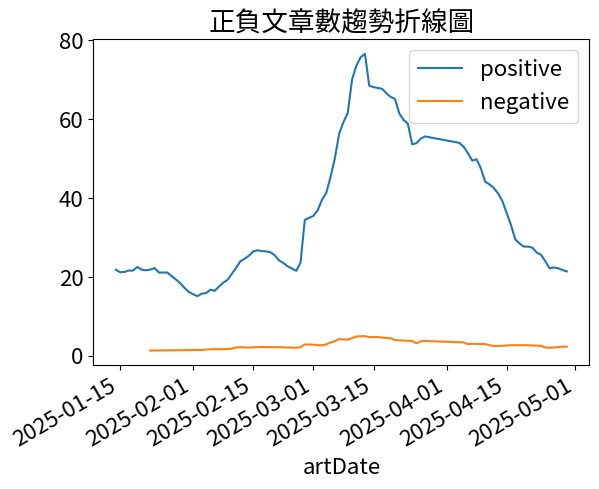

In [ ]:
colors = ["tab:blue", "tab:orange"]
pos = daily_sentiment[daily_sentiment["sentiment_class"] == "Ê≠£Âêë"]
neg = daily_sentiment[daily_sentiment["sentiment_class"] == "Ë≤†Âêë"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # ‰πüÂèØ‰ª•Âú®Ë©≤ÂúñË®≠ÂÆöÂèÉÊï∏
fig, ax = plt.subplots()

# ‰ΩøÁî® Series.rolling().mean() ‰æÜÁî¢Áîü 14 Â§©Âπ≥Âùá
rolling_days = 14
ax.plot(pos["artDate"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])
# ax.plot(pos["artDate"], pos['size'], color=colors[0])
# ax.plot(neg["artDate"], neg["size"], color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("Ê≠£Ë≤†ÊñáÁ´†Êï∏Ë∂®Âã¢ÊäòÁ∑öÂúñ")  # Ë®òÂæóÂä†‰∏äÊâçËÉΩÈ°ØÁ§∫‰∏≠Êñá
plt.show()

Âú®2ÊúàÂ∫ïÂø´ÈÄü‰∏äÂçáÔºåÊñº3Êúà‰∏≠Êó¨ÈÅîÂà∞È´òÂ≥∞„ÄÇ<br>
Á†îÁ©∂ÊâÄÁõ∏ÈóúË®éË´ñÂëàÁèæÈ´òÂ∫¶Ê≠£ÂêëÊÉÖÁ∑íÂÇæÂêëÔºåÂ∞§ÂÖ∂ÈõÜ‰∏≠ÊñºÊîæÊ¶úÈöéÊÆµ„ÄÇ<br>
‰∏âÊúà‰∏≠‰πãÂæåÂëàÁèæ‰∏ãÈôçË∂®Âã¢Ôºå4Êúà‰∏≠ÂæåÈÄêÊº∏ÂõûËêΩËá≥20~30ÁØá‰πãÈñì„ÄÇ

| Â≠∏Ê†°ÂêçÁ®±           | ÊîæÊ¶úÊôÇÈñì                                               |
|--------------------|--------------------------------------------------------|
| ÂúãÁ´ãÂè∞ÁÅ£Â§ßÂ≠∏       | Á¨¨‰∏ÄÊ¢ØÔºö114.03.05<br>Á¨¨‰∫åÊ¢ØÔºö114.03.19               |
| Âè∞ÁÅ£ËÅØÂêàÂ§ßÂ≠∏Á≥ªÁµ±   | ÂÖ¨ÂëäÔºö113.03.25                                        |
| ÂúãÁ´ãÂè∞ÁÅ£ÁßëÊäÄÂ§ßÂ≠∏   | ÂàùË©¶ÊîæÊ¶úÔºö114.02.19<br>Ë§áË©¶ÊîæÊ¶úÔºö114.03.19           |
| ÂúãÁ´ãÊ∏ÖËèØÂ§ßÂ≠∏       | ÂàùË©¶ÊîæÊ¶úÔºö114.03.03<br>Ë§áË©¶ÊîæÊ¶úÔºö114.03.21           |
| ÂúãÁ´ãÈôΩÊòé‰∫§ÈÄöÂ§ßÂ≠∏   | ÂàùË©¶ÊîæÊ¶úÔºö114.03.06<br>Ë§áË©¶ÊîæÊ¶úÔºö114.04.02           |
| ÂúãÁ´ãÊîøÊ≤ªÂ§ßÂ≠∏       | Á¨¨‰∏ÄÊ¢ØÔºö114.02.27<br>Á¨¨‰∫åÊ¢ØÔºö114.03.26               |
| ÂúãÁ´ãÊàêÂäüÂ§ßÂ≠∏       | Á¨¨‰∏ÄÊ¢ØÔºö114.02.27<br>Á¨¨‰∫åÊ¢ØÔºö114.03.28               |
| ÂúãÁ´ã‰∏≠Â±±Â§ßÂ≠∏       | ‰∏ÄÈöéÊÆµÔºö114.02.27<br>‰∫åÈöéÊÆµÔºö114.03.25               |
| ÂúãÁ´ã‰∏≠Â§ÆÂ§ßÂ≠∏       | ÂàùË©¶ÊîæÊ¶úÔºö114.02.27<br>Ë§áË©¶ÊîæÊ¶úÔºöÂêÑÁ≥ªÊâÄËá™Ë°åÂÖ¨Âëä       |
| ÂúãÁ´ã‰∏≠ËààÂ§ßÂ≠∏       | Á¨¨‰∏ÄÊ¢ØÔºö114.02.27<br>Á¨¨‰∫åÊ¢ØÔºö114.03.26               |
| ÂúãÁ´ã‰∏≠Ê≠£Â§ßÂ≠∏       | Á¨¨‰∏ÄÊ¢ØÔºö114.03.07<br>Á¨¨‰∫åÊ¢ØÔºö114.04.11               |

### ‰ª•POSÊñ∑Ë©ûÁµêÊûúÁπ™Ë£ΩÊ≠£Èù¢ÊñáÂ≠óÈõ≤

In [ ]:
cloud_pos_df = results_df.copy()
cloud_pos_df['sentence'] = ner_results['packed_sentence'].values

cloud_pos_df

artUrl              artDate  \
0      https://www.dcard.tw/f/graduate_school/p/25808...  2025-02-24 08:40:25   
1      https://www.dcard.tw/f/graduate_school/p/25808...  2025-02-24 08:40:25   
2      https://www.dcard.tw/f/graduate_school/p/25808...  2025-02-24 14:02:47   
3      https://www.dcard.tw/f/graduate_school/p/25808...  2025-02-24 14:02:47   
4      https://www.dcard.tw/f/graduate_school/p/25808...  2025-02-24 14:02:47   
...                                                  ...                  ...   
90797  https://www.dcard.tw/f/graduate_school/p/25771...  2025-01-10 01:17:10   
90798  https://www.dcard.tw/f/graduate_school/p/25771...  2025-01-10 01:17:10   
90799  https://www.dcard.tw/f/graduate_school/p/25771...  2025-01-10 01:17:10   
90800  https://www.dcard.tw/f/graduate_school/p/25771...  2025-01-10 01:17:10   
90801  https://www.dcard.tw/f/graduate_school/p/25771...  2025-01-09 23:35:39   

                                                sentence   label     score  
0      Êàë(Nh)„ÄÄÊòØ(SHI)„ÄÄÁ¢©Â£´(Na)„ÄÄÊé®Âæµ(VC)„ÄÄÂÖ•Ê†°(VA)„ÄÄÁöÑ(DE)„ÄÄÂ≠∏Áîü(Na)...  star 4  0.611464  
1      ÊàñÊòØ(Caa)„ÄÄÊØîËºÉ(Dfa)„ÄÄÂ∏∏(D)„ÄÄÊúâ(V_2)„ÄÄÁ†îË®éÊúÉ(Na)„ÄÄÁ≠âÁ≠â(Cab)„ÄÄÂÜç(...  star 4  0.316631  
2      Âπ¥(Na)„ÄÄÂ∑≤Á∂ì(D)„ÄÄÂçîÂä©(VC)„ÄÄÂæàÂ§ö(Neqa)„ÄÄ‰Ωç(Nf)„ÄÄÊé®ÁîÑ(Na)„ÄÄËÄÉÁîü(Na...  star 5  0.360496  
3      Êì¨(VF)„ÄÄÊé®Ëñ¶‰ø°(Na)„ÄÄ‰πü(D)„ÄÄÊ≤í(VJ)„ÄÄÂïèÈ°å(Na)„ÄÄÊ≠°Ëøé(VJ)„ÄÄÊâæ(VC)„ÄÄÊàë...  star 4  0.391280  
4                                ËÅäËÅä(VE)„ÄÄ‰∏ç(D)„ÄÄÁî®(VC)„ÄÄÈå¢(Na)  star 2  0.304500  
...                                                  ...     ...       ...  
90797     ÊúâÈªû(Dfa)„ÄÄË¢´(P)„ÄÄÂ≠∏Èï∑(Na)„ÄÄÂíå(Caa)„ÄÄÊïôÊéà(Na)„ÄÄË∏¢(VC)„ÄÄÁöÆÁêÉ(Na)  star 3  0.379757  
90798              ‰ΩÜ(Cbb)„ÄÄ‰ªñÂÄë(Nh)„ÄÄ‰∫∫(Na)„ÄÄÈÉΩ(D)„ÄÄÂæà(Dfa)„ÄÄÂ•Ω(VH)  star 3  0.295681  
90799  ÊúâÈªû(Dfa)„ÄÄ‰∏ç(D)„ÄÄÊ∏ÖÊ•ö(VH)„ÄÄ‰∏ÄËà¨(A)„ÄÄÁöÑ(DE)„ÄÄÂ∞àÈ°åÁîü(Na)„ÄÄÈÉΩ(D)„ÄÄÊúÉ...  star 3  0.425728  
90800                       Â•Ω(Dfa)„ÄÄ‰∏çÁü•ÊâÄÊé™(VH)„ÄÄË©≤(D)„ÄÄÊÄéÈ∫ºËæ¶(VH)  star 5  0.328607  
90801  Â¶ÇÊûú(Cbb)„ÄÄËÄÉË©¶(Na)„ÄÄÁï∂‰∏≠(Ng)„ÄÄÊ≤íÊúâ(VJ)„ÄÄÊî∂ÂÖ•(Na)„ÄÄÂêÑ‰Ωç(Nh)„ÄÄÈÉΩ(D...  star 4  0.583913  

[90802 rows x 5 columns]

In [ ]:
cloud_pos_df['sentence'].iloc[0]

'Êàë(Nh)\u3000ÊòØ(SHI)\u3000Á¢©Â£´(Na)\u3000Êé®Âæµ(VC)\u3000ÂÖ•Ê†°(VA)\u3000ÁöÑ(DE)\u3000Â≠∏Áîü(Na)\u3000ÊÉ≥(VE)\u3000Âïè(VE)\u3000‰∏Ä‰∏ã(Nd)\u3000Âì™(Nep)\u3000‰Ωç(Nf)\u3000ËÄÅÂ∏´(Na)\u3000ÊØîËºÉ(Dfa)\u3000Â∏∏(D)\u3000Êé•(VC)\u3000Ê•≠Áïå(Nc)\u3000ÁöÑ(DE)\u3000Ê°àÂ≠ê(Na)'

In [ ]:
import pandas as pd
import re

# Âª∫Á´ã‰∏ÄÂÄãÁµêÊûúÊ∏ÖÂñÆ
rows = []

# ÈÅçÊ≠∑ÊØè‰∏ÄÂàó
for _, row in cloud_pos_df.iterrows():
    base_data = row.drop('sentence')  # ‰øùÁïôÈô§‰∫Ü sentence ‰ª•Â§ñÁöÑÊ¨Ñ‰Ωç
    sentence = row['sentence']

    # ÂÆâÂÖ®Ê™¢Êü•‰∏¶Ë∑≥ÈÅéÈùûÂ≠ó‰∏≤ÂÖßÂÆπ
    if isinstance(sentence, str):
        # Â∞áË©ûËàáË©ûÊÄßÂ∞çÊãÜÂá∫‰æÜ
        tokens = re.findall(r"(.*?)\((.*?)\)", sentence)
        for word, pos in tokens:
            rows.append({
                **base_data,  # ‰øùÁïôÂéüÊ¨Ñ‰ΩçÔºàÂ¶Ç artUrl„ÄÅlabelÔºâ
                'word': word,
                'pos': pos
            })

# Âª∫Á´ãÂ±ïÈñãÂæåÁöÑ DataFrame
word_pos_df = pd.DataFrame(rows)


In [ ]:
word_pos_df

artUrl  \
0       https://www.dcard.tw/f/graduate_school/p/25808...   
1       https://www.dcard.tw/f/graduate_school/p/25808...   
2       https://www.dcard.tw/f/graduate_school/p/25808...   
3       https://www.dcard.tw/f/graduate_school/p/25808...   
4       https://www.dcard.tw/f/graduate_school/p/25808...   
...                                                   ...   
876943  https://www.dcard.tw/f/graduate_school/p/25771...   
876944  https://www.dcard.tw/f/graduate_school/p/25771...   
876945  https://www.dcard.tw/f/graduate_school/p/25771...   
876946  https://www.dcard.tw/f/graduate_school/p/25771...   
876947  https://www.dcard.tw/f/graduate_school/p/25771...   

                    artDate   label     score word  pos  
0       2025-02-24 08:40:25  star 4  0.611464    Êàë   Nh  
1       2025-02-24 08:40:25  star 4  0.611464   „ÄÄÊòØ  SHI  
2       2025-02-24 08:40:25  star 4  0.611464  „ÄÄÁ¢©Â£´   Na  
3       2025-02-24 08:40:25  star 4  0.611464  „ÄÄÊé®Âæµ   VC  
4       2025-02-24 08:40:25  star 4  0.611464  „ÄÄÂÖ•Ê†°   VA  
...                     ...     ...       ...  ...  ...  
876943  2025-01-09 23:35:39  star 4  0.583913  „ÄÄÂêÑ‰Ωç   Nh  
876944  2025-01-09 23:35:39  star 4  0.583913   „ÄÄÈÉΩ    D  
876945  2025-01-09 23:35:39  star 4  0.583913   „ÄÄÊòØ  SHI  
876946  2025-01-09 23:35:39  star 4  0.583913  „ÄÄÊÄéÈ∫º    D  
876947  2025-01-09 23:35:39  star 4  0.583913  „ÄÄÊ∏°ÈÅé  VCL  

[876948 rows x 6 columns]

In [ ]:
filtered_word_pos_df = word_pos_df[word_pos_df['word'].str.strip().str.len() >= 2]
filtered_word_pos_df

artUrl  \
2       https://www.dcard.tw/f/graduate_school/p/25808...   
3       https://www.dcard.tw/f/graduate_school/p/25808...   
4       https://www.dcard.tw/f/graduate_school/p/25808...   
6       https://www.dcard.tw/f/graduate_school/p/25808...   
9       https://www.dcard.tw/f/graduate_school/p/25808...   
...                                                   ...   
876941  https://www.dcard.tw/f/graduate_school/p/25771...   
876942  https://www.dcard.tw/f/graduate_school/p/25771...   
876943  https://www.dcard.tw/f/graduate_school/p/25771...   
876946  https://www.dcard.tw/f/graduate_school/p/25771...   
876947  https://www.dcard.tw/f/graduate_school/p/25771...   

                    artDate   label     score word  pos  
2       2025-02-24 08:40:25  star 4  0.611464  „ÄÄÁ¢©Â£´   Na  
3       2025-02-24 08:40:25  star 4  0.611464  „ÄÄÊé®Âæµ   VC  
4       2025-02-24 08:40:25  star 4  0.611464  „ÄÄÂÖ•Ê†°   VA  
6       2025-02-24 08:40:25  star 4  0.611464  „ÄÄÂ≠∏Áîü   Na  
9       2025-02-24 08:40:25  star 4  0.611464  „ÄÄ‰∏Ä‰∏ã   Nd  
...                     ...     ...       ...  ...  ...  
876941  2025-01-09 23:35:39  star 4  0.583913  „ÄÄÊ≤íÊúâ   VJ  
876942  2025-01-09 23:35:39  star 4  0.583913  „ÄÄÊî∂ÂÖ•   Na  
876943  2025-01-09 23:35:39  star 4  0.583913  „ÄÄÂêÑ‰Ωç   Nh  
876946  2025-01-09 23:35:39  star 4  0.583913  „ÄÄÊÄéÈ∫º    D  
876947  2025-01-09 23:35:39  star 4  0.583913  „ÄÄÊ∏°ÈÅé  VCL  

[464151 rows x 6 columns]

In [ ]:
# Á¢∫‰øù artDate ÊòØ datetime Ê†ºÂºè
filtered_word_pos_df['artDate'] = pd.to_datetime(filtered_word_pos_df['artDate'])

# ÁØ©ÈÅ∏ 2025 Âπ¥ 3 ÊúàÁöÑË≥áÊñô
march_2025_df = filtered_word_pos_df[
    (filtered_word_pos_df['artDate'].dt.year == 2025) &
    (filtered_word_pos_df['artDate'].dt.month == 3)
]

In [ ]:
march_2025_high_rating_df = march_2025_df[
    march_2025_df['label'].isin(['star 4', 'star 5'])
]

In [ ]:
# Ëá™ÂÆöÂÅúÁî®Â≠ó
with open('./dict/stopwords.txt') as f:
    stop_words = f.read().splitlines()

print(stop_words[:20])

['\ufeff,', '?', '„ÄÅ', '„ÄÇ', '‚Äú', '‚Äù', '„Ää', '„Äã', 'ÔºÅ', 'Ôºå', 'Ôºö', 'Ôºõ', 'Ôºü', '[', ']', '„Äå', '„Äç', '\\n', '\\u3000', ' ']


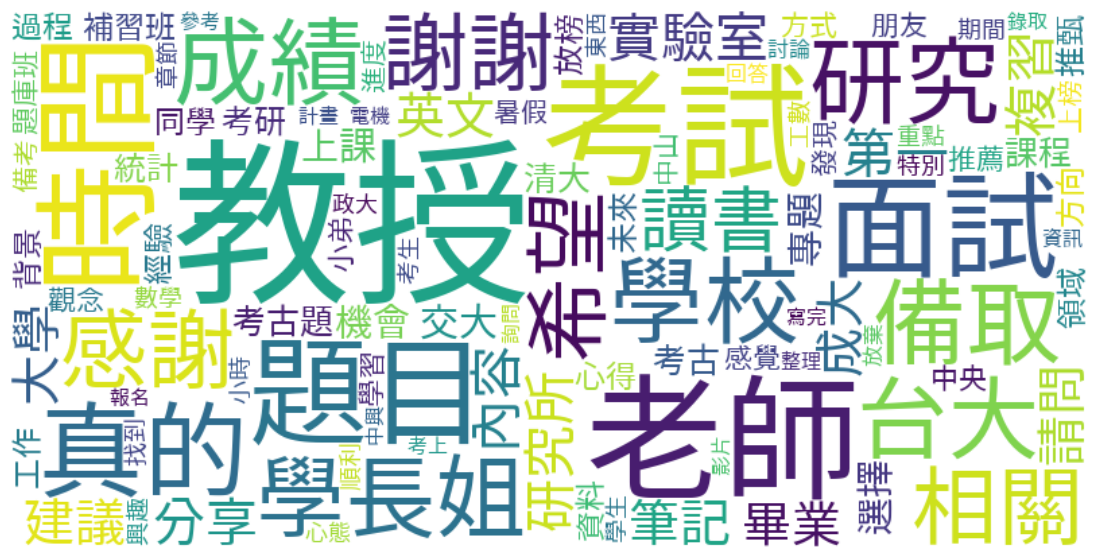

In [ ]:
# ÂåØÂÖ•Ëá™Ë®ÇÁöÑ stop words (È†êË®≠Âè™ÊúâËã±ÊñáÁöÑ)
stop_words_pos = stop_words
stop_words_pos = set(stop_words_pos)

# Ë®≠ÂÆö‰∏≠ÊñáÂ≠óÂΩ¢
font_path = 'TaipeiSansTCBeta-Regular.ttf'

# ÂèØ‰ª•Ë®≠ÂÆöÂ≠óÂûãÂ§ßÂ∞èÂíåËÉåÊôØÈ°èËâ≤
wordcloud = WordCloud(
                stopwords=stop_words_pos,
                collocations=False,
                font_path=font_path,
                width=800, 
                height = 400, 
                max_words=100, 
                background_color="white")

wordcloud.generate(' '.join(march_2025_high_rating_df['word']))
# Display the generated image:
plt.figure(figsize = (14,7))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()

ÊïôÊéà„ÄÅËÄÅÂ∏´„ÄÅÂ≠∏Èï∑ÂßêÔºöÈ°ØÁ§∫Âú®Ê≠£Èù¢ÊñáÁ´†‰∏≠ÔºåÁî≥Ë´ãËÄÖÂ∏∏Ë°®ÈÅîÂ∞çÊïôÂ≠∏‰∫∫Âì°ËàáÂ≠∏Èï∑ÂßêÁöÑÊÑüË¨ùÔºåÂèØËÉΩÊ∂âÂèäÊé®Ëñ¶‰ø°„ÄÅÊåáÂ∞é„ÄÅÁ∂ìÈ©óÂàÜ‰∫´Á≠â„ÄÇ<br>
ËÄÉË©¶„ÄÅÈù¢Ë©¶„ÄÅÈ°åÁõÆÔºöËàáÂçáÂ≠∏ÈÅéÁ®ã‰∏≠ÁöÑÊ∫ñÂÇôËàáÊµÅÁ®ãÂØÜÂàáÁõ∏ÈóúÔºåË™™ÊòéÊ≠£Èù¢ÊñáÁ´†Â§öËàá„ÄåÈÄöÈÅéËÄÉË©¶„ÄçÊàñ„ÄåÈ†ÜÂà©Èù¢Ë©¶„ÄçÊúâÈóú„ÄÇ

## 5. Text Clustering

In [ ]:
# metaData.to_pickle('metaData.pkl')

In [ ]:
metaData = pd.read_pickle('metaData.pkl')

In [ ]:
# Á¢∫‰øù artDate ÊòØ datetime Ê†ºÂºè
metaData['artDate'] = pd.to_datetime(metaData['artDate'])

# Ë®≠ÂÆöÊó•ÊúüÁØÑÂúç
start_date = pd.to_datetime("2025-03-01")
end_date = pd.to_datetime("2025-04-15")
filtered_df = metaData.dropna(subset=['sentence'])

# ÁØ©ÈÅ∏Ê¢ù‰ª∂ÔºöÊó•ÊúüÂú®ÁØÑÂúçÂÖßÔºå‰∏î artContent ÂêåÊôÇÂåÖÂê´„ÄåÊîæÊ¶ú„Äç„ÄåÈù¢Ë©¶„Äç„ÄåÂè£Ë©¶„Äç
filtered_df = metaData[
    (metaData['artDate'] >= start_date) &
    (metaData['artDate'] <= end_date) &
    (metaData['artContent'].str.contains("ÊîæÊ¶ú", na=False))
]

# ÂèñÂá∫ sentence Ê¨ÑÁÇ∫ listÔºåÊúÄÂ§ö 5000 Á≠Ü
docs_zh = filtered_df['sentence'].tolist()[:500]

# Ë®≠ÂÆöÁπÅÈ´î‰∏≠ÊñáË©ûÂ∫´
jieba.set_dictionary('./dict/dict.txt.big')
jieba.load_userdict('./dict/user_dict.txt')

# Êñ∞Â¢û stopwords
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopwords = [line.strip() for line in f.readlines()]

# Ë®≠ÂÆö‰∏≠Êñá embedding model
bert_sentence_model = SentenceTransformer("google-bert/bert-base-chinese")

# Â∞á‰∏≠ÊñáÊñáÁ´†ËΩâÊèõÁÇ∫ embedding
embeddings = bert_sentence_model.encode(docs_zh, show_progress_bar=True)

# ÂÆöÁæ©‰∏çÂêå clustering layer ÊâÄË¶Å‰ΩøÁî®ÁöÑÊ®°ÂûãËàáÊñπÊ≥ïÔºàÂ∞±Áî® default ÁöÑ HDBSCANÔºâ
hdbscan_model = HDBSCAN()

# ÂÆöÁæ©‰∏ÄÂÄãÈÅ©Âêà‰∏≠ÊñáÁöÑÂàÜË©ûÂáΩÊï∏
def tokenize_zh(text):
    words = jieba.lcut(text)
    filtered = [w for w in words if len(w) > 1]
    return filtered

# Âª∫Á´ã‰∏ÄÂÄã‰ΩøÁî® jieba ÂàÜË©ûÁöÑ CountVectorizer
jieba_vectorizer = CountVectorizer(tokenizer=tokenize_zh, stop_words=stopwords, analyzer='word', token_pattern=u"(?u)\\b\\w+\\b")

# ‰ΩøÁî® BERTopic ÈÄ≤Ë°å‰∏ªÈ°åÊ®°ÂûãÂª∫Á´ã
zh_topic_model = BERTopic(embedding_model=bert_sentence_model, vectorizer_model=jieba_vectorizer, verbose=True, top_n_words=30)
topics, probs = zh_topic_model.fit_transform(docs_zh, embeddings)

zh_topic_model.get_topic_info()

Building prefix dict from c:\Users\User\Desktop\VSCode_Workspace\Python\SM\SMA_2025S\week12\dict\dict.txt.big ...
Loading model from cache C:\Users\User\AppData\Local\Temp\jieba.ucf0dca050086923d0226dbed2978707f.cache
Loading model cost 0.647 seconds.
Prefix dict has been built successfully.
No sentence-transformers model found with name google-bert/bert-base-chinese. Creating a new one with mean pooling.


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

2025-05-07 20:03:46,296 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-07 20:03:46,921 - BERTopic - Dimensionality - Completed ‚úì
2025-05-07 20:03:46,922 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-07 20:03:46,932 - BERTopic - Cluster - Completed ‚úì
2025-05-07 20:03:46,934 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-07 20:03:46,979 - BERTopic - Representation - Completed ‚úì


Topic  Count             Name  \
0     -1    142  -1_ÊïôÊéà_È°åÁõÆ_ÂØ¶È©óÂÆ§_ÂàÜÊï∏   
1      0    148    0_ÊîæÊ¶ú_ÊïôÊéà_Âè∞Â§ß_ËÄÉË©¶   
2      1     78    1_Ë¨ùË¨ù_Ë≥áË®ä_ÂπæÊ¨°_ÊÉ≥Âà∞   
3      2     70    2_ËÄÅÂ∏´_ÊôÇÈñì_Êù±Ë•ø_Âè™ËÉΩ   
4      3     35    3_ÂàÜ‰∫´_Ë´ãÂïè_Â≠∏Èï∑_Á∂ìÈ©ó   
5      4     14  4_ËÆÄÂçö_Êò•Â≠£Áè≠_Êï∏Â≠∏Á≥ª_Â≤©Â£Å   
6      5     13  5_‰∏ãÊâã_ÊñáÁ≠Ü_ÊúâÂßãÊúâÁµÇ_ÊúÉ‰æÜ   

                                      Representation  \
0  [ÊïôÊéà, È°åÁõÆ, ÂØ¶È©óÂÆ§, ÂàÜÊï∏, ÊàêÁ∏æ, ÊåáËÄÉ, ËÄÅÂ∏´, Áõ∏Èóú, Â∏åÊúõ, ËÄÉË©¶, È°åÂ∫´, ...   
1  [ÊîæÊ¶ú, ÊïôÊéà, Âè∞Â§ß, ËÄÉË©¶, Ê≠£Âèñ, Â∞èÂºü, Á†îÁ©∂ÊâÄ, Â≠∏Ê†°, ÊàêÁ∏æ, ÂØ¶È©óÂÆ§, Èù¢Ë©¶,...   
2  [Ë¨ùË¨ù, Ë≥áË®ä, ÂπæÊ¨°, ÊÉ≥Âà∞, ÁîüÊ¥ª, È°ûÊØî, ÊâæÂà∞, ‰∏≠Â§Æ, ÊÑüË¨ù, ÁÑ¶ÊÖÆ, ÁúüÁöÑ, ÁãÄ...   
3  [ËÄÅÂ∏´, ÊôÇÈñì, Êù±Ë•ø, Âè™ËÉΩ, ËÉΩÂäõ, Ëã±Êñá, Ë´ñÊñá, ‰∫∫Áîü, Ë≥áÂ∑•Á¢©, ÊÑüË¶∫, ÁôºÁèæ, ...   
4  [ÂàÜ‰∫´, Ë´ãÂïè, Â≠∏Èï∑, Á∂ìÈ©ó, Â∏åÊúõ, ÊÑèË¶ã, ‰∏ÄÁØá, ÁúãÊ≥ï, ÂßêÂÄë, Â§ßÁ•û, ÊÉ≥Âïè, ÂøÉ...   
5  [ËÆÄÂçö, Êò•Â≠£Áè≠, Êï∏Â≠∏Á≥ª, Â≤©Â£Å, Êúâ‰øÆ, Êõ∏Âç∑, ‰∫ãÂæå, ÊîæÈ£õ, ÊèíÁè≠, ËºîÁ≥ª, Â∞±ÊúÉ,...   
6  [‰∏ãÊâã, ÊñáÁ≠Ü, ÊúâÂßãÊúâÁµÇ, ÊúÉ‰æÜ, ÊúÄÊÉ≥, ÂØ¶Âú®, ÂïèÈÅé, ÊµÅÊö¢, ÂãïÊ©ü, Ë§áÊü•, Ë¨õ‰∏çÂá∫...   

                                 Representative_Docs  
0  [‰πüÈ†Ü‰æø‰ªãÁ¥πÊú¨Á≥ªÊ®°Êì¨ÂØ¶È©óÂÆ§ÂÖ©‰ΩçÊïôÊéàÂëÇÂæ∑ËÄÅÂ∏´ËÄÅÂ∏´ÊòØÂæ∑Âúã‰∫∫, ÂØíÂÅá‰ºëÊÅØ‰∏ÄÈÄ±ÂæåÊàëÂ∞±ÈñãÂßãÊ∫ñÂÇôËÄÉË©¶‰ø°Ëôü...  
1  [ÁõÆÂâçËÄÉË©¶ÁöÑÂ§ßÈÉ®ÂàÜÂ≠∏Ê†°ÈÉΩÊîæÊ¶ú‰∫ÜÂ∏åÊúõÂ§ßÂÆ∂ÈÉΩÊúâ‰∏äÂøÉÂÑÄÁöÑÂ≠∏Ê†°ÊÉ≥Âïè‰∏Ä‰∏ãÁâà‰∏äÁöÑÂêÑ‰ΩçÂ§ßÁ•ûÊúÉÊÄéÈ∫ºÈÅ∏ÊìáÂë¢Â∞èÂºü...  
2                                 [Ë¨ùË¨ùÂ§ßÂÆ∂, Ë¨ùË¨ù, Ë¨ùË¨ùÂêÑ‰ΩçÁúãÂÆå]  
3  [Âà∞‰∫ÜÁ¨¨‰∏âÂπ¥ÊàëÈñãÂßãÂØ´Ë´ñÊñáÊØèÈÄ±ÈÉΩÂú®ÊîπÊïôÊéàÊ∞∏ÈÅ†ÈÉΩ‰∏çÊªøÊÑèÊàëÊÑüË¶∫Ëá™Â∑±Â∞±ÊòØÂú®ÊâìÈõúÁöÑÂØ´ÂÄãË´ñÊñáÊØõ‰∏ÄÂ†ÜÂêåÂ≠∏Ë∑ü...  
4     [Â∏åÊúõÊúâÂ≠∏Èï∑ÂßêÂèØ‰ª•‰æÜÂàÜ‰∫´‰∏Ä‰∏ã, Âõ†Ê≠§Ê±∫ÂÆöÂú®Ê≠§‰πüÂàÜ‰∫´Ëá™Ë∫´ÁöÑÁ∂ìÈ©ó, Â∏åÊúõÊúâÂ≠∏Èï∑ÂßêÂÄëÂèØ‰ª•ÂàÜ‰∫´‰∏Ä‰∏ã]  
5                       [ÁëûÂÖ∏ËÆÄÂçö, ÁæéÂúãËÆÄÂçö, ÊâÄ‰ª•Ê±∫ÂÆöÊπäÂÄãÊï∏Â≠∏Á≥ªÁöÑ‰∫ãÂæåËºîÁ≥ª]  
6  [Âõ†ÁÇ∫ÊàëÊØîËºÉÊÉ≥ÂéªÈõª‰ø°‰πôÊâÄ‰ª•ËÄÅÂØ¶Ë™™Ë¨õ‰∏çÂá∫‰ªÄÈ∫ºÂãïÊ©ü, ‰∏ÄÈñãÂßã‰∏çÁü•ÈÅìÊÄéÈ∫º‰∏ãÊâãÊ≤íÈóú‰øÇ, ‰ΩÜÊàëÁôºÁèæË†ªÂ§ö...

In [ ]:
len(docs_zh)

500

In [ ]:
zh_topic_model.visualize_topics()

BERTopic Á∏ΩÂÖ±ÂàÜÂá∫ÂÖ≠ÂÄã‰∏ªÈ°åÔºåÂÉèÊòØÊúâÊîæÊ¶ú„ÄÅÊôÇÈñìÂ£ìÂäõ„ÄÅÁ∂ìÈ©óÂàÜ‰∫´Á≠â‰∏ªÈ°åÔºå‰∏ªÈ°å‰πãÈñìÈáçÁñäÊÄßËºÉÈ´ò

In [ ]:
# ‰º∞ÁÆóÊØèÂÄãÊñá‰ª∂Â∞çBERTopicÊØèÂÄã‰∏ªÈ°åÁöÑÊ©üÁéáÂàÜÂ∏É
topic_distr, _ = zh_topic_model.approximate_distribution(docs_zh)

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 13.78it/s]


In [ ]:
print(topic_distr[0])

[0.45320692 0.         0.         0.54679308 0.         0.        ]


In [ ]:
# ‰ª•Á¨¨18ÂÄãÊñá‰ª∂ÁÇ∫‰æãÔºåÂàóÂá∫ÈÄô‰ªΩÊñá‰ª∂Â∞çÊØèÂÄã‰∏ªÈ°åÁöÑÊ©üÁéáÂàÜÂ∏É
zh_topic_model.visualize_distribution(topic_distr[0])

In [ ]:
# ÂàóÂá∫‰∏ªÈ°åÁöÑ‰ª£Ë°®Ë©ûÂíåÂÖ∂Â∞çÊáâÁöÑÊ¨äÈáç
zh_topic_model.get_topic(0)

[('ÊîæÊ¶ú', 0.09496642532024784),
 ('ÊïôÊéà', 0.07977732860824287),
 ('Âè∞Â§ß', 0.04553749418387911),
 ('ËÄÉË©¶', 0.03502884167990701),
 ('Ê≠£Âèñ', 0.03463676928605411),
 ('Â∞èÂºü', 0.03375999130925248),
 ('Á†îÁ©∂ÊâÄ', 0.03375999130925248),
 ('Â≠∏Ê†°', 0.03259482103999241),
 ('ÊàêÁ∏æ', 0.032429112966322865),
 ('ÂØ¶È©óÂÆ§', 0.03028328966363851),
 ('Èù¢Ë©¶', 0.029294320464850598),
 ('ËÄÉÁ†î', 0.024446115779994306),
 ('Èù¢Ë´á', 0.024446115779994306),
 ('ÈÇÑÂú®', 0.023714446186871834),
 ('‰∏≠Ëàà', 0.023714446186871834),
 ('Â≠∏Èï∑', 0.023553669738385505),
 ('ÊÉ≥Âïè', 0.021795397585964767),
 ('‰∏≠Â±±', 0.021795397585964767),
 ('Êé®ÁîÑ', 0.019994776474492094),
 ('ÂÇôÂèñ', 0.019777988826522937),
 ('ÁôºÁèæ', 0.019777988826522937),
 ('ÊâìÁÆó', 0.018971556949497467),
 ('È†òÂüü', 0.018971556949497467),
 ('Ê©üÊúÉ', 0.01813837432880915),
 ('‰ø°Ëôü', 0.01813837432880915),
 ('Â∏åÊúõ', 0.017514420839953505),
 ('Â∞àÈ°å', 0.017436318068771814),
 ('È†êÊúü', 0.017436318068771814),
 ('ÁÑ¶ÊÖÆ', 0.01683022396

Êü•ÁúãÁâπÂÆöÊñáÁ´†ÁöÑ‰∏ªÈ°åÂàÜ‰Ωà

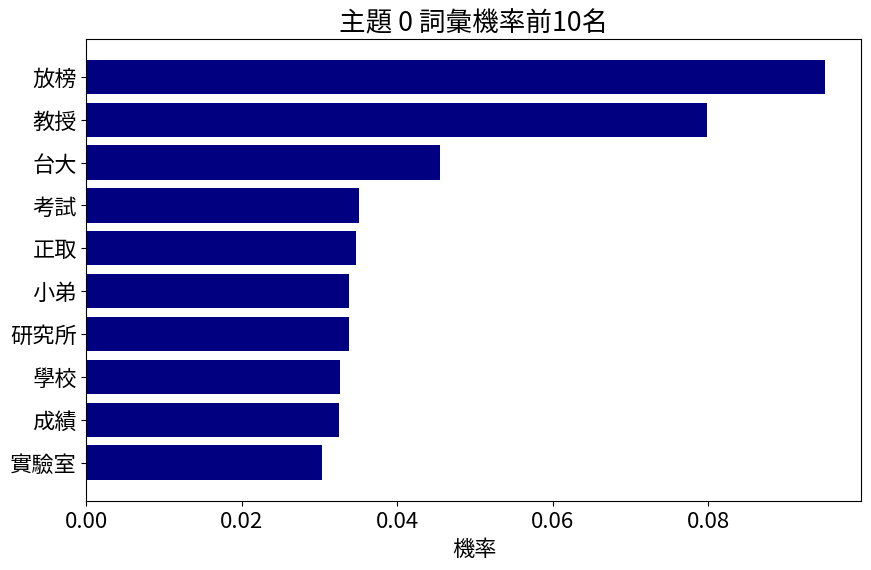

In [ ]:
# Ë¶ñË¶∫ÂåñÈ°ØÁ§∫‰∏ªÈ°å-Ë©ûÂΩôÂàÜ‰Ωà
topic_n = 0
data = zh_topic_model.get_topic(topic_n)

# ËΩâÊèõÁÇ∫DataFrame
df = pd.DataFrame(data, columns=['word', 'prob'])
df = df[df['word'] != ' ']

# Ê†πÊìöprobÊéíÂ∫è‰∏¶ÈÅ∏Âá∫Ââç10Âêç
top_10 = df.sort_values('prob', ascending=False).head(10)

# Áï´Âá∫Èï∑Ê¢ùÂúñ
plt.figure(figsize=(10,6))
plt.barh(top_10['word'], top_10['prob'], color='navy')
plt.xlabel('Ê©üÁéá')
plt.title(f'‰∏ªÈ°å {topic_n} Ë©ûÂΩôÊ©üÁéáÂâç10Âêç')
plt.gca().invert_yaxis()
plt.show()

##### KeyBERT

## Á¨¨‰∏ÄÊ¨°Keybert(ÊúâÂïèÈ°å)

In [ ]:
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance

# KeyBERT
keybert = KeyBERTInspired()

# Ë®≠ÂÆöHDBscanÊ®°Âûã
hdbscan_model = HDBSCAN(min_cluster_size=5, min_samples=30)

# ÂÆöÁæ©ÊàëÂÄëË¶ÅÁî®Âà∞ÁöÑrepresentation modelÔºàÂêåÂ≠∏Â¶ÇÊûúÊÉ≥ÊØîËºÉÂÖ∂‰ªñÊ®°ÂûãÂèØ‰ª•Âú®ÈÄôÈÇäÂä†ÂÖ•ÂÖ∂‰ªñÊ®°ÂûãÊñπÊ≥ïÔºâ
representation_model = {
    "KeyBERT": KeyBERTInspired(),
    "MMR": MaximalMarginalRelevance(diversity=0.3)
}

In [ ]:
# Âª∫Á´ãBERTopicÊ®°Âûã
representation_topic_model = BERTopic(
  # Sub-models
  embedding_model=bert_sentence_model,
  vectorizer_model=jieba_vectorizer,
  # Ë®≠ÂÆöRepresentation model
  representation_model=representation_model,
  # Hyperparameters
  top_n_words=30,
  verbose=True
)

# Train model
topics, probs = representation_topic_model.fit_transform(docs_zh, embeddings)

2025-05-07 20:33:28,283 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-07 20:33:28,902 - BERTopic - Dimensionality - Completed ‚úì
2025-05-07 20:33:28,903 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-07 20:33:28,912 - BERTopic - Cluster - Completed ‚úì
2025-05-07 20:33:28,913 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-07 20:33:30,681 - BERTopic - Representation - Completed ‚úì


In [ ]:
# ËßÄÂØüKeyBERTÂæÆË™øÂæåÁöÑ‰∏ªÈ°åË°®Á§∫
representation_topic_model.get_topic_info()

Topic  Count             Name  \
0     -1    257  -1_ÊïôÊéà_ÊîæÊ¶ú_ÂØ¶È©óÂÆ§_Âè∞Â§ß   
1      0     88    0_È°ûÊØî_Ë≥áË®ä_ÂπæÊ¨°_ÂÆ∂‰∫∫   
2      1     37    1_Â∞èÂºü_ÊïôÊéà_‰∏≠Ëàà_Ê©üÊúÉ   
3      2     34    2_ÂàÜ‰∫´_Ë´ãÂïè_Â≠∏Èï∑_Á∂ìÈ©ó   
4      3     28   3_ÊôÇÈñì_Âè™ËÉΩ_Ë´ñÊñá_Ë≥áÂ∑•Á¢©   
5      4     21    4_ÊîæÊ¶ú_ÊàêÁ∏æ_ÂàÜÊï∏_È†êÊúü   
6      5     14  5_ËÄÅÂ∏´_‰∏çÂèØÂ§öÂæó_ÊïôÂ≠∏_Ëã±Ë™û   
7      6     11    6_Â†±Âà∞_Ë≤°Èáë_Âè∞Â§ß_Ë∑®ËÄÉ   
8      7     10    7_ËààË∂£_ËÆÄÊõ∏_ÊàêÂ∞±_Áù°Ë¶∫   

                                      Representation  \
0  [ÊïôÊéà, ÊîæÊ¶ú, ÂØ¶È©óÂÆ§, Âè∞Â§ß, ÊàêÁ∏æ, ËÄÉË©¶, Á†îÁ©∂ÊâÄ, Èù¢Ë©¶, ËÄÉÁ†î, Â∏åÊúõ, ‰ø°Ëôü,...   
1  [È°ûÊØî, Ë≥áË®ä, ÂπæÊ¨°, ÂÆ∂‰∫∫, ‰∏ãÊâã, ÊÉ≥Âà∞, ÁîüÊ¥ª, ÊÑüË¨ù, ÁÑ¶ÊÖÆ, Ë¨ùË¨ù, ÊÑüË¶∫, Áúü...   
2  [Â∞èÂºü, ÊïôÊéà, ‰∏≠Ëàà, Ê©üÊúÉ, ÊîæÊ¶ú, Â≠∏Ê†°, ÊúâÊ≤íÊúâ, ÂÇôÂèñ, Ê≠£Âèñ, Â§ßÁ•û, ËÄÉË©¶, ...   
3  [ÂàÜ‰∫´, Ë´ãÂïè, Â≠∏Èï∑, Á∂ìÈ©ó, Â∏åÊúõ, ÊÑèË¶ã, ‰∏ÄÁØá, ÁúãÊ≥ï, ÂßêÂÄë, ÂøÉÂæó, ÊÉ≥Âïè, Êúâ...   
4  [ÊôÇÈñì, Âè™ËÉΩ, Ë´ñÊñá, Ë≥áÂ∑•Á¢©, ‰∫∫Áîü, ÁôºÁèæ, ÊÑüË¶∫, ËÉΩÂäõ, ÂØ¶È©ó, ÁóõËã¶, Ë¶∫ÈÜí, ...   
5  [ÊîæÊ¶ú, ÊàêÁ∏æ, ÂàÜÊï∏, È†êÊúü, Ê≠£Âèñ, Êé®ÁîÑ, ÂéüÊú¨, ËêΩÊ¶ú, ‰∏äÊ¶ú, ÁôºÁèæ, ÊÄ™ÊÄ™ÁöÑ, ...   
6  [ËÄÅÂ∏´, ‰∏çÂèØÂ§öÂæó, ÊïôÂ≠∏, Ëã±Ë™û, ËßÄÂøµ, ËÄÅÂ∏´‰∏äË™≤, ÁêÜËß£, Ê∫ùÈÄö, È†àÁî®, Ê¶ÇÂøµ, Ëºî...   
7  [Â†±Âà∞, Ë≤°Èáë, Âè∞Â§ß, Ë∑®ËÄÉ, ÈåÑÂèñ, ÊîæÊ¶ú, Ê≤íÂâçÈÄî, ÁêÜÁßë, ÁêÜÂ∑•Áßë, Ê≤íÂ†±, Ê±ÇÈÅé,...   
8  [ËààË∂£, ËÆÄÊõ∏, ÊàêÂ∞±, Áù°Ë¶∫, ÁõÆÊ®ô, Áñ´ÊÉÖ, Ê¥óÊæ°, Áù°ÈÜí, Â∞çËÆÄ, ÂÆå‰∫ã, Â§ñÈù¢, Âá∫...   

                                             KeyBERT  \
0      [Á†îÁ©∂ÊâÄ, Ê≤í‰ªÄÈ∫º, Ë£úÁøíÁè≠, ËÄÅÂ∏´, Ë´ãÂïè, Ë¨ùË¨ù, ÈõªÊ©üÁ≥ª, È°åÁõÆ, ÊàêÁ∏æÂñÆ, ËÄÉÁ†î]   
1  [Ë™™ÁúüÁöÑ, Ë†ªÂ§ö‰∫∫, ÊúâÂßãÊúâÁµÇ, Â•Ω‰∏çÂ•Ω, Ê≤íÈóú‰øÇ, Áç≤ÁõäÂå™Ê∑∫, ÂÉÖ‰æõÂèÉËÄÉ, Â∞ç‰∏çËµ∑, Á≥üÈÄè...   
2  [ÊàêÂ§ßÊÉ≥Âïè, ÊåáÂ∞éÊïôÊéà, Á†îÁ©∂ÊâÄ, Èù¢Â∞çÁèæÂØ¶, ÈÄôÂÖ©Ê†°, Ë≥áÁÆ°Á≥ª, ‰∏âÁîüÊúâÂπ∏, ÊúâÊ≤íÊúâ, Á¢©...   
3   [ÈÄôÈÉ®ÂàÜ, ÈÄô‰∏ÄÈ°å, ÊúâÊ≤íÊúâ, Ëß£Ê±∫Ëæ¶Ê≥ï, Ë´ãÊïô, ÊÉ≥Âïè, Ë´ãÂïè, ÂæÆ‰∏çË∂≥ÈÅì, ËÅΩËÅΩ, ÂßêËÉΩÁµ¶]   
4  [Áîü‰∏çÂ¶ÇÊ≠ª, ÊüêÁ®ÆÁ®ãÂ∫¶, ËààË∂£ÊÑõÂ•Ω, Ë∑ü‰∏ç‰∏ä, ÊÇ≤ÊÖò‰∏ñÁïå, ËÅΩÂæóÊáÇ, ÁµïÂ§ßÂ§öÊï∏, Ëä±Â§™Â§ö, ...   
5  [ËÄÉË©¶ÂàÜÊï∏, ÂøÉË∑ØÊ≠∑Á®ã, ÊÆä‰∏çÁü•, Èõ¢Êï£Êï∏Â≠∏, ÊÄ™ÊÄ™ÁöÑ, Á†îÁ©∂ÊâÄ, ËÄÉÂÆåË©¶, ÂõûÂÆ∂, Èõ£ÈÅé,...   
6    [ËÄÅÂ∏´‰∏äË™≤, ËÅΩ‰∏çÊáÇ, ËÄÅÂ∏´, ‰∏çÂèØÂ§öÂæó, Ëºî‰ª•, Âπ≥ÊòìËøë‰∫∫, Ê®ôÊ∫ñ, Â±ÖÂ§ö, Â≠∏Âà∞, ÊîæÊÖ¢]   
7      [ÁêÜÂ∑•Áßë, Á†îÁ©∂ÊâÄ, Ë≤°ÈáëÁ≥ª, Ê≤íÂâçÈÄî, ÈÜ´Â∑•, ËÄÉ‰∏ä, ËÄÉÁ†î, Âêå‰∏ÄÂ§©, ÁßëÁ≥ª, ËΩâÁ≥ª]   
8         [Ê≤í‰ªÄÈ∫º, ÂõûÂÆ∂, ‰∏ÄÂ§ßÁæ§, ÁõÆÊ®ô, Áù°Ë¶∫, Áù°ÈÜí, Ê¥óÊæ°, ÈÇ£Âπ¥, ÁúüÁöÑ, ËÆÄÊõ∏]   

                                                MMR  \
0      [ÂØ¶È©óÂÆ§, Á†îÁ©∂ÊâÄ, ËÄÉÁ†î, È°åÁõÆ, ÊåáËÄÉ, Êò•Â≠£Áè≠, ËÄÅÂ∏´, Ë´ãÂïè, Èõª‰ø°‰πô, È†òÂüü]   
1     [ÂπæÊ¨°, Ë¨ùË¨ù, ÊÑüË¶∫, ÈÅéÂæó, ‰∏ÄÂúòÁ≥ü, ÊúâÂßãÊúâÁµÇ, Ê≤íÈóú‰øÇ, ÊØèÂë®, ÊàëÁ∑ö‰ª£, ÊÑèÂ§ñ]   
2        [ÊúâÊ≤íÊúâ, Ê≠£Âèñ, Â§ßÁ•û, ÊÉ≥Âïè, Èù¢Ë´á, Á∂≤Ë∑Ø‰∏ä, Â¶πÂ¶π, Â∞àÊ•≠, Áâà‰∏ä, ÊâìÁÆó]   
3    [Ë´ãÂïè, ÊÉ≥Âïè, ÊäíÁôº, ÂæÆ‰∏çË∂≥ÈÅì, ÈÄôÈÉ®ÂàÜ, ËÅΩËÅΩ, Ëß£Ê±∫Ëæ¶Ê≥ï, Ëµ∞‰æÜ, ÈÄô‰∏ÄÈ°å, Âä†Ë≥¥]   
4    [Ë´ñÊñá, Ë≥áÂ∑•Á¢©, ‰∫∫Áîü, ÊÑüË¶∫, ÊØèÈÄ±, Ë∑ü‰∏ç‰∏ä, ÊÇ≤ÊÖò‰∏ñÁïå, ÈÄôÊôÇÂÄô, Ëæ¶Ê≥ï, ÊöëÊúüÁè≠]   
5  [ÊîæÊ¶ú, È†êÊúü, ÊÄ™ÊÄ™ÁöÑ, ÊòüÊúüÂõõ, ÊòéÂ§©, ÊÆä‰∏çÁü•, ËÄÉÂÆåË©¶, ËÄÉË©¶ÂàÜÊï∏, Ë°®ÂÆö, Èõ¢Êï£Êï∏Â≠∏]   
6  [‰∏çÂèØÂ§öÂæó, ËßÄÂøµ, ËÄÅÂ∏´‰∏äË™≤, Ëºî‰ª•, Â°´È¥®Âºè, ÂØ´Áµ¶, Â±ÖÂ§ö, Âπ≥ÊòìËøë‰∫∫, Ê®ôÊ∫ñ, ËÅΩ‰∏çÊáÇ]   
7    [Ë∑®ËÄÉ, Ê≤íÂâçÈÄî, ÁêÜÂ∑•Áßë, ‰∏çÊ≠∏Ë∑Ø, Ë≤°ÈáëÁ≥ª, ËΩâÁ≥ª, ÈÄ¢Áî≤, ÈÜ´Áí∞, ÈõªË≥áÈÅ∏, Âêå‰∏ÄÂ§©]   
8        [ËÆÄÊõ∏, Áù°Ë¶∫, ÁõÆÊ®ô, Áñ´ÊÉÖ, Ê¥óÊæ°, ÂÆå‰∫ã, ‰∏ÄÂ§ßÁæ§, ÈÇ£Âπ¥, ÂõûÂÆ∂, Ê≤í‰ªÄÈ∫º]   

                                 Representative_Docs  
0  [ËÄÉË©¶ÁîüÊòØ‰∏çÊòØÊ†πÊú¨‰∏çËÉΩÈÅ∏ÊïôÊéà, ÈõñÁÑ∂Áü•ÈÅìÊúâ‰∫õÊïôÊéàËÄÉË©¶ÂâçÂ∞±Êªø‰∫Ü, ÁõÆÂâçÊúâËààË∂£ÊÉ≥Èù¢Ë´áÁöÑÊïôÊéàÊòØËÉ°Êïè...  
1  [Â§öÂØ´ÂπæÊ¨°ÁúüÁöÑÂ∞±ÊúÉ‰∫Ü, ÊàëÂè™Áü•ÈÅìË∑üÈ°ûÊØîÂÆåÂÖ®‰∏çÂêå, ÊòØ‰∏çÊòØÁ≠âÊñºÂè™ËÉΩË≥≠‰∏ÄÊääÂè∞ËÅØÂ§ßÊúÉ‰∏äÊàñÊòØ‰øùÂÆàÁõ¥Êé•...  
2  [Á≠âÂæÖÊîæÊ¶úË†ªÁÑ¶ÊÖÆÁöÑÂ∞èÂºüÊàêÁ∏æ‰∏çÂ§™Â•ΩÂ∑•Êï∏ÈõªÁ£ÅÊõ∏ÂØ©Áü•ÈÅìÈÄôÊ®£ÁöÑÊàêÁ∏æÊ≠£Âèñ‰∏çÂèØËÉΩ‰ΩÜ‰∏çÁ¢∫ÂÆöÊúâÊ≤íÊúâÊ©üÊ

In [ ]:
representation_topic_model.visualize_topics()

In [ ]:
# ‰º∞ÁÆóÊØèÂÄãÊñá‰ª∂Â∞çBERTopicÊØèÂÄã‰∏ªÈ°åÁöÑÊ©üÁéáÂàÜÂ∏É
topic_distr, _ = representation_topic_model.approximate_distribution(docs_zh)

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 15.41it/s]


In [ ]:
# ÂàóÂá∫‰∏ªÈ°åÁöÑ‰ª£Ë°®Ë©ûÂíåÂÖ∂Â∞çÊáâÁöÑÊ¨äÈáç
representation_topic_model.get_topic(0)

[('ÊïôÊéà', 0.06564684690877363),
 ('ÊîæÊ¶ú', 0.06373484648154588),
 ('ËÄÅÂ∏´', 0.0396947087129517),
 ('ÊôÇÈñì', 0.03010814674832609),
 ('ÊàêÁ∏æ', 0.029852207996797185),
 ('Á†îÁ©∂ÊâÄ', 0.028609212838832145),
 ('ÁôºÁèæ', 0.02709733207349348),
 ('Ê≠£Âèñ', 0.026391141649223203),
 ('ÂØ¶È©óÂÆ§', 0.02577320517043768),
 ('Èù¢Ë©¶', 0.025158619841423858),
 ('ËÄÉÁ†î', 0.024782439373320916),
 ('Â≠∏Ê†°', 0.024782439373320916),
 ('Â≠∏Èï∑', 0.023195884653393912),
 ('Â∞èÂºü', 0.022887370271065716),
 ('ÁúüÁöÑ', 0.022887370271065716),
 ('Èù¢Ë´á', 0.0216846344516558),
 ('ËÄÉË©¶', 0.021430091507612138),
 ('ÂàÜÊï∏', 0.021075702723828263),
 ('È†êÊúü', 0.019837342147630315),
 ('ËààË∂£', 0.01917200106291099),
 ('Êù±Ë•ø', 0.01793451962915325),
 ('Âè™ËÉΩ', 0.01717305168904026),
 ('ÂõõÂ§ß', 0.01717305168904026),
 ('Â≠∏Áîü', 0.016531118456358598),
 ('‰∏≠Â±±', 0.016531118456358598),
 ('ÊÉ≥Âïè', 0.016531118456358598),
 ('ÁÑ¶ÊÖÆ', 0.015976667552425824),
 ('‰∏äÊ¶ú', 0.015489024608325573),
 ('Ë¶∫ÈÜí', 0.0150953756066

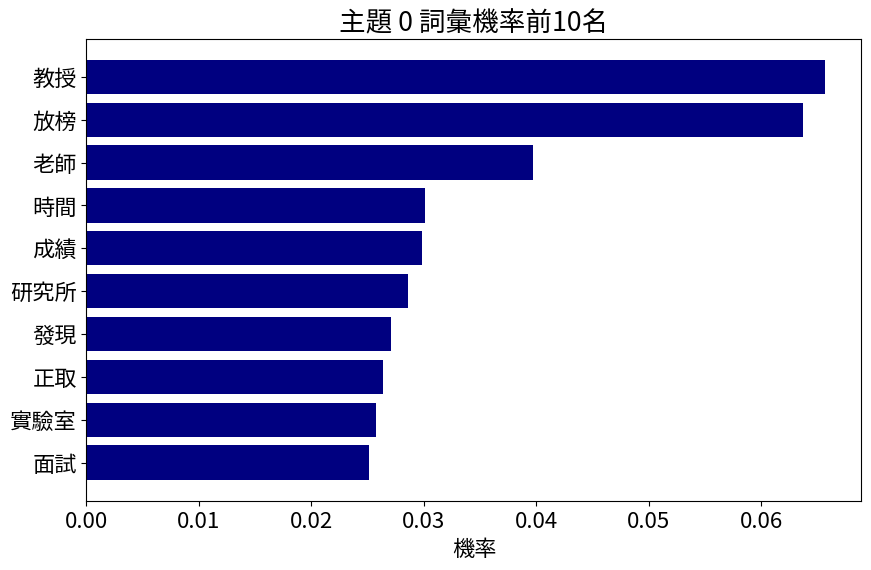

In [ ]:
# Ë¶ñË¶∫ÂåñÈ°ØÁ§∫‰∏ªÈ°å-Ë©ûÂΩôÂàÜ‰Ωà
topic_n = 0
data = representation_topic_model.get_topic(topic_n)

# ËΩâÊèõÁÇ∫DataFrame
df = pd.DataFrame(data, columns=['word', 'prob'])
df = df[df['word'] != ' ']

# Ê†πÊìöprobÊéíÂ∫è‰∏¶ÈÅ∏Âá∫Ââç10Âêç
top_10 = df.sort_values('prob', ascending=False).head(10)

# Áï´Âá∫Èï∑Ê¢ùÂúñ
plt.figure(figsize=(10,6))
plt.barh(top_10['word'], top_10['prob'], color='navy')
plt.xlabel('Ê©üÁéá')
plt.title(f'‰∏ªÈ°å {topic_n} Ë©ûÂΩôÊ©üÁéáÂâç10Âêç')
plt.gca().invert_yaxis()
plt.show()

## Á¨¨‰∫åÊ¨°Keybert

In [ ]:
from bertopic.representation import KeyBERTInspired
# KeyBERT
keybert = KeyBERTInspired()

# Ë®≠ÂÆöHDBscanÊ®°Âûã
hdbscan_model = HDBSCAN(min_cluster_size=5, min_samples=30)

# ÂÆöÁæ©ÊàëÂÄëË¶ÅÁî®Âà∞ÁöÑrepresentation modelÔºàÂêåÂ≠∏Â¶ÇÊûúÊÉ≥ÊØîËºÉÂÖ∂‰ªñÊ®°ÂûãÂèØ‰ª•Âú®ÈÄôÈÇäÂä†ÂÖ•ÂÖ∂‰ªñÊ®°ÂûãÊñπÊ≥ïÔºâ
representation_model = {
    "KeyBERT": keybert,
}

In [ ]:
# Âª∫Á´ãBERTopicÊ®°Âûã
representation_topic_model = BERTopic(
  # Sub-models
  embedding_model=bert_sentence_model,
  vectorizer_model=jieba_vectorizer,
  # Ë®≠ÂÆöRepresentation model
  representation_model=representation_model,
  # Hyperparameters
  top_n_words=30,
  verbose=True
)

# Train model
topics, probs = representation_topic_model.fit_transform(docs_zh, embeddings)

2025-05-07 21:34:44,411 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-07 21:34:44,653 - BERTopic - Dimensionality - Completed ‚úì
2025-05-07 21:34:44,654 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-07 21:34:44,669 - BERTopic - Cluster - Completed ‚úì
2025-05-07 21:34:44,671 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-07 21:34:45,049 - BERTopic - Representation - Completed ‚úì


In [ ]:
# ËßÄÂØüKeyBERTÂæÆË™øÂæåÁöÑ‰∏ªÈ°åË°®Á§∫
representation_topic_model.get_topic_info()

Topic  Count            Name  \
0     -1    174  -1_ÊïôÊéà_‰ø°Ëôü_ÊîæÊ¶ú_Áõ∏Èóú   
1      0    199   0_ÊîæÊ¶ú_ÊïôÊéà_ËÄÅÂ∏´_Èù¢Ë©¶   
2      1     80   1_È°ûÊØî_Ë≥áË®ä_ÂπæÊ¨°_‰∏ãÊâã   
3      2     33   2_ÂàÜ‰∫´_Ë´ãÂïè_Á∂ìÈ©ó_Â≠∏Èï∑   
4      3     14  3_ÂØ¶È©óÂÆ§_ÊïôÊéà_Á´∂Ë≥Ω_Èù¢Ë´á   

                                      Representation  \
0  [ÊïôÊéà, ‰ø°Ëôü, ÊîæÊ¶ú, Áõ∏Èóú, È°åÁõÆ, Ë¨ùË¨ù, ËÄÉÁ†î, ÊàêÁ∏æ, ÂàÜÊï∏, ÈÇ£Á®Æ, Ë™≤Á®ã, Â∏å...   
1  [ÊîæÊ¶ú, ÊïôÊéà, ËÄÅÂ∏´, Èù¢Ë©¶, ÊàêÁ∏æ, Âè∞Â§ß, ÊôÇÈñì, ËÄÉË©¶, ÁôºÁèæ, Ê≠£Âèñ, Â∞èÂºü, Á†î...   
2  [È°ûÊØî, Ë≥áË®ä, ÂπæÊ¨°, ‰∏ãÊâã, ÂÆ∂‰∫∫, ÊÉ≥Âà∞, ÈÅ∏Êìá, ÁÑ¶ÊÖÆ, Ë¨ùË¨ù, ÁúüÁöÑ, ÊäΩÈõ¢, Êñá...   
3  [ÂàÜ‰∫´, Ë´ãÂïè, Á∂ìÈ©ó, Â≠∏Èï∑, Â∏åÊúõ, ÊÑèË¶ã, ‰∏ÄÁØá, ÁúãÊ≥ï, ÂßêÂÄë, ÂøÉÂæó, ÊÉ≥Âïè, Êúâ...   
4  [ÂØ¶È©óÂÆ§, ÊïôÊéà, Á´∂Ë≥Ω, Èù¢Ë´á, ËûçÊ¥Ω, ÊùêÂÖâÁ≥ª, ÂÇæÂêë, ÊâÄÊúâ‰∫∫, ÊÄùËÄÉ, ‰Ω≥‰Ωú, ËßÄÂØü...   

                                             KeyBERT  \
0    [Á†îÁ©∂ÊâÄ, Á∑öÊÄß‰ª£Êï∏, ÈõªÊ©üÁ≥ª, ÊúâÊ≤íÊúâ, ÁîüÊ©üÁ≥ª, Ë´ãÂïè, ËÄÅÂ∏´, ÂØ¶È©óÂÆ§, ËÄÉ‰∏ä, Êï∏‰Ωç]   
1    [ÂïäÂïäÂïä, Ëá™Êàë‰ªãÁ¥π, Á†îÁ©∂ÊâÄ, ÊúâÊ≤íÊúâ, Ê≤í‰ªÄÈ∫º, ÊÉ≥Âïè, ÊâìÁÆó, ËÄÉÁ†î, Á∂≤Ë∑Ø‰∏ä, ËÄÅÂ∏´]   
2  [Ë™™ÁúüÁöÑ, Ë†ªÂ§ö‰∫∫, Ê≤í‰ªÄÈ∫º, ÊúâÂßãÊúâÁµÇ, Áç≤ÁõäÂå™Ê∑∫, Ê≤íÈóú‰øÇ, ÂÉÖ‰æõÂèÉËÄÉ, Â∞ç‰∏çËµ∑, ÈÄôÊòØ...   
3   [ÈÄôÈÉ®ÂàÜ, ÈÄô‰∏ÄÈ°å, ÊúâÊ≤íÊúâ, Ëß£Ê±∫Ëæ¶Ê≥ï, Ë´ãÊïô, ÊÉ≥Âïè, Ë´ãÂïè, ÂæÆ‰∏çË∂≥ÈÅì, ËÅΩËÅΩ, ÂßêËÉΩÁµ¶]   
4      [Á†îÁ©∂ÊâÄ, Ê©üÂô®‰∫∫, ÂØ¶È©óÂÆ§, ÊâÄÊúâ‰∫∫, Ë´ãÂïè, ËÄÅÂ∏´, ÊùêÂÖâÁ≥ª, Â∞àÈ°å, ÂèÉÂä†, Ë∫´ÁÇ∫]   

                                 Representative_Docs  
0  [ÂØíÂÅá‰ºëÊÅØ‰∏ÄÈÄ±ÂæåÊàëÂ∞±ÈñãÂßãÊ∫ñÂÇôËÄÉË©¶‰ø°ËôüÂõ†ÁÇ∫‰πãÂâçËÆÄÂÆå‰∫ÜÊâÄ‰ª•Â∞±Âà∑‰∏Ä‰∏ãË™≤Êú¨ÁöÑÈ°åÁõÆÁ∂≠ÊåÅ‰∏Ä‰∏ãÁÜüÁ∑¥Â∫¶ÈÄöÂéüÁúã...  
1  [ÁõÆÂâçËÄÉË©¶ÁöÑÂ§ßÈÉ®ÂàÜÂ≠∏Ê†°ÈÉΩÊîæÊ¶ú‰∫ÜÂ∏åÊúõÂ§ßÂÆ∂ÈÉΩÊúâ‰∏äÂøÉÂÑÄÁöÑÂ≠∏Ê†°ÊÉ≥Âïè‰∏Ä‰∏ãÁâà‰∏äÁöÑÂêÑ‰ΩçÂ§ßÁ•ûÊúÉÊÄéÈ∫ºÈÅ∏ÊìáÂë¢Â∞èÂºü...  
2                 [Â§öÂØ´ÂπæÊ¨°ÁúüÁöÑÂ∞±ÊúÉ‰∫Ü, ÈÅ∏ÊìáÊàñÈ°ûÊØîÁöÑÁêÜÁî±, ÊàëÂè™Áü•ÈÅìË∑üÈ°ûÊØîÂÆåÂÖ®‰∏çÂêå]  
3     [Â∏åÊúõÊúâÂ≠∏Èï∑ÂßêÂèØ‰ª•‰æÜÂàÜ‰∫´‰∏Ä‰∏ã, Â∏åÊúõÊúâÂ≠∏Èï∑ÂßêÂÄëÂèØ‰ª•ÂàÜ‰∫´‰∏Ä‰∏ã, Âõ†Ê≠§Ê±∫ÂÆöÂú®Ê≠§‰πüÂàÜ‰∫´Ëá™Ë∫´ÁöÑÁ∂ìÈ©ó]  
4  [ÊàëÂÇæÂêëË¶ÅÂØÑ‰ΩÜÊàë‰πüÈÇÑÂú®ÊÄùËÄÉÈÄ≤Âì™ÂÄãÊïôÊéàÁöÑÂØ¶È©óÂÆ§, ÈÄ≤‰∏çÂêåÁöÑÂØ¶È©óÂÆ§ÂÅöÁ†îÁ©∂‰∏çÁ¢∫ÂÆöÊîøÊ≤ªÊâÄÁöÑÊòØÂê¶‰πüÈúÄË¶Å...

In [ ]:
representation_topic_model.visualize_topics()

ÂÖ±ÂàÜÊàêÂõõÂÄã‰∏ªÈ°åÔºåÁõ∏ÊØîÁ¨¨‰∏ÄÊ¨° BERTopic Ôºå‰∏ªÈ°åÂàÜÂ∏ÉËºÉÂàÜÊï£„ÄÅ‰ª£Ë°®ÊÄßÊõ¥Âº∑ÔºåÊØîËºÉÊ≤íÊúâ‰∏ªÈ°å‰πãÈñìÂçÄÂà•Ê®°Á≥äÂïèÈ°å

In [ ]:
# ‰º∞ÁÆóÊØèÂÄãÊñá‰ª∂Â∞çBERTopicÊØèÂÄã‰∏ªÈ°åÁöÑÊ©üÁéáÂàÜÂ∏É
topic_distr, _ = representation_topic_model.approximate_distribution(docs_zh)

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 14.75it/s]


In [ ]:
# ÂàóÂá∫‰∏ªÈ°åÁöÑ‰ª£Ë°®Ë©ûÂíåÂÖ∂Â∞çÊáâÁöÑÊ¨äÈáç
representation_topic_model.get_topic(3)

[('ÂØ¶È©óÂÆ§', 0.4405085573996698),
 ('ÊïôÊéà', 0.2869103416889155),
 ('Á´∂Ë≥Ω', 0.19255689791272493),
 ('Èù¢Ë´á', 0.15004796139705148),
 ('ËûçÊ¥Ω', 0.11772327582561841),
 ('ÊùêÂÖâÁ≥ª', 0.11772327582561841),
 ('ÂÇæÂêë', 0.11772327582561841),
 ('ÊâÄÊúâ‰∫∫', 0.11772327582561841),
 ('ÊÄùËÄÉ', 0.11772327582561841),
 ('‰Ω≥‰Ωú', 0.11772327582561841),
 ('ËßÄÂØü', 0.11772327582561841),
 ('Ë∑üÁ≥ª', 0.11772327582561841),
 ('Â≠∏ÊúÉ', 0.11772327582561841),
 ('Ë∫´ÁÇ∫', 0.11772327582561841),
 ('Èõ¢Èñã', 0.11772327582561841),
 ('ÂâçËº©', 0.11772327582561841),
 ('Âà•Ê†°', 0.11772327582561841),
 ('ÊîøÊ≤ª', 0.10418050939297621),
 ('ÂèÉÂä†', 0.10418050939297621),
 ('ÊèêÂà∞', 0.10418050939297621),
 ('ÂåóÈÉ®', 0.10418050939297621),
 ('Áî∞Èñì', 0.10418050939297621),
 ('È¢®Ê∞£', 0.10418050939297621),
 ('Ê©üÂô®‰∫∫', 0.10418050939297621),
 ('ÈñãÂè£', 0.10418050939297621),
 ('Á∂ìÊ≠∑', 0.09627844895636246),
 ('ÂëÇÂæ∑', 0.09627844895636246),
 ('Ê®°Êì¨', 0.09627844895636246),
 ('ÂØ¶È©ó', 0.09068574143694648),
 ('Á

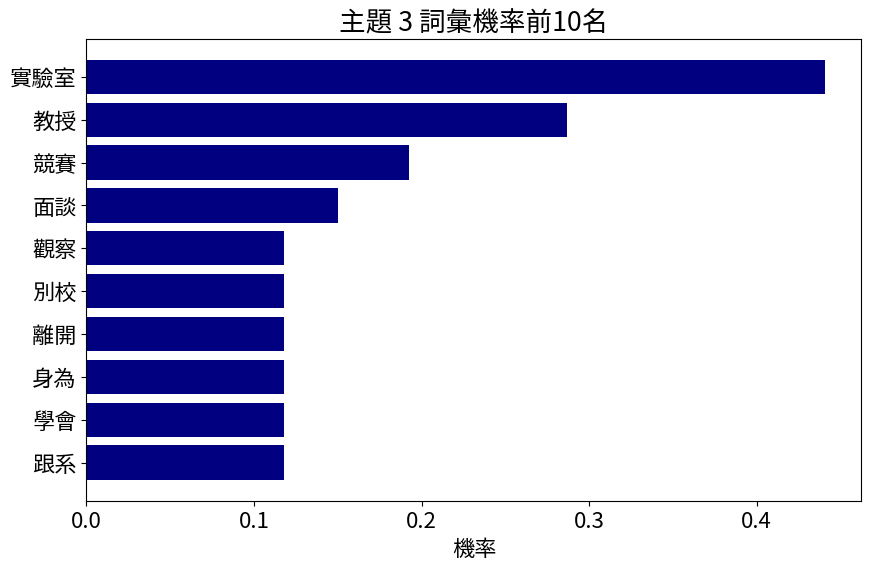

In [ ]:
# Ë¶ñË¶∫ÂåñÈ°ØÁ§∫‰∏ªÈ°å-Ë©ûÂΩôÂàÜ‰Ωà
topic_n = 3
data = representation_topic_model.get_topic(topic_n)

# ËΩâÊèõÁÇ∫DataFrame
df = pd.DataFrame(data, columns=['word', 'prob'])
df = df[df['word'] != ' ']

# Ê†πÊìöprobÊéíÂ∫è‰∏¶ÈÅ∏Âá∫Ââç10Âêç
top_10 = df.sort_values('prob', ascending=False).head(10)

# Áï´Âá∫Èï∑Ê¢ùÂúñ
plt.figure(figsize=(10,6))
plt.barh(top_10['word'], top_10['prob'], color='navy')
plt.xlabel('Ê©üÁéá')
plt.title(f'‰∏ªÈ°å {topic_n} Ë©ûÂΩôÊ©üÁéáÂâç10Âêç')
plt.gca().invert_yaxis()
plt.show()

ÂæûÈ´òÊ¨äÈáçË©ûÂΩô‰æÜÁúãÔºå‰∏ªÈ°å 3 ÂæàÂèØËÉΩËàá‰ª•‰∏ã‰∏ªÈ°åÁõ∏ÈóúÔºö

Áî≥Ë´ãÁ†îÁ©∂ÊâÄÊôÇÈÅ∏ÊìáÂØ¶È©óÂÆ§ËàáÊåáÂ∞éÊïôÊéàÁöÑÁ∂ìÈ©óËàáËßÄÂØü

ÂæûÂÖ∂‰ªñÂ≠∏Ê†°„ÄÅÂÖ∂‰ªñÂØ¶È©óÂÆ§ËΩâÊèõÊôÇÁöÑË©ï‰º∞ËàáÂøÉÁêÜÊ≠∑Á®ã

ÂèÉÂä†Á´∂Ë≥Ω„ÄÅÈù¢Ë´áÁ≠âËàáÈåÑÂèñÁõ∏ÈóúÁöÑÈóúÈçµÁ∂ìÊ≠∑

Â∞çÂ∞éÂ∏´‰ΩúÈ¢®ËàáÂØ¶È©óÂÆ§Ê∞õÂúçÁöÑÂèçÊÄù